In [ ]:

try:
    import xgboost
    print("XGBoost is already installed.")
except ImportError:
    print("XGBoost not found. Attempting to install XGBoost...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
        print("XGBoost installed successfully.")
        import xgboost
    except Exception as e:
        print(f"Error installing XGBoost: {e}")
        print("Please install XGBoost manually (e.g., 'pip install xgboost') and then re-run the script.")
        xgboost = None


XGBoost is already installed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm #
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.weightstats import ztest

# For Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# For Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB


# For Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import learning_curve, cross_val_score

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

file_path = '/content/Dengue data.csv' path
try:
    df_original = pd.read_csv(file_path)
    df = df_original.copy()
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the file path.")
    print("Exiting script as dataset is required.")
    exit()


Dataset loaded successfully.


In [ ]:
# --- Column Name Cleaning ---
print("\nOriginal Column Names:")
print(df.columns)

original_columns = df.columns
new_columns = [str(col).replace(' (%)', '_percent')
               .replace(' (gm/dl)', '_gmdl')
               .replace('(mm)', '_mm')
               .replace('(TC) (/cumm)', '_tc_cumm')
               .replace(' (/cumm)', '_cumm')
               .replace(' (m/ul)', '_mul')
               .replace('/PCV (%)', '_pcv_percent')
               .replace(' (fl)', '_fl')
               .replace(' (pg)', '_pg')
               .replace(' (g/dl)', '_gdl')
               .replace('(PC)(/cumm)', '_pc_cumm') # Specific fix for Platelet count
               .replace(' ', '_')
               .replace('.', '') for col in original_columns]
df.columns = new_columns


Original Column Names:
Index(['Age', 'HB (gm/dl)', 'ESR(mm)', 'WBC(TC) (/cumm)', 'Neutrophils (%)',
       'lymphocytes (%)', 'Monocytes (%)', 'Eosinophils (%)',
       'Cir Eosinophils (/cumm)', 'RBC (m/ul)', 'HTC/PCV (%)', 'MCV (fl)',
       'MCH (pg)', 'MCHC (g/dl)', 'RDW  (%)', 'PDW (fl)',
       'Platelete(PC)(/cumm)', 'MPV (fl)', 'PCT (%)', 'Class Identification'],
      dtype='object')


In [ ]:
print("\nCleaned Column Names:")
print(df.columns)

# --- Initial Data Inspection ---
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nDataset Information:")
df.info()
print("\nDataset Shape:")
print(df.shape)
print("\nSummary statistics before detailed preprocessing:")
print(df.describe(include='all'))


Cleaned Column Names:
Index(['Age', 'HB_gmdl', 'ESR_mm', 'WBC_tc_cumm', 'Neutrophils_percent',
       'lymphocytes_percent', 'Monocytes_percent', 'Eosinophils_percent',
       'Cir_Eosinophils_cumm', 'RBC_mul', 'HTC/PCV_percent', 'MCV_fl',
       'MCH_pg', 'MCHC_gdl', 'RDW__percent', 'PDW_fl', 'Platelete_pc_cumm',
       'MPV_fl', 'PCT_percent', 'Class_Identification'],
      dtype='object')

First 5 rows of the dataset:
    Age  HB_gmdl  ESR_mm  WBC_tc_cumm  Neutrophils_percent  \
0  14.0     11.4    28.0       4200.0                   57   
1  26.0     12.2    43.0       4700.0                   77   
2  42.0     14.9   103.0      19800.0                   82   
3  35.0     13.9    12.0       9700.0                   88   
4   8.0     10.0    28.0      10600.0                   46   

   lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
0                   36                  5                    2   
1                   19                  3                    1   
2  

In [ ]:
df.head()

Age  HB_gmdl  ESR_mm  WBC_tc_cumm  Neutrophils_percent  \
0  14.0     11.4    28.0       4200.0                   57   
1  26.0     12.2    43.0       4700.0                   77   
2  42.0     14.9   103.0      19800.0                   82   
3  35.0     13.9    12.0       9700.0                   88   
4   8.0     10.0    28.0      10600.0                   46   

   lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
0                   36                  5                    2   
1                   19                  3                    1   
2                   15                  2                    1   
3                   10                  1                    1   
4                   42                  2                   10   

   Cir_Eosinophils_cumm  RBC_mul  HTC/PCV_percent  MCV_fl  MCH_pg  MCHC_gdl  \
0                    84     4.64             37.0    79.7    24.6      30.8   
1                    47     4.24             39.7    93.6    28.8      30.8   
2                   198     5.31             47.4    89.3    28.1      30.8   
3                    97     5.49             46.3    84.3    25.3      30.8   
4                  1060     3.99             33.0    82.7    25.1      30.8   

   RDW__percent  PDW_fl  Platelete_pc_cumm  MPV_fl  PCT_percent  \
0          15.5    20.1             167000    10.3         0.07   
1          14.3    12.9             277000     8.5         0.24   
2          13.7    12.7             215000     9.1         0.20   
3          14.1    12.7             282000     8.7         0.25   
4          13.7    11.5             337000     7.6         0.26   

  Class_Identification  
0             Negative  
1             Positive  
2             Negative  
3             Negative  
4             Negative

# Data Preprocessing

In [ ]:

print("\nMissing values before handling (sum):")
print(df.isnull().sum())
print(f"\nTotal missing values before handling: {df.isnull().sum().sum()}")

# Some features like MPV_fl or PDW_fl might have 0s that are effectively missing values.
# Example: MPV (Mean Platelet Volume) being 0 is physiologically unlikely.
cols_to_check_for_zeros = ['MPV_fl', 'PDW_fl', 'PCT_percent']
for col in cols_to_check_for_zeros:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        if zero_count > 0:
            print(f"Column '{col}' has {zero_count} zero values.")

            if col in ['MPV_fl', 'PDW_fl']:
                 df[col] = df[col].replace(0, np.nan)
                 print(f"Replaced 0s in '{col}' with NaN for imputation.")



Missing values before handling (sum):
Age                     2
HB_gmdl                 0
ESR_mm                  2
WBC_tc_cumm             0
Neutrophils_percent     0
lymphocytes_percent     0
Monocytes_percent       0
Eosinophils_percent     0
Cir_Eosinophils_cumm    0
RBC_mul                 0
HTC/PCV_percent         0
MCV_fl                  0
MCH_pg                  0
MCHC_gdl                0
RDW__percent            0
PDW_fl                  0
Platelete_pc_cumm       0
MPV_fl                  1
PCT_percent             0
Class_Identification    0
dtype: int64

Total missing values before handling: 5
Column 'MPV_fl' has 1 zero values.
Replaced 0s in 'MPV_fl' with NaN for imputation.
Column 'PDW_fl' has 1 zero values.
Replaced 0s in 'PDW_fl' with NaN for imputation.
Column 'PCT_percent' has 1 zero values.


In [ ]:

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

if 'Class_Identification' in numerical_cols:
    numerical_cols.remove('Class_Identification')
if 'Class_Identification' in categorical_cols:
    categorical_cols.remove('Class_Identification')

In [ ]:
# Impute missing values for numerical columns using median (robust to outliers)
imputer_numerical = SimpleImputer(strategy='median')
if numerical_cols: # Check if there are any numerical columns to impute
    df[numerical_cols] = imputer_numerical.fit_transform(df[numerical_cols])
    print(f"\nMissing values in numerical columns imputed using median.")
else:
    print("\nNo numerical columns found for imputation (or only target is numerical).")



Missing values in numerical columns imputed using median.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   499 non-null    float64
 1   HB_gmdl               499 non-null    float64
 2   ESR_mm                499 non-null    float64
 3   WBC_tc_cumm           499 non-null    float64
 4   Neutrophils_percent   499 non-null    float64
 5   lymphocytes_percent   499 non-null    float64
 6   Monocytes_percent     499 non-null    float64
 7   Eosinophils_percent   499 non-null    float64
 8   Cir_Eosinophils_cumm  499 non-null    float64
 9   RBC_mul               499 non-null    float64
 10  HTC/PCV_percent       499 non-null    float64
 11  MCV_fl                499 non-null    float64
 12  MCH_pg                499 non-null    float64
 13  MCHC_gdl              499 non-null    float64
 14  RDW__percent          499 non-null    float64
 15  PDW_fl                4

In [ ]:

if categorical_cols:
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = imputer_categorical.fit_transform(df[categorical_cols])
    print(f"Missing values in categorical columns imputed using mode.")
else:
    print("\nNo categorical columns (excluding target) found for imputation.")



No categorical columns (excluding target) found for imputation.


In [ ]:

print("\nMissing values after handling (sum):")
print(df.isnull().sum())
print(f"Total missing values after handling: {df.isnull().sum().sum()}")



Missing values after handling (sum):
Age                     0
HB_gmdl                 0
ESR_mm                  0
WBC_tc_cumm             0
Neutrophils_percent     0
lymphocytes_percent     0
Monocytes_percent       0
Eosinophils_percent     0
Cir_Eosinophils_cumm    0
RBC_mul                 0
HTC/PCV_percent         0
MCV_fl                  0
MCH_pg                  0
MCHC_gdl                0
RDW__percent            0
PDW_fl                  0
Platelete_pc_cumm       0
MPV_fl                  0
PCT_percent             0
Class_Identification    0
dtype: int64
Total missing values after handling: 0


In [ ]:
df1 = df.copy()

In [ ]:

target_column = 'Class_Identification'
if target_column in df.columns:
    if df[target_column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[target_column]):
        print(f"\nOriginal unique values in '{target_column}': {df[target_column].unique()}")
        label_encoder_target = LabelEncoder()
        df[target_column] = label_encoder_target.fit_transform(df[target_column])

        print(f"Encoded classes for '{target_column}': {label_encoder_target.classes_} -> {label_encoder_target.transform(label_encoder_target.classes_)}")
        print(f"Target variable '{target_column}' encoded.")
        print(df[target_column].value_counts())
    elif pd.api.types.is_numeric_dtype(df[target_column]):
        print(f"\nTarget variable '{target_column}' is already numeric.")
        print(df[target_column].value_counts())
    else:
        print(f"\nTarget variable '{target_column}' has an unexpected data type: {df[target_column].dtype}")
else:
    print(f"\nError: Target column '{target_column}' not found. Please check column names.")




Original unique values in 'Class_Identification': ['Negative' 'Positive']
Encoded classes for 'Class_Identification': ['Negative' 'Positive'] -> [0 1]
Target variable 'Class_Identification' encoded.
Class_Identification
0    404
1     95
Name: count, dtype: int64


In [ ]:
df.head()

Age  HB_gmdl  ESR_mm  WBC_tc_cumm  Neutrophils_percent  \
0  14.0     11.4    28.0       4200.0                 57.0   
1  26.0     12.2    43.0       4700.0                 77.0   
2  42.0     14.9   103.0      19800.0                 82.0   
3  35.0     13.9    12.0       9700.0                 88.0   
4   8.0     10.0    28.0      10600.0                 46.0   

   lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
0                 36.0                5.0                  2.0   
1                 19.0                3.0                  1.0   
2                 15.0                2.0                  1.0   
3                 10.0                1.0                  1.0   
4                 42.0                2.0                 10.0   

   Cir_Eosinophils_cumm  RBC_mul  HTC/PCV_percent  MCV_fl  MCH_pg  MCHC_gdl  \
0                  84.0     4.64             37.0    79.7    24.6      30.8   
1                  47.0     4.24             39.7    93.6    28.8      30.8   
2                 198.0     5.31             47.4    89.3    28.1      30.8   
3                  97.0     5.49             46.3    84.3    25.3      30.8   
4                1060.0     3.99             33.0    82.7    25.1      30.8   

   RDW__percent  PDW_fl  Platelete_pc_cumm  MPV_fl  PCT_percent  \
0          15.5    20.1           167000.0    10.3         0.07   
1          14.3    12.9           277000.0     8.5         0.24   
2          13.7    12.7           215000.0     9.1         0.20   
3          14.1    12.7           282000.0     8.7         0.25   
4          13.7    11.5           337000.0     7.6         0.26   

   Class_Identification  
0                     0  
1                     1  
2                     0  
3                     0  
4                     0

In [ ]:
df1.head()

Age  HB_gmdl  ESR_mm  WBC_tc_cumm  Neutrophils_percent  \
0  14.0     11.4    28.0       4200.0                 57.0   
1  26.0     12.2    43.0       4700.0                 77.0   
2  42.0     14.9   103.0      19800.0                 82.0   
3  35.0     13.9    12.0       9700.0                 88.0   
4   8.0     10.0    28.0      10600.0                 46.0   

   lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
0                 36.0                5.0                  2.0   
1                 19.0                3.0                  1.0   
2                 15.0                2.0                  1.0   
3                 10.0                1.0                  1.0   
4                 42.0                2.0                 10.0   

   Cir_Eosinophils_cumm  RBC_mul  HTC/PCV_percent  MCV_fl  MCH_pg  MCHC_gdl  \
0                  84.0     4.64             37.0    79.7    24.6      30.8   
1                  47.0     4.24             39.7    93.6    28.8      30.8   
2                 198.0     5.31             47.4    89.3    28.1      30.8   
3                  97.0     5.49             46.3    84.3    25.3      30.8   
4                1060.0     3.99             33.0    82.7    25.1      30.8   

   RDW__percent  PDW_fl  Platelete_pc_cumm  MPV_fl  PCT_percent  \
0          15.5    20.1           167000.0    10.3         0.07   
1          14.3    12.9           277000.0     8.5         0.24   
2          13.7    12.7           215000.0     9.1         0.20   
3          14.1    12.7           282000.0     8.7         0.25   
4          13.7    11.5           337000.0     7.6         0.26   

  Class_Identification  
0             Negative  
1             Positive  
2             Negative  
3             Negative  
4             Negative

# EDA ( Exploratory Data Analysis )

In [ ]:
print("\n--- Starting Exploratory Data Analysis (EDA) ---")


print("\nDescriptive Statistics (after initial imputation):")
print(df.describe(include='all'))


--- Starting Exploratory Data Analysis (EDA) ---

Descriptive Statistics (after initial imputation):
              Age     HB_gmdl      ESR_mm    WBC_tc_cumm  Neutrophils_percent  \
count  499.000000  499.000000  499.000000     499.000000           499.000000   
mean    32.093788   11.944709   31.949299   10063.020842            58.683367   
std     18.659876    1.985614   24.856771   11851.649223            13.913673   
min      0.100000    4.200000    0.000000      14.400000            17.000000   
25%     18.000000   10.700000   12.000000    6200.000000            50.000000   
50%     29.000000   11.800000   27.000000    8500.000000            60.000000   
75%     44.000000   13.400000   44.000000   11250.000000            67.000000   
max     90.000000   16.700000  127.000000  129000.000000            91.000000   

       lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
count           499.000000         499.000000           499.000000   
mean             33.653307  

## Target Variable Distribution

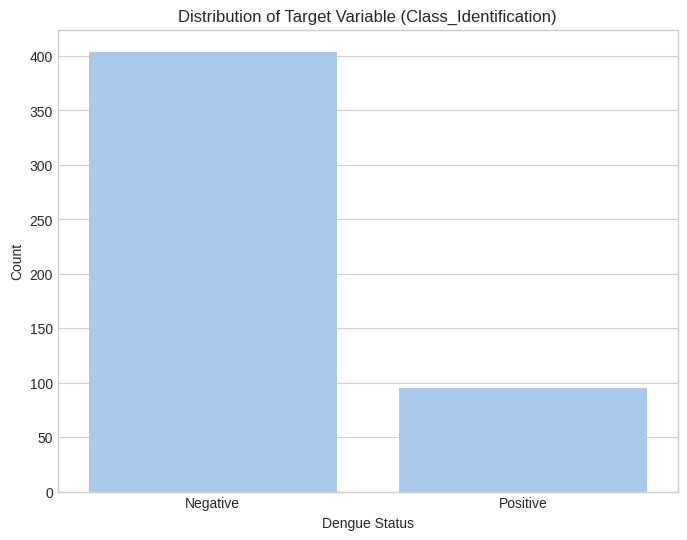

In [ ]:

if target_column in df.columns and pd.api.types.is_numeric_dtype(df[target_column]):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target_column, data=df)
    plt.title('Distribution of Target Variable (Class_Identification)')

    try:
        plt.xticks(ticks=label_encoder_target.transform(label_encoder_target.classes_),
                   labels=label_encoder_target.classes_)
    except NameError:
        unique_targets = sorted(df[target_column].unique())
        if len(unique_targets) == 2: # Binary case
             plt.xticks(ticks=unique_targets, labels=[f'Class {int(u)}' for u in unique_targets])
        else:
             plt.xticks(ticks=unique_targets)

    plt.xlabel('Dengue Status')
    plt.ylabel('Count')
    plt.show()
else:
    print(f"Cannot plot target distribution: '{target_column}' not found or not numeric.")


## Univariate Analysis ( Numerical Features )

### Histogram Plot -- Box Plot


Univariate Analysis for Numerical Features: ['Age', 'HB_gmdl', 'ESR_mm', 'WBC_tc_cumm', 'Neutrophils_percent', 'lymphocytes_percent', 'Monocytes_percent', 'Eosinophils_percent', 'Cir_Eosinophils_cumm', 'RBC_mul', 'HTC/PCV_percent', 'MCV_fl', 'MCH_pg', 'MCHC_gdl', 'RDW__percent', 'PDW_fl', 'Platelete_pc_cumm', 'MPV_fl', 'PCT_percent']


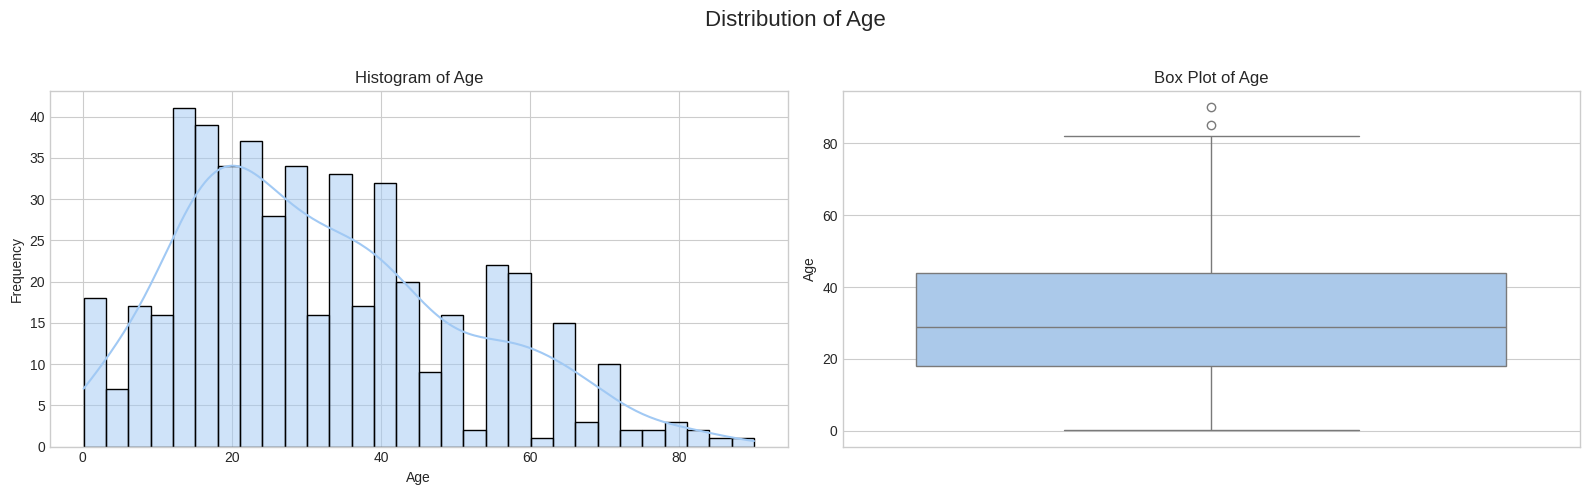

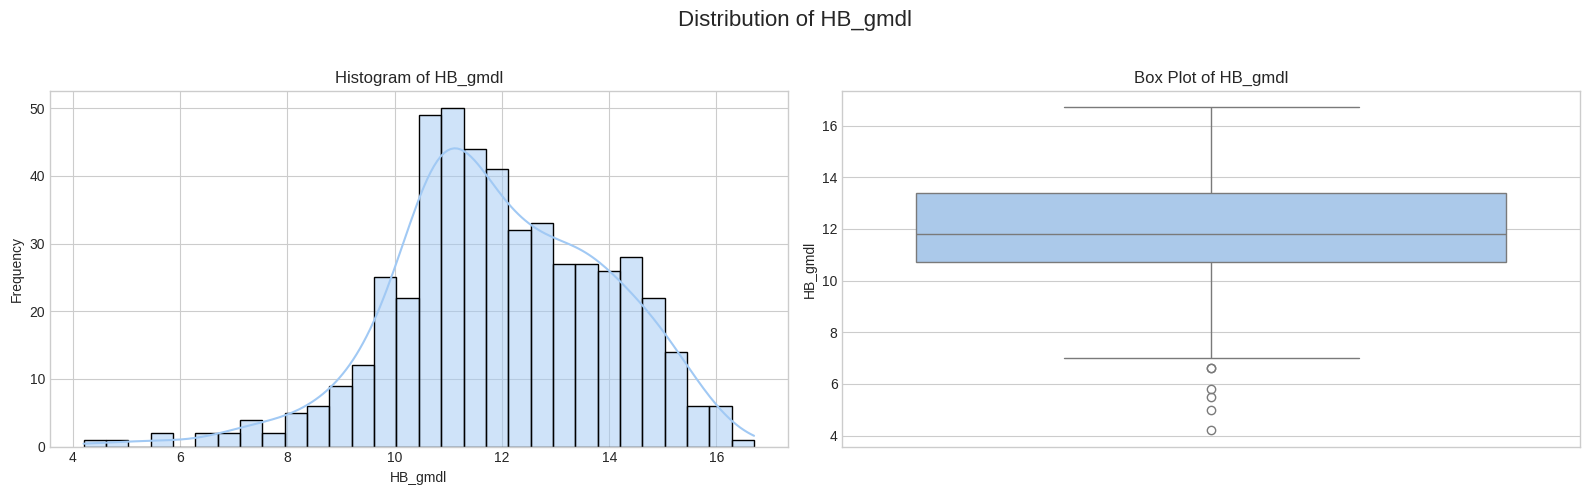

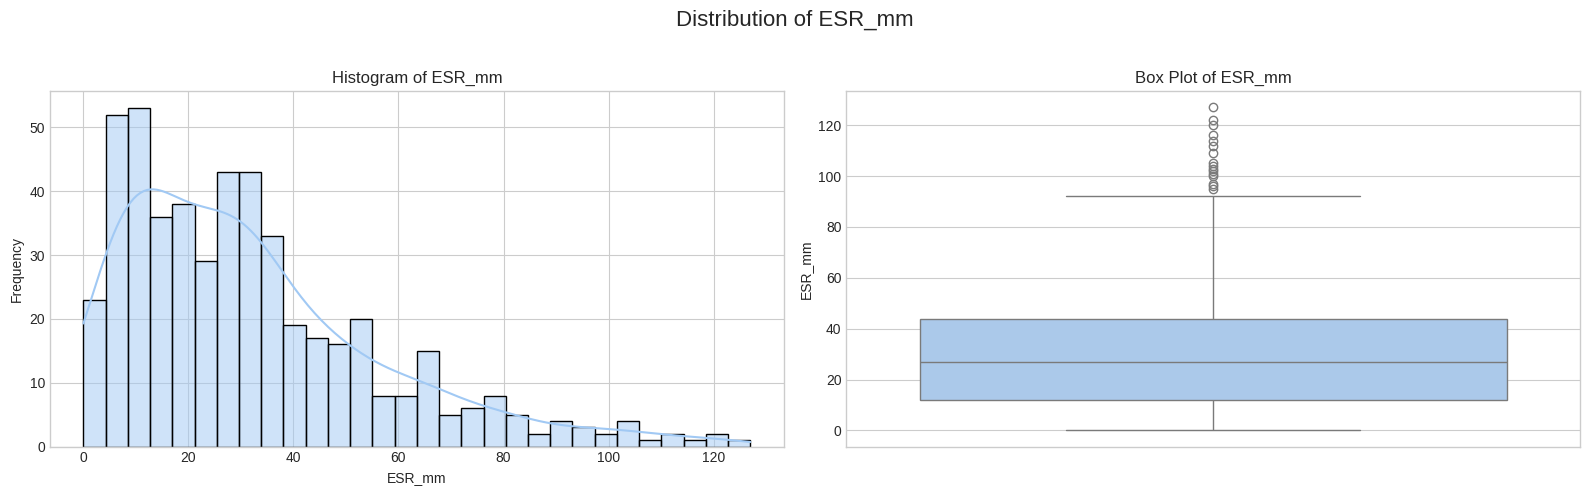

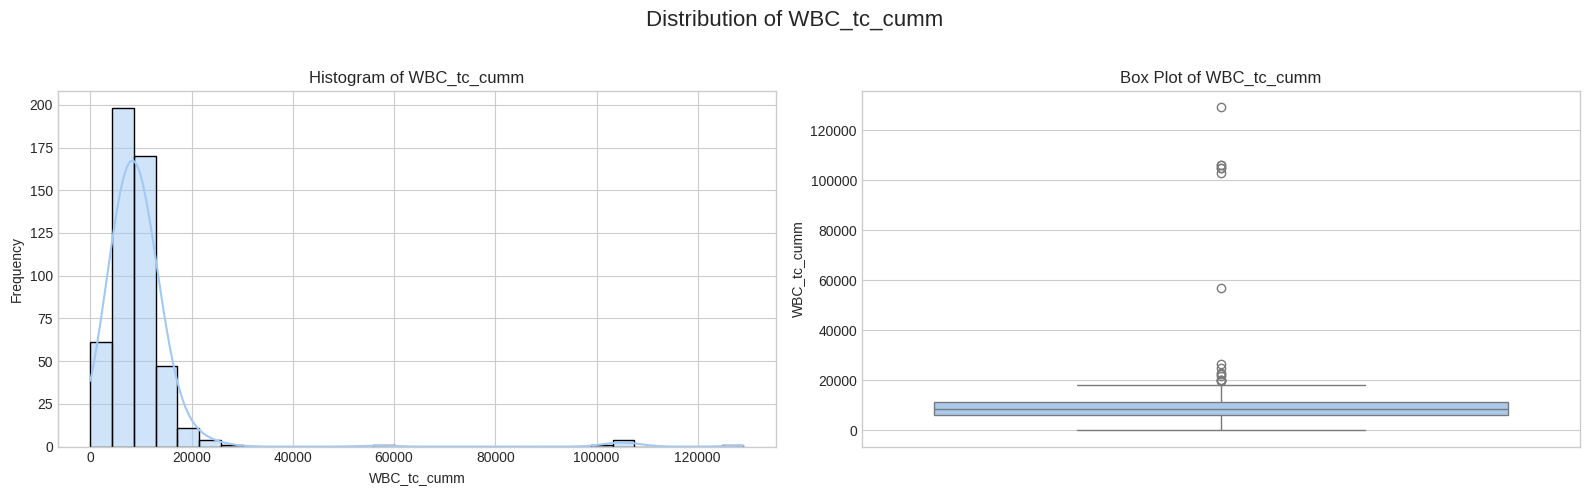

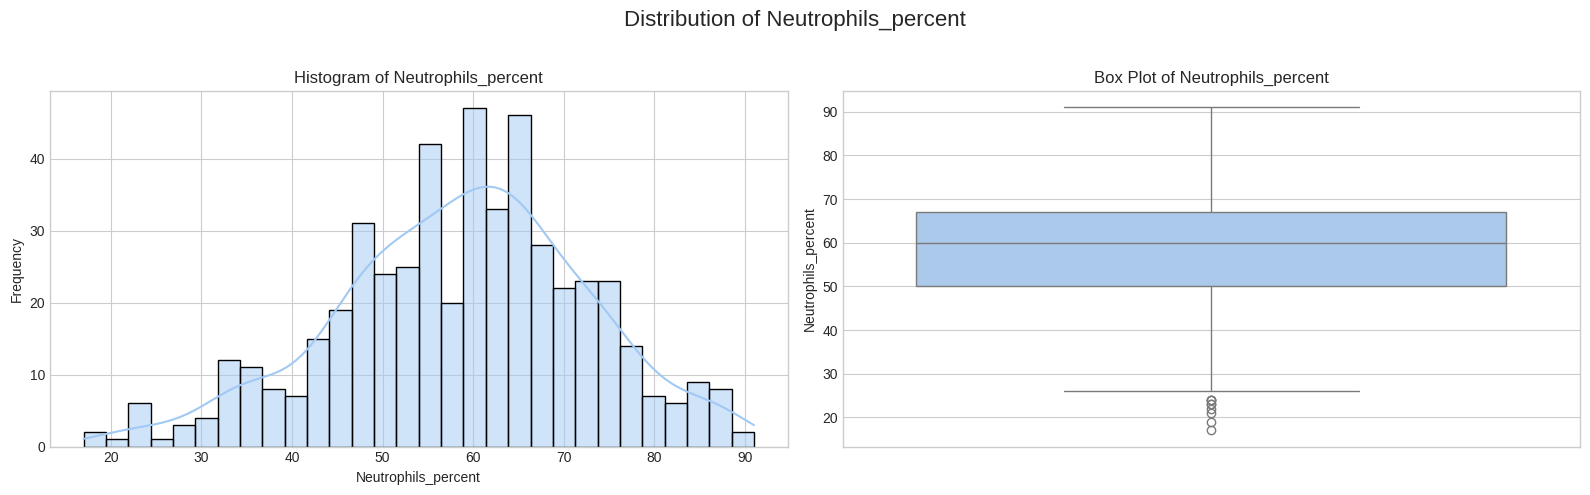

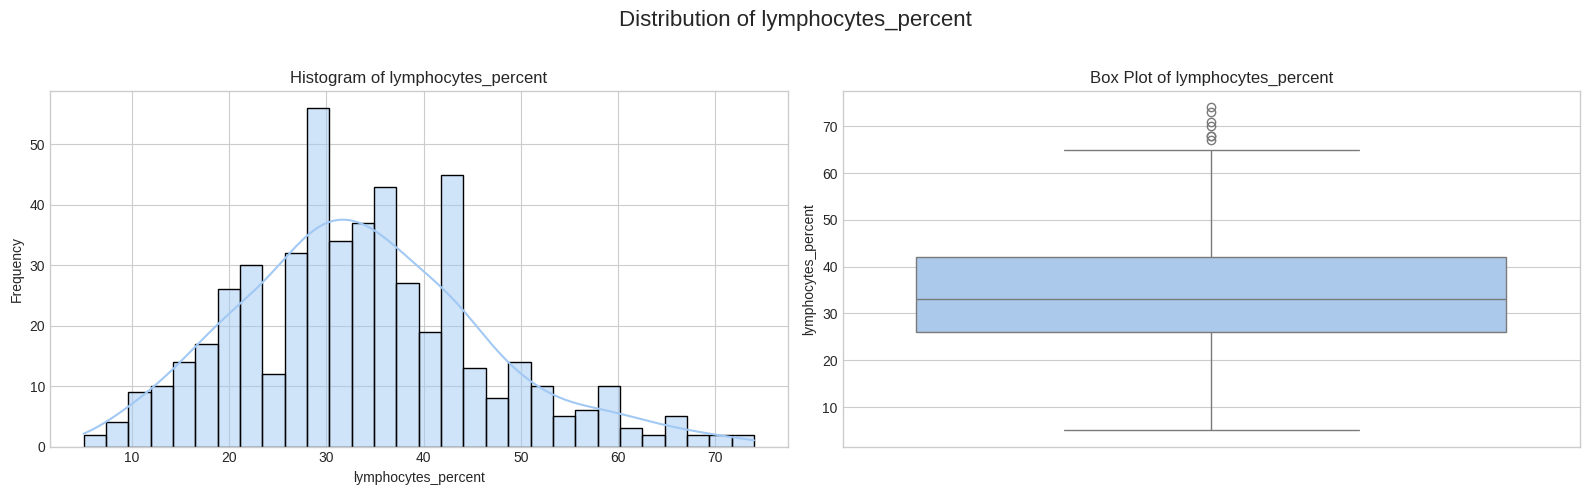

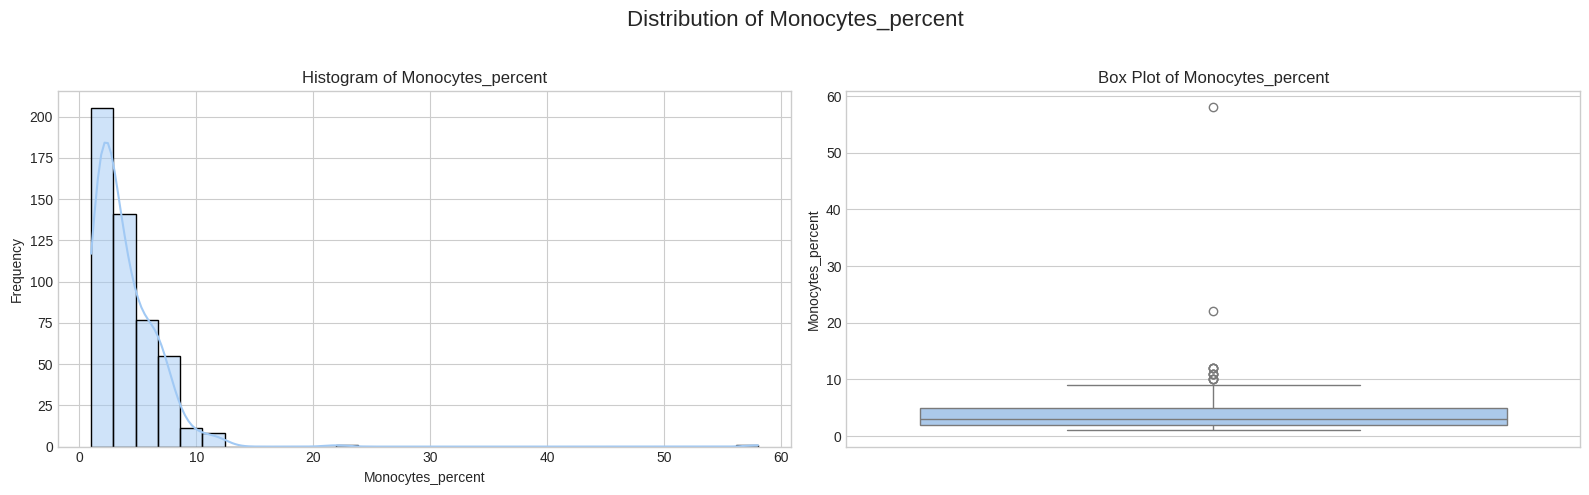

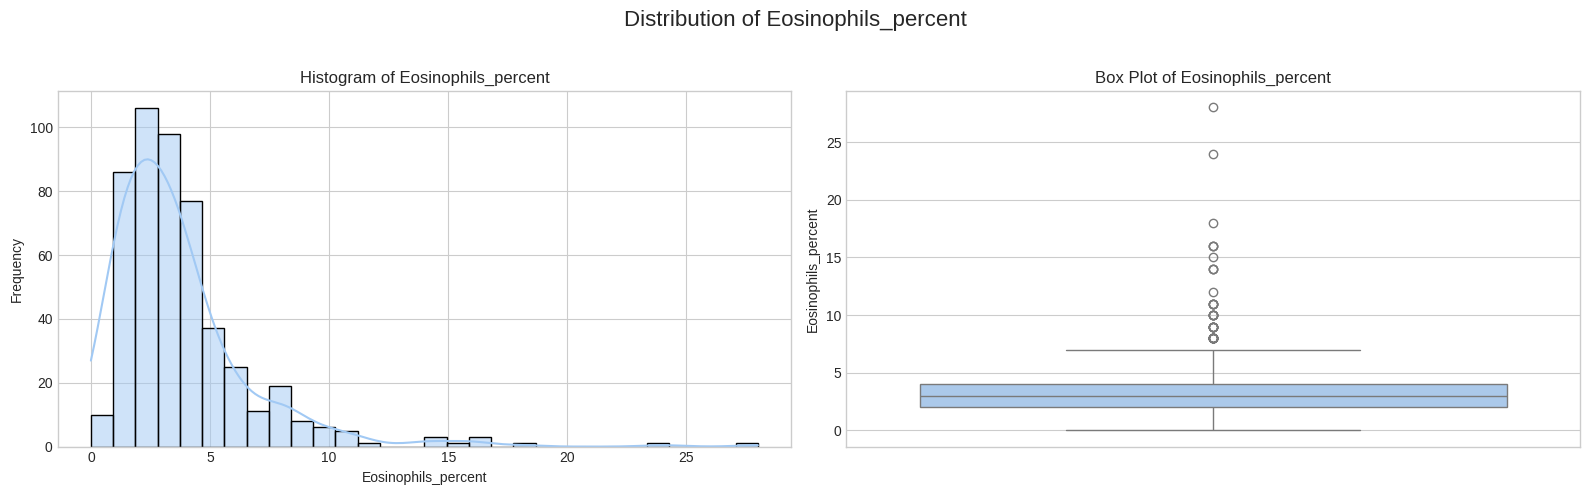

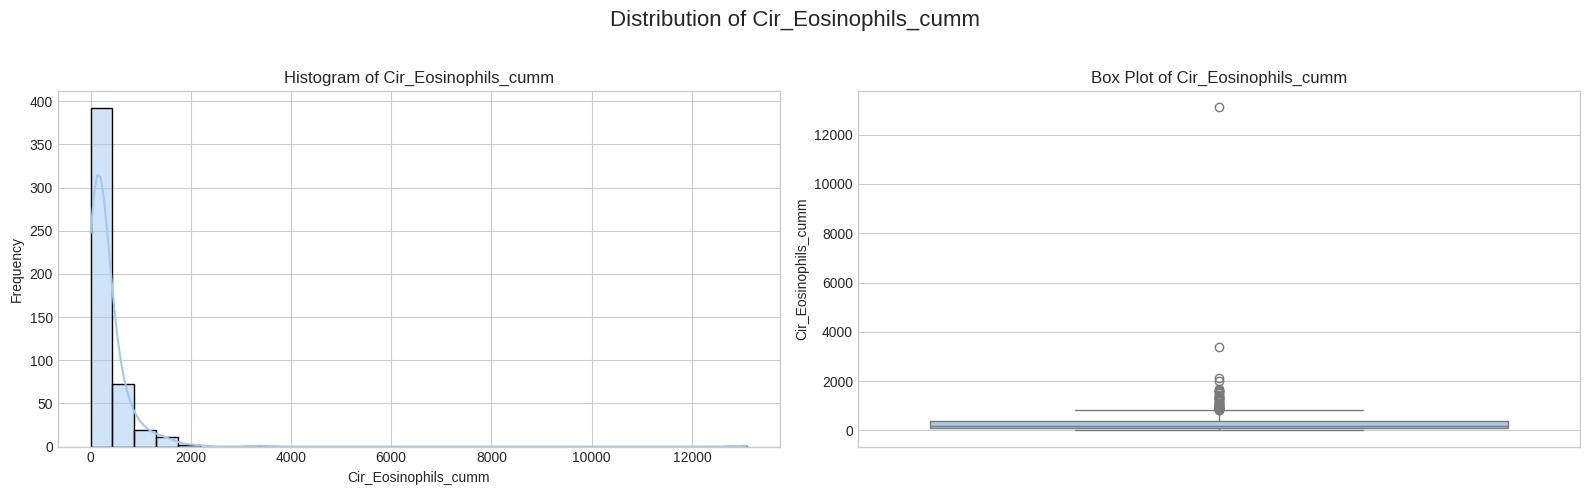

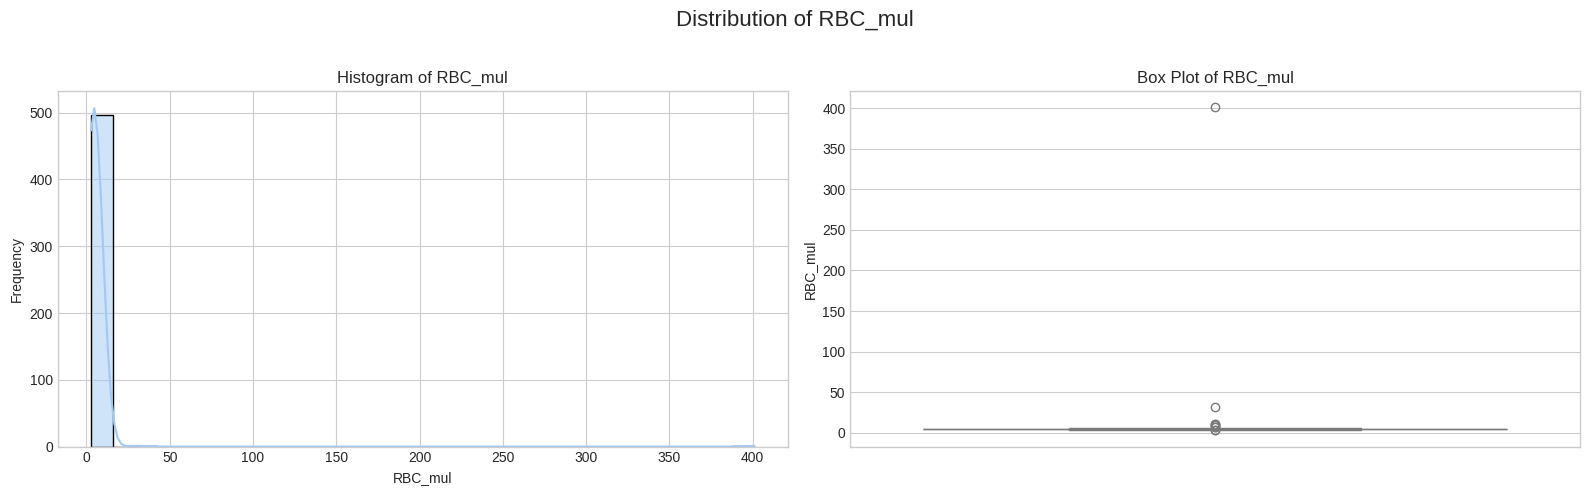

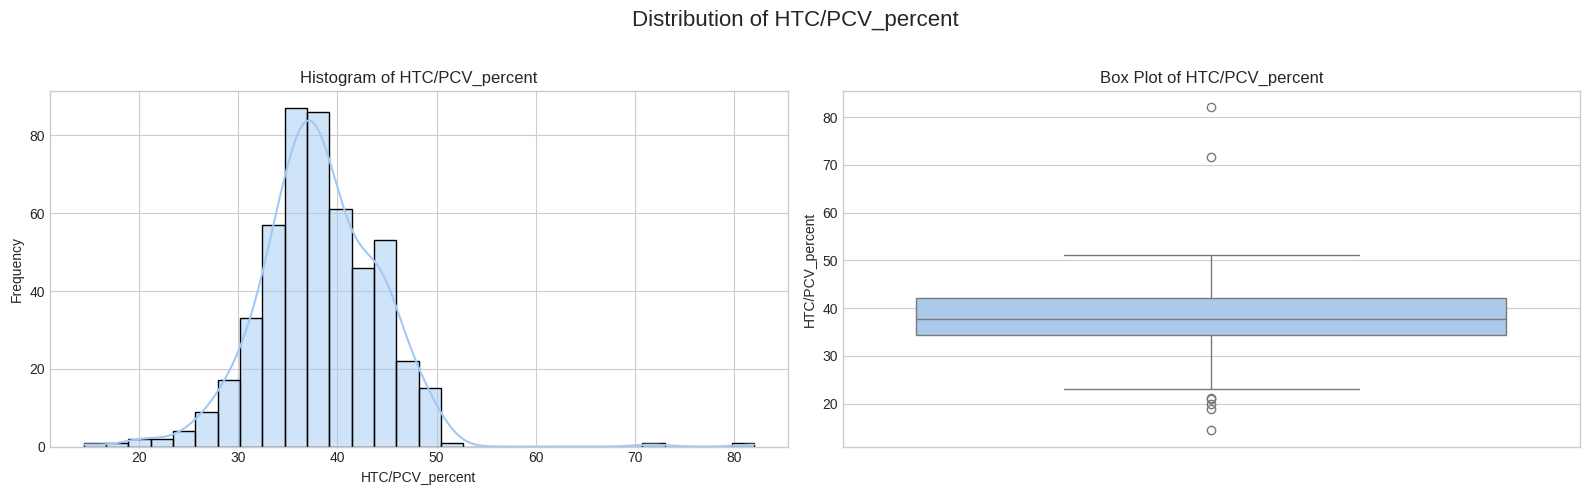

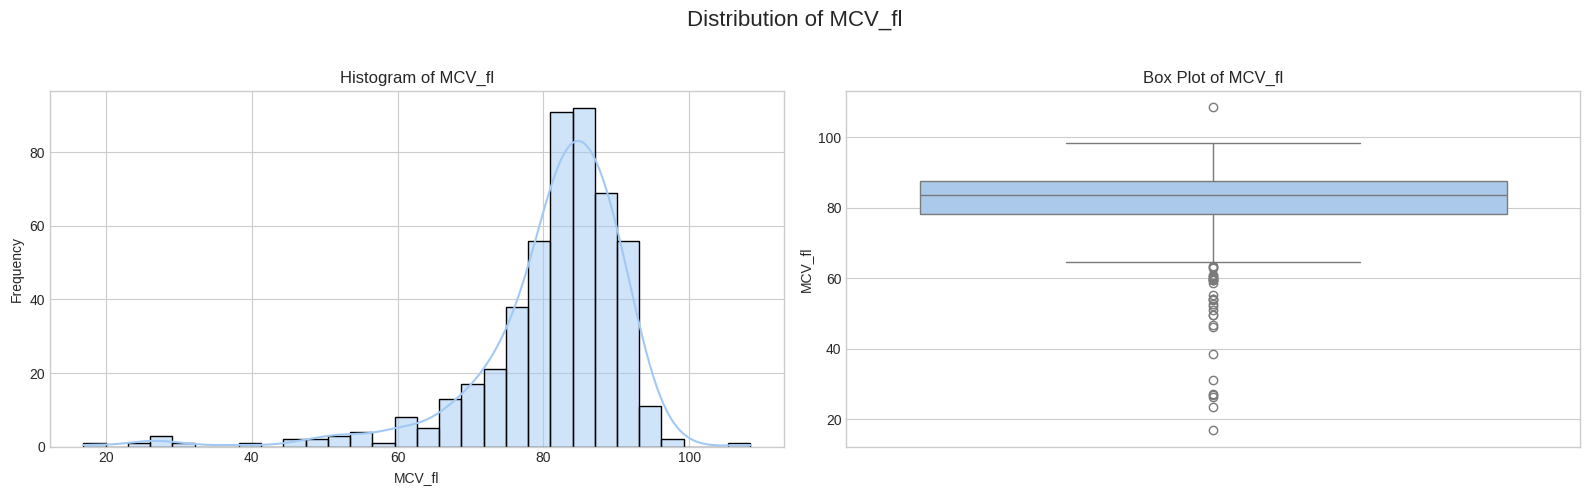

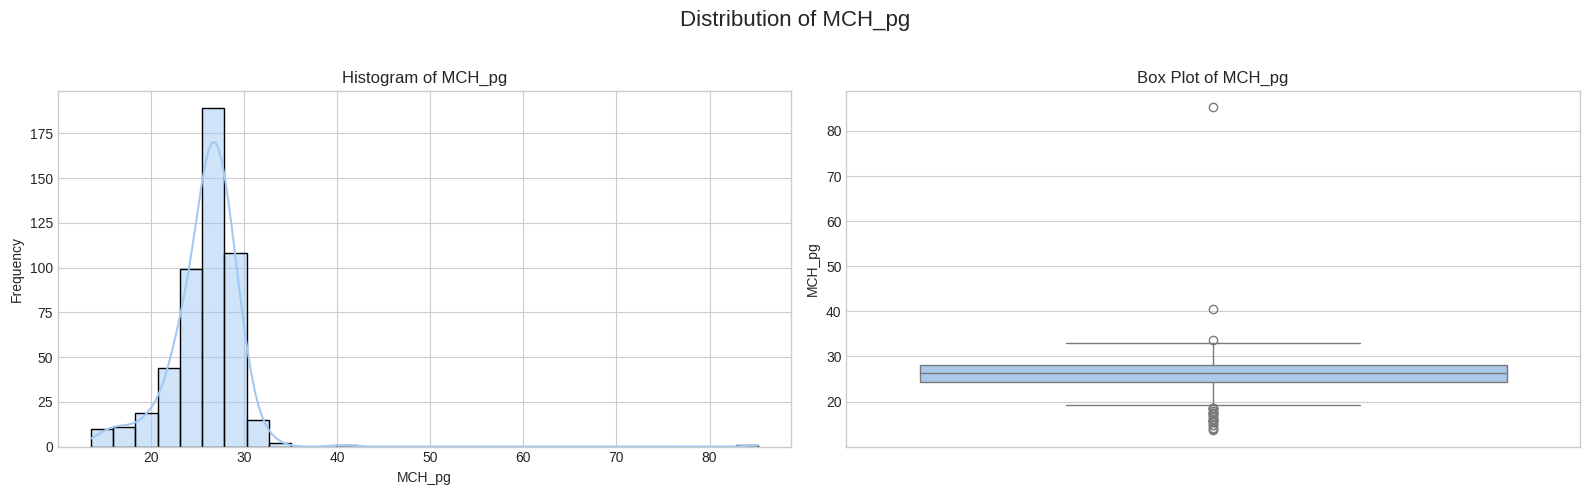

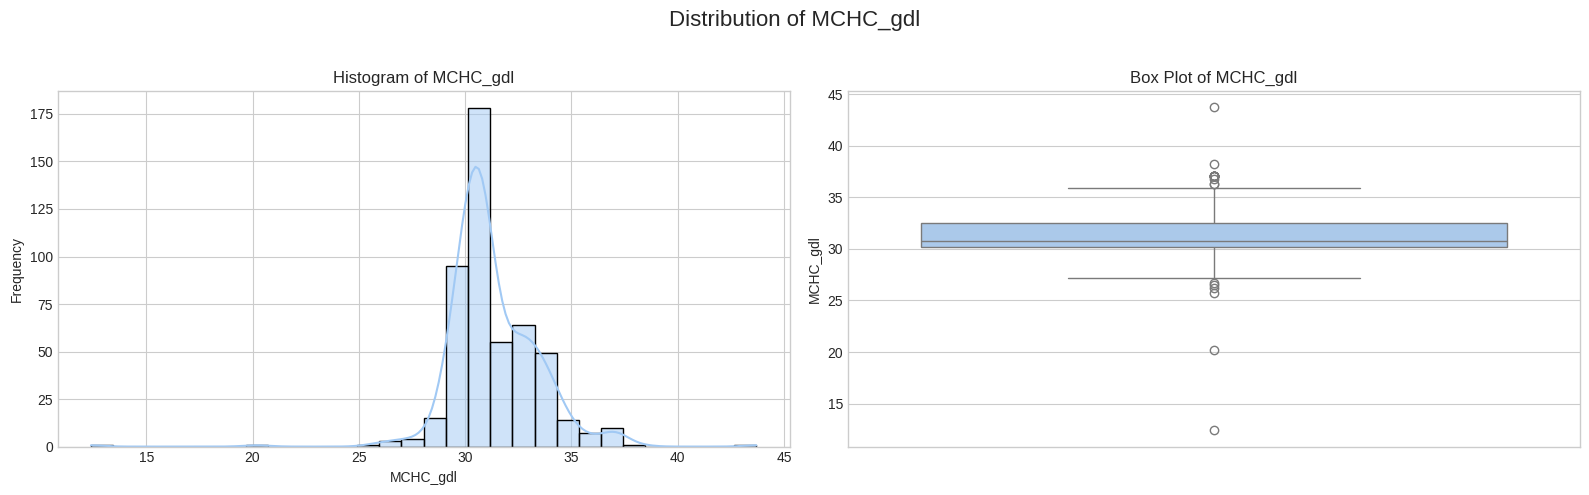

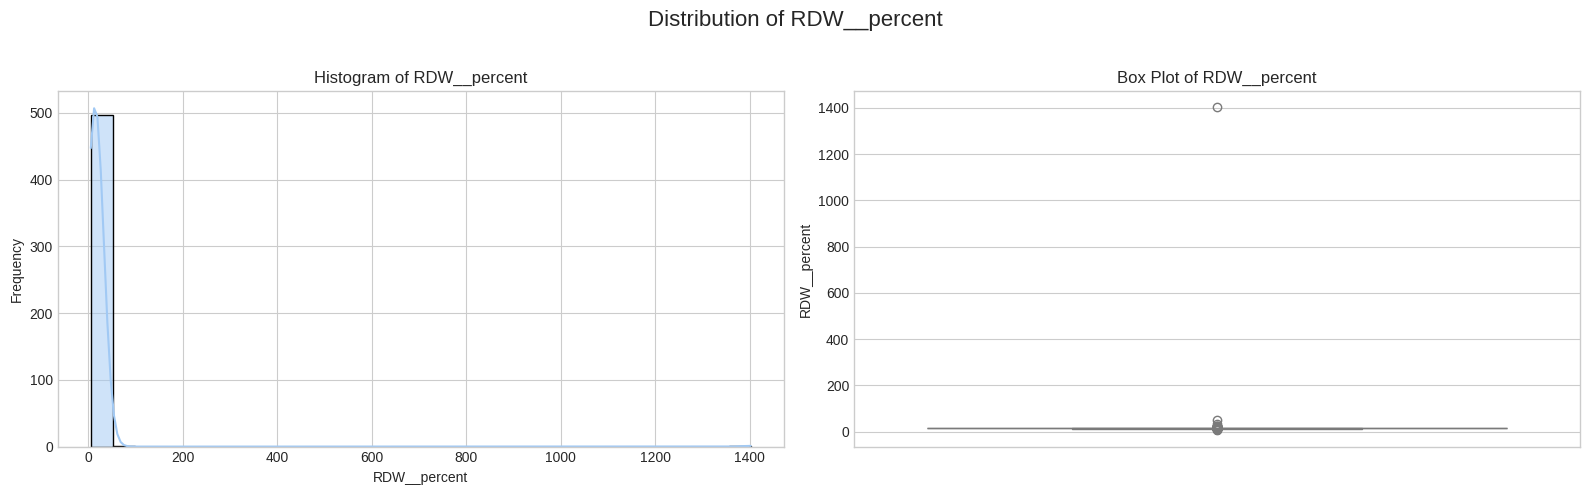

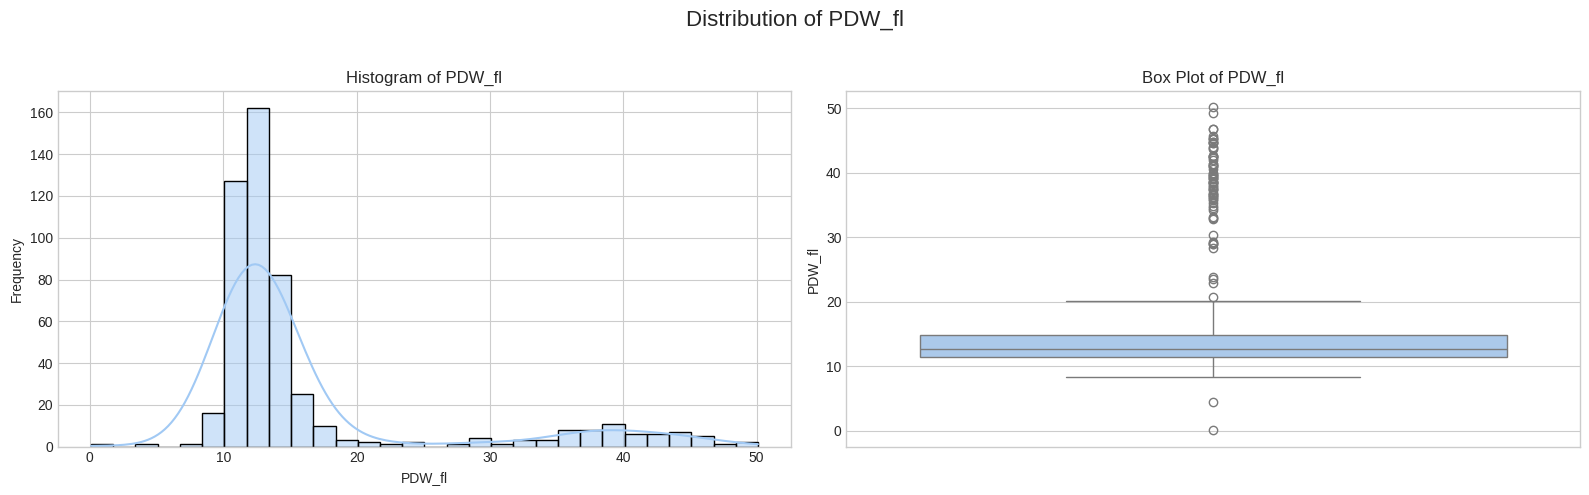

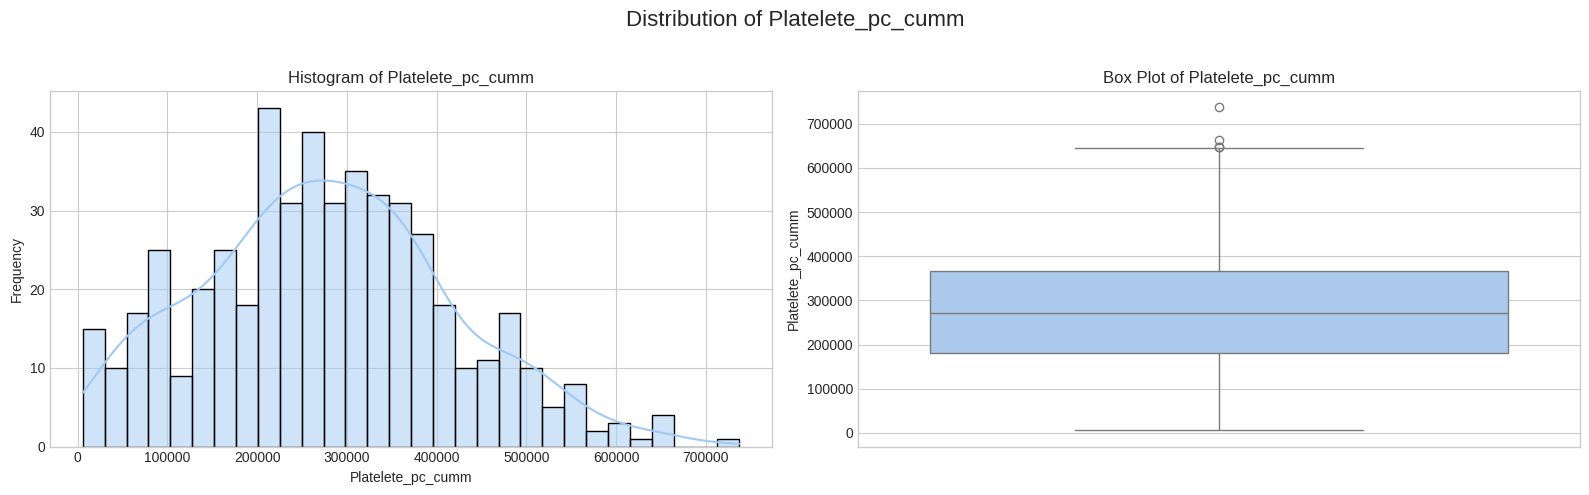

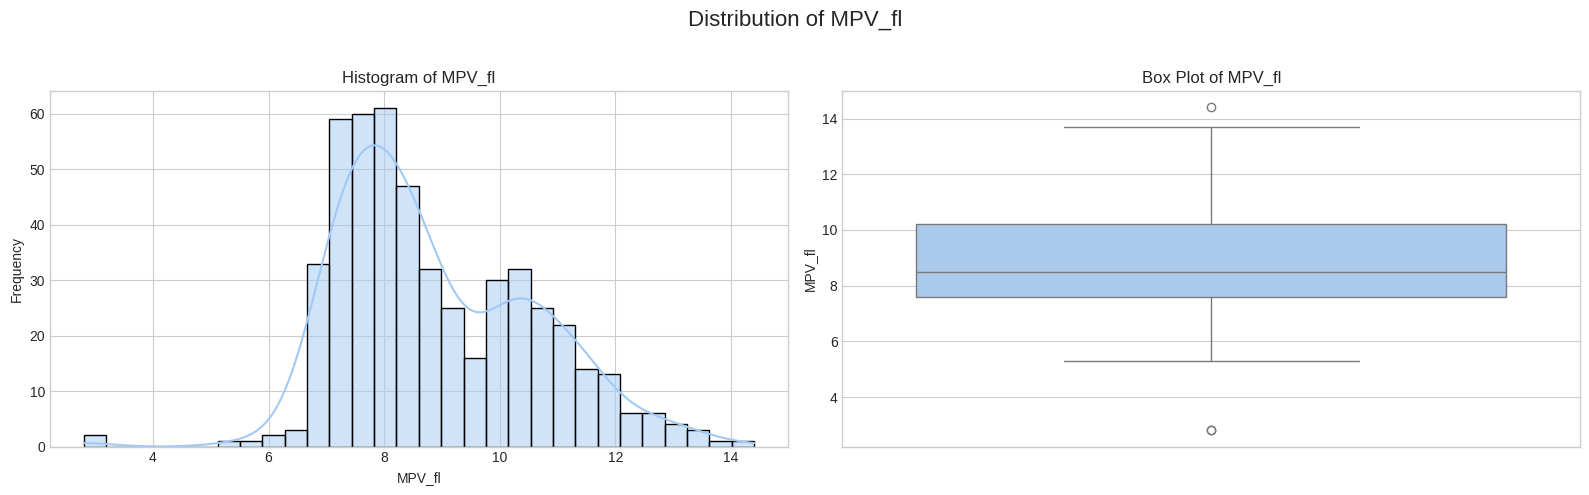

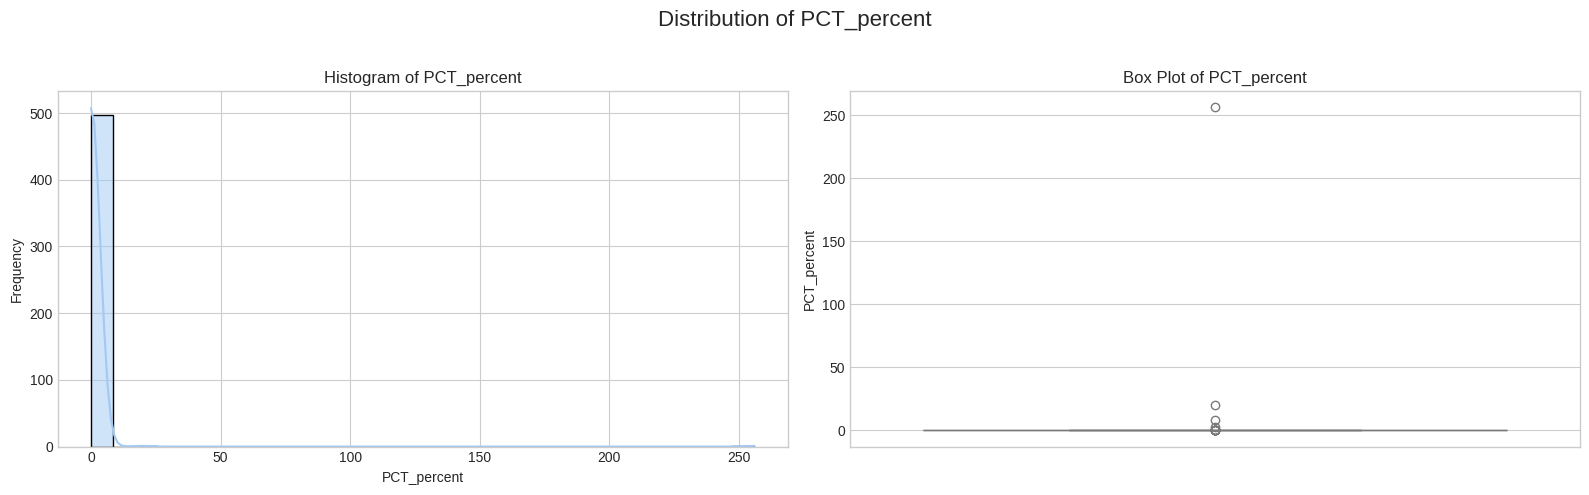

In [ ]:

numerical_features_eda = df.select_dtypes(include=np.number).columns.tolist()
if target_column in numerical_features_eda:
    numerical_features_eda.remove(target_column)

print(f"\nUnivariate Analysis for Numerical Features: {numerical_features_eda}")
for col in numerical_features_eda:
    if col == target_column: continue
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    sns.histplot(df[col], kde=True, ax=axes[0], bins=30)
    axes[0].set_title(f'Histogram of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    sns.boxplot(y=df[col], ax=axes[1])
    axes[1].set_title(f'Box Plot of {col}')
    axes[1].set_ylabel(col)
    plt.suptitle(f"Distribution of {col}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) suptitle
    plt.show()

## Bivariate Analysis

### Numerical Features versus Target Variable (Class)

### Box Plot --- Violin Plot


Bivariate Analysis: Numerical Features vs. Target Variable


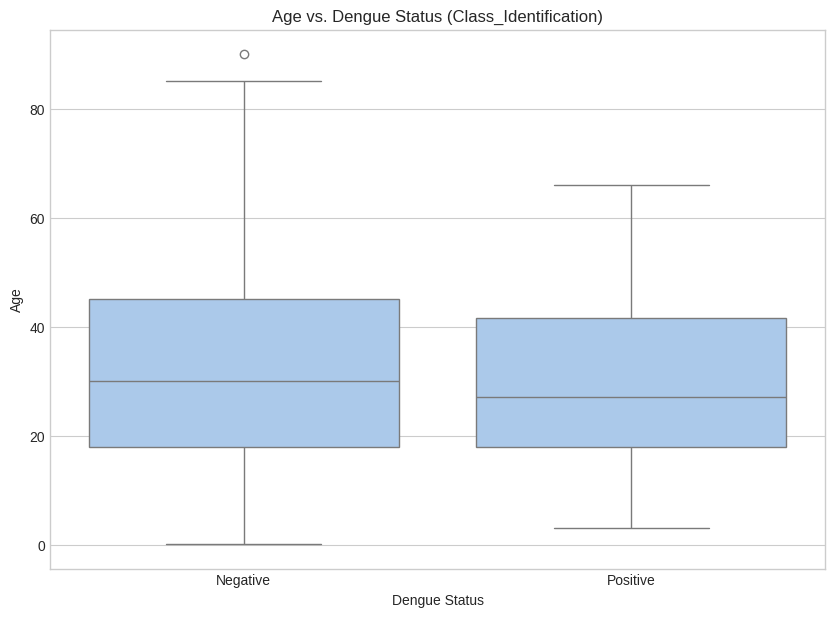

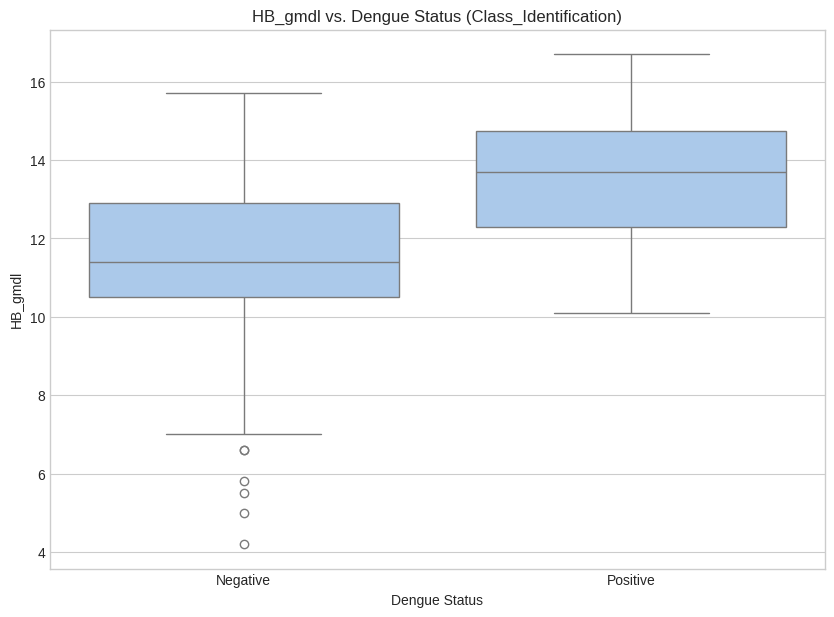

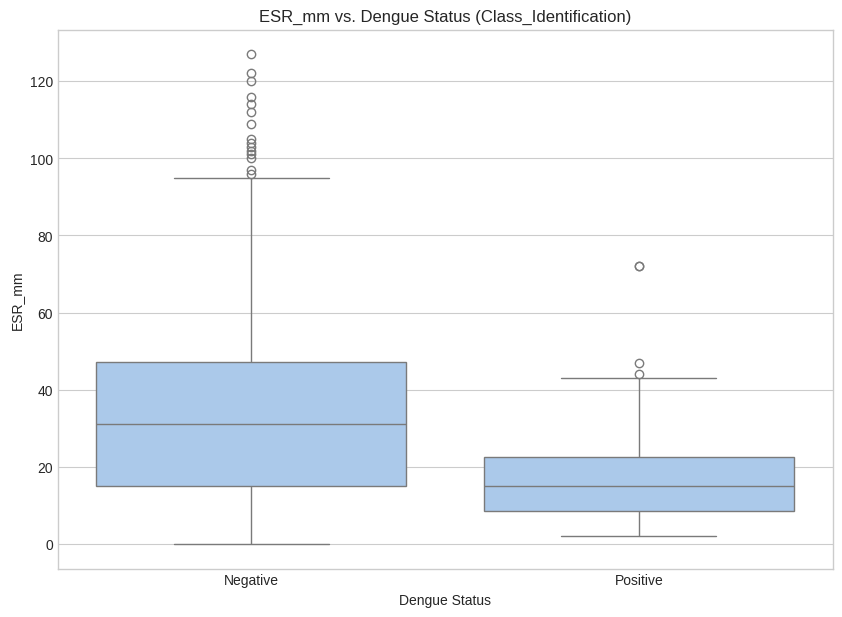

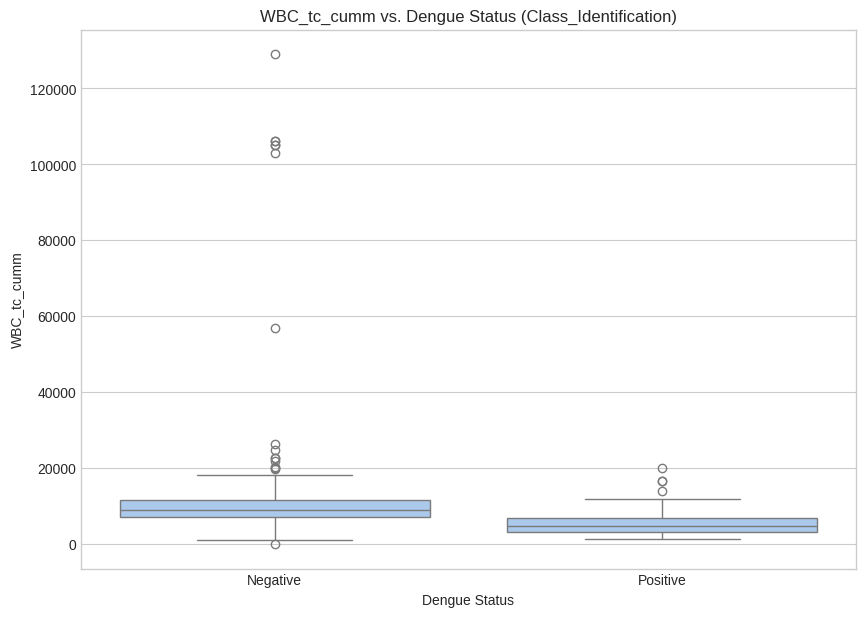

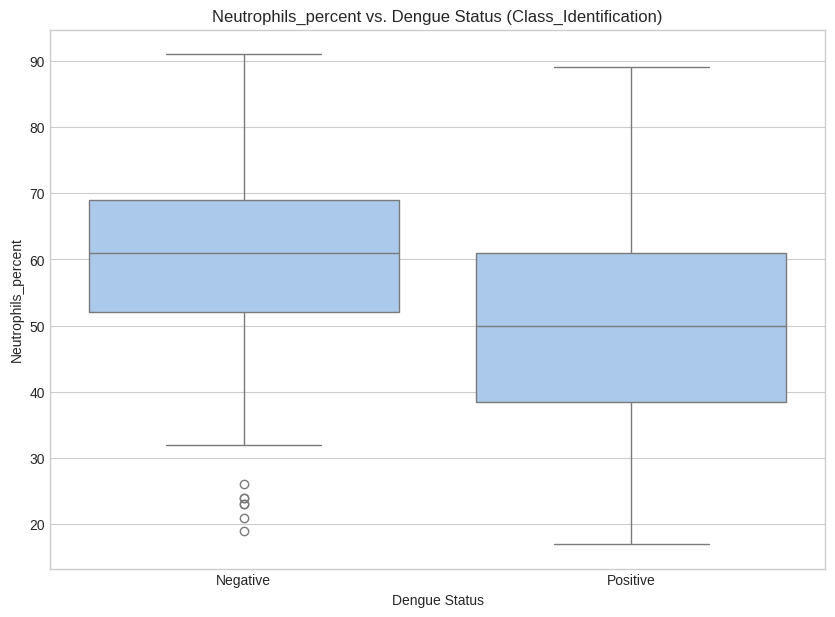

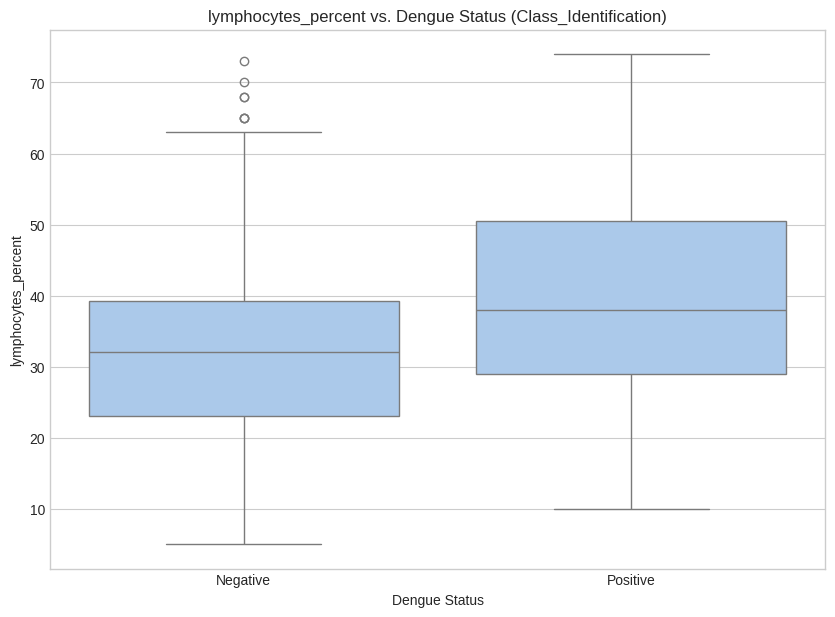

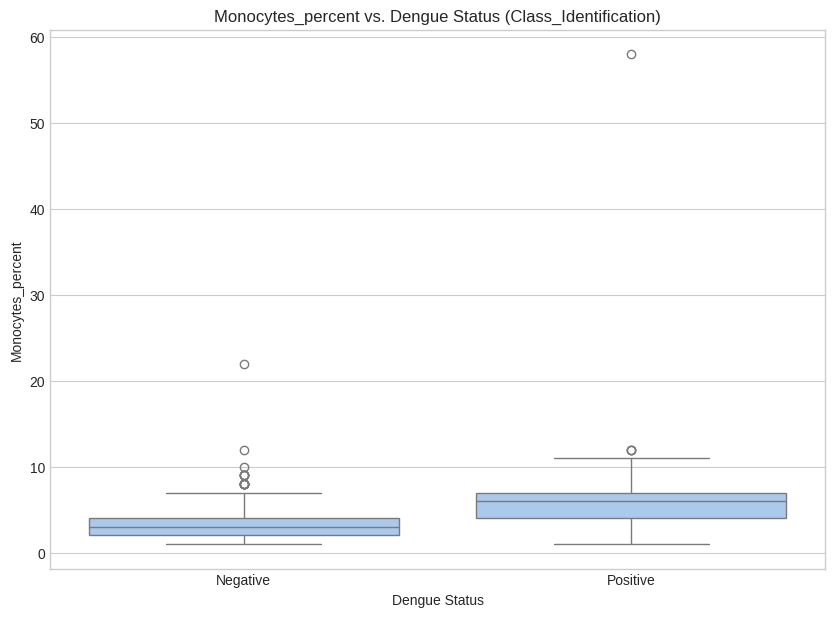

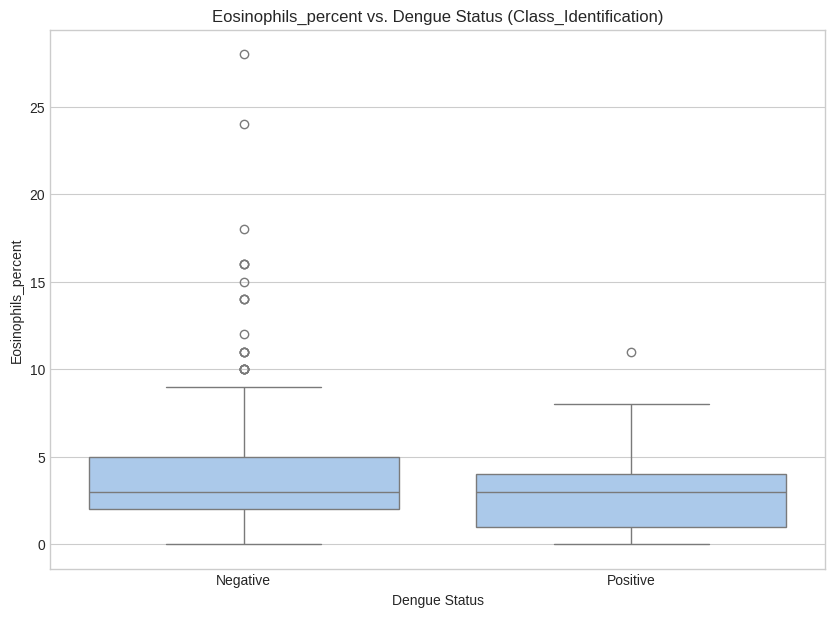

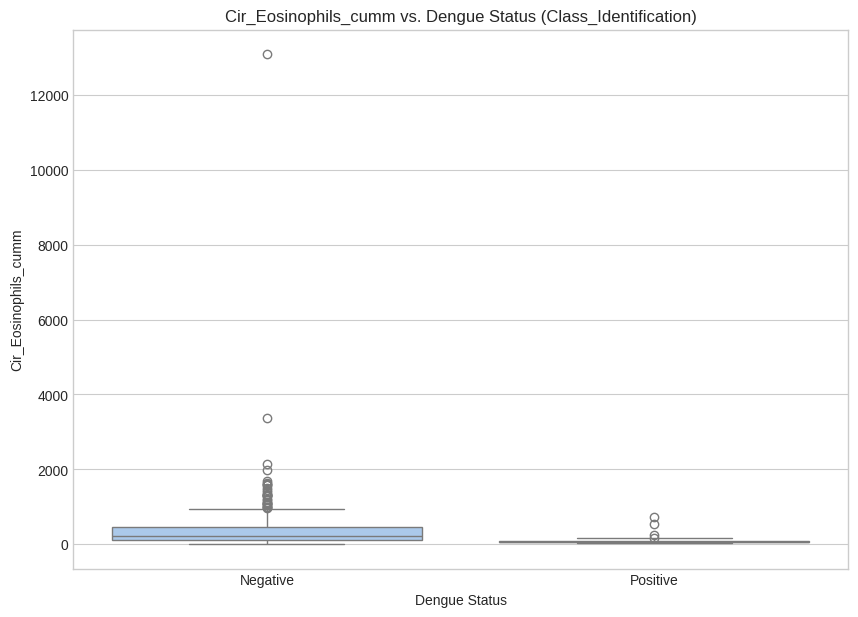

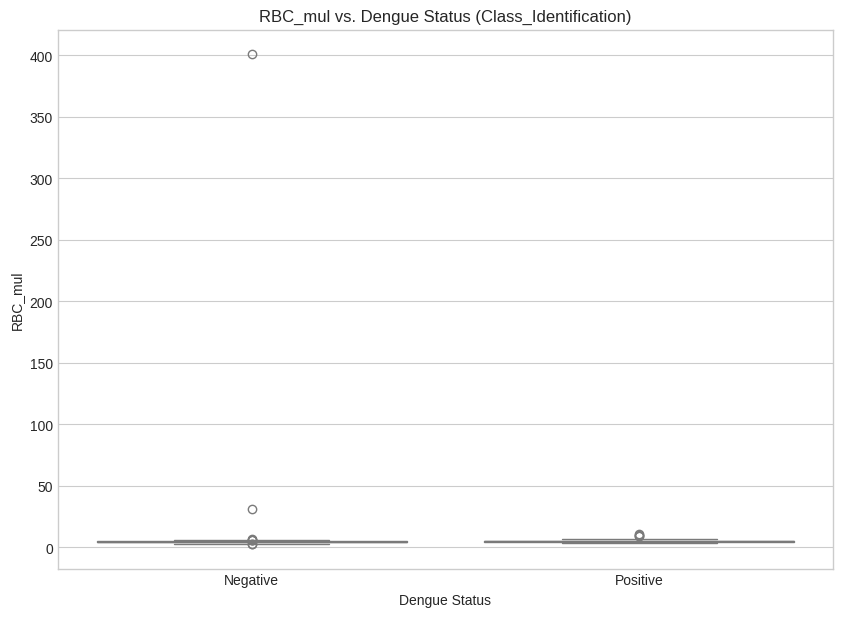

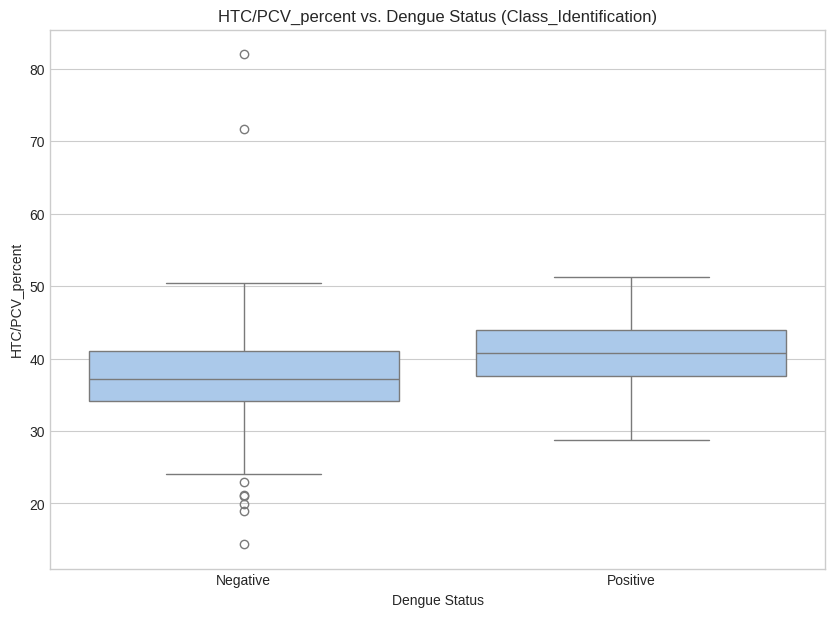

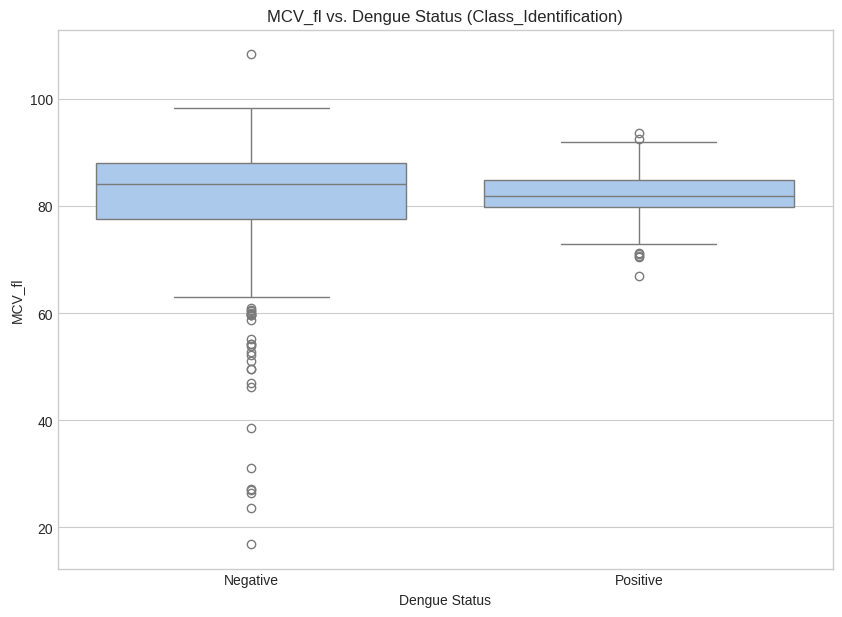

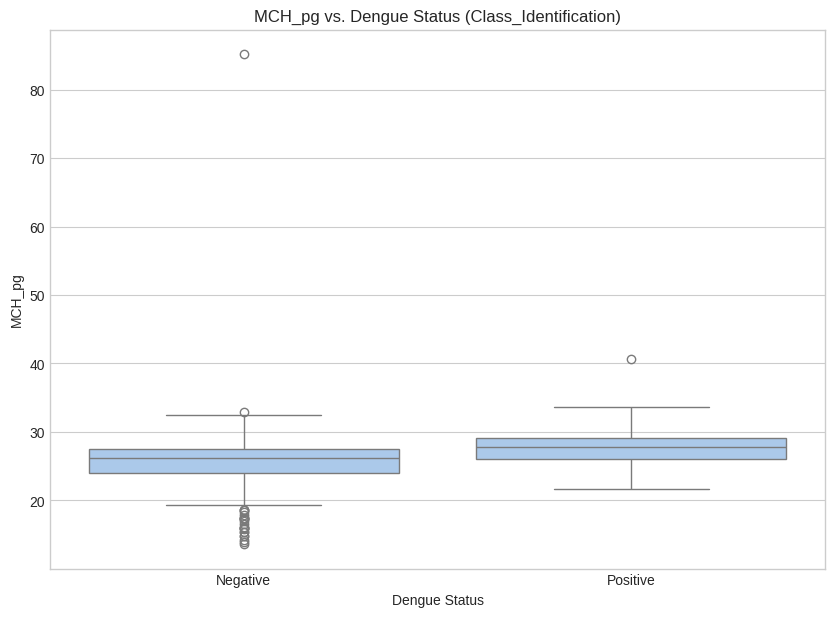

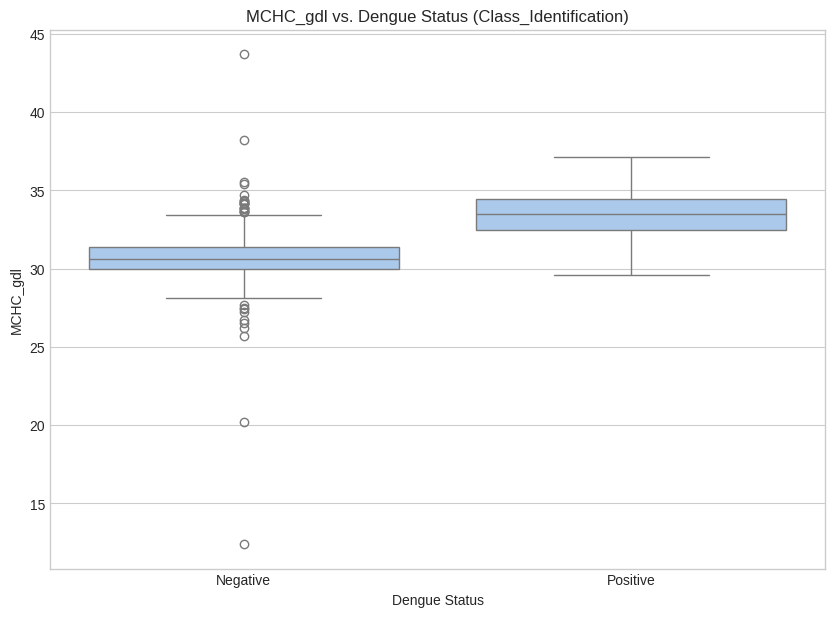

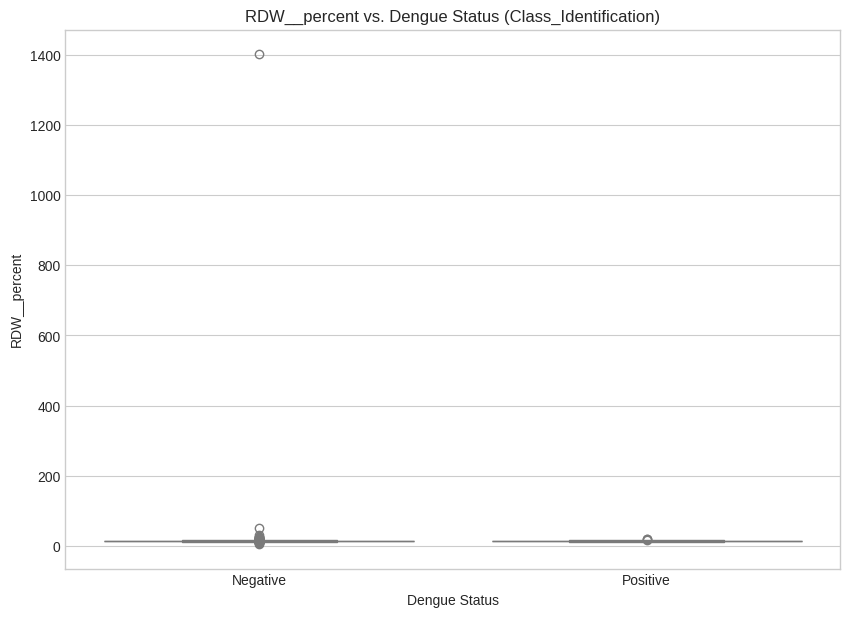

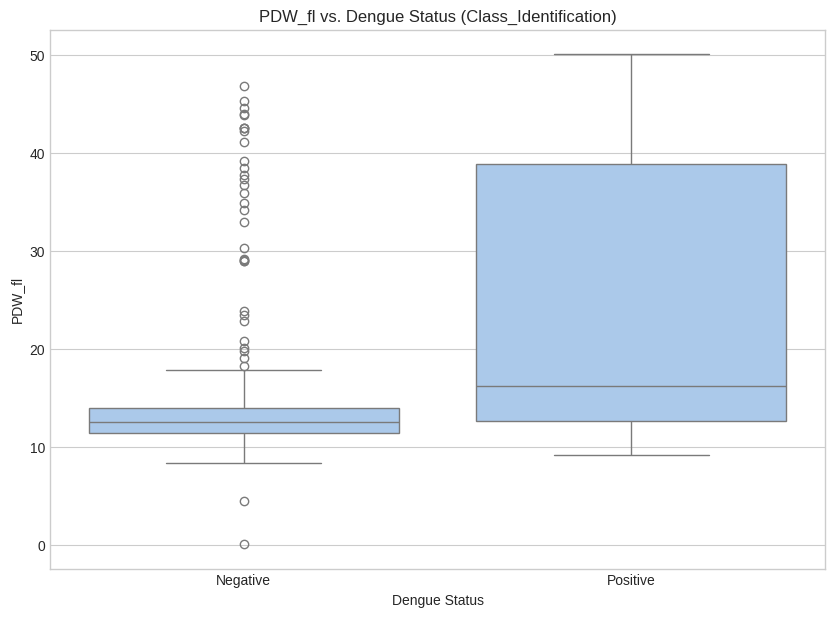

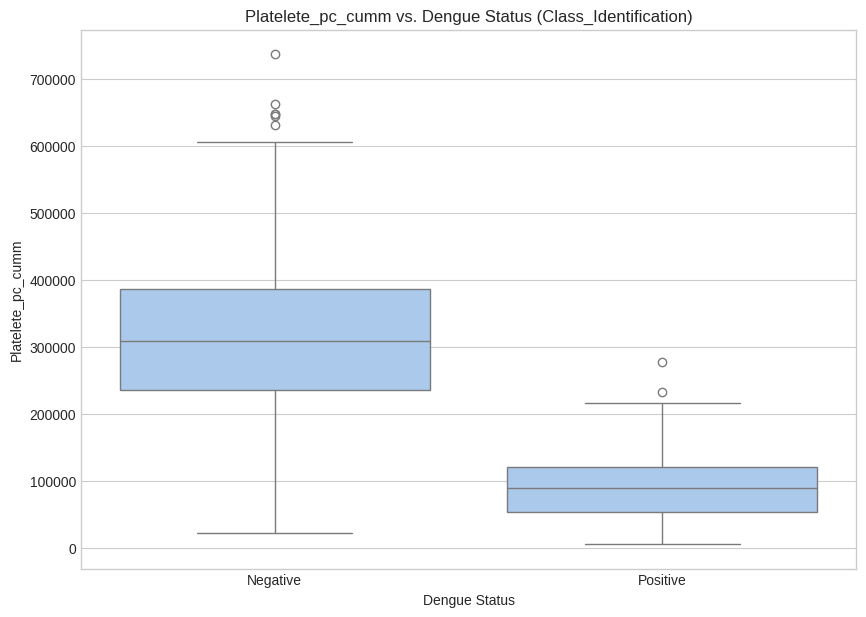

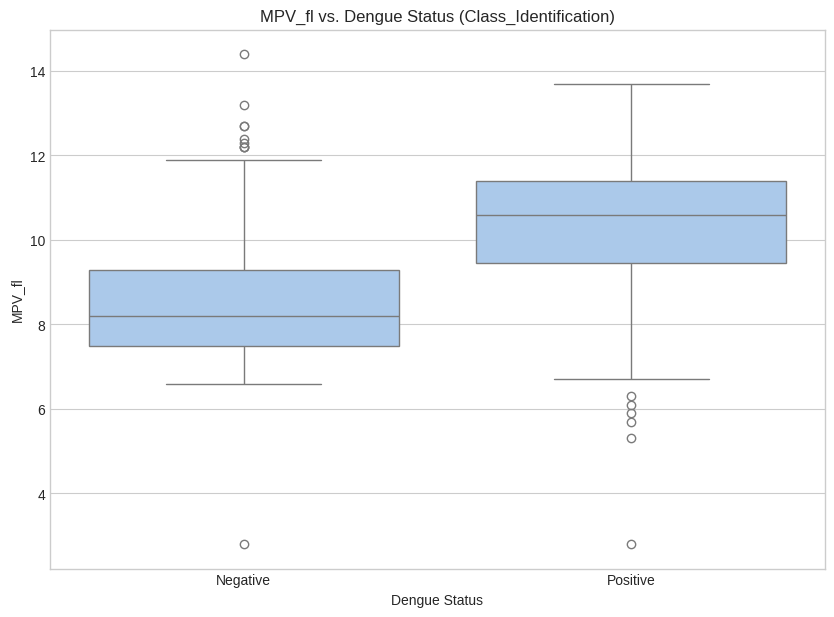

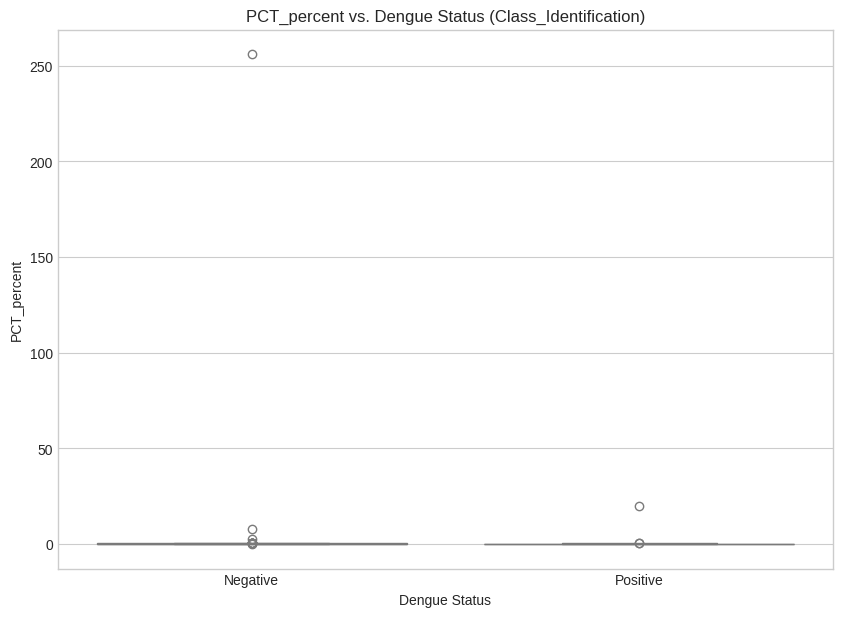

In [ ]:

print("\nBivariate Analysis: Numerical Features vs. Target Variable")
for col in numerical_features_eda:
    if col == target_column: continue
    plt.figure(figsize=(10, 7))
    sns.boxplot(x=target_column, y=col, data=df)
    plt.title(f'{col} vs. Dengue Status ({target_column})')
    try:
        plt.xticks(ticks=label_encoder_target.transform(label_encoder_target.classes_),
                   labels=label_encoder_target.classes_)
    except NameError:
        unique_targets = sorted(df[target_column].unique())
        if len(unique_targets) == 2: # Binary case
             plt.xticks(ticks=unique_targets, labels=[f'Class {int(u)}' for u in unique_targets])
    plt.xlabel('Dengue Status')
    plt.ylabel(col)
    plt.show()




## Correlation Matrix

### Correlation Heatmap --- Pairplot (With Target Variabl)

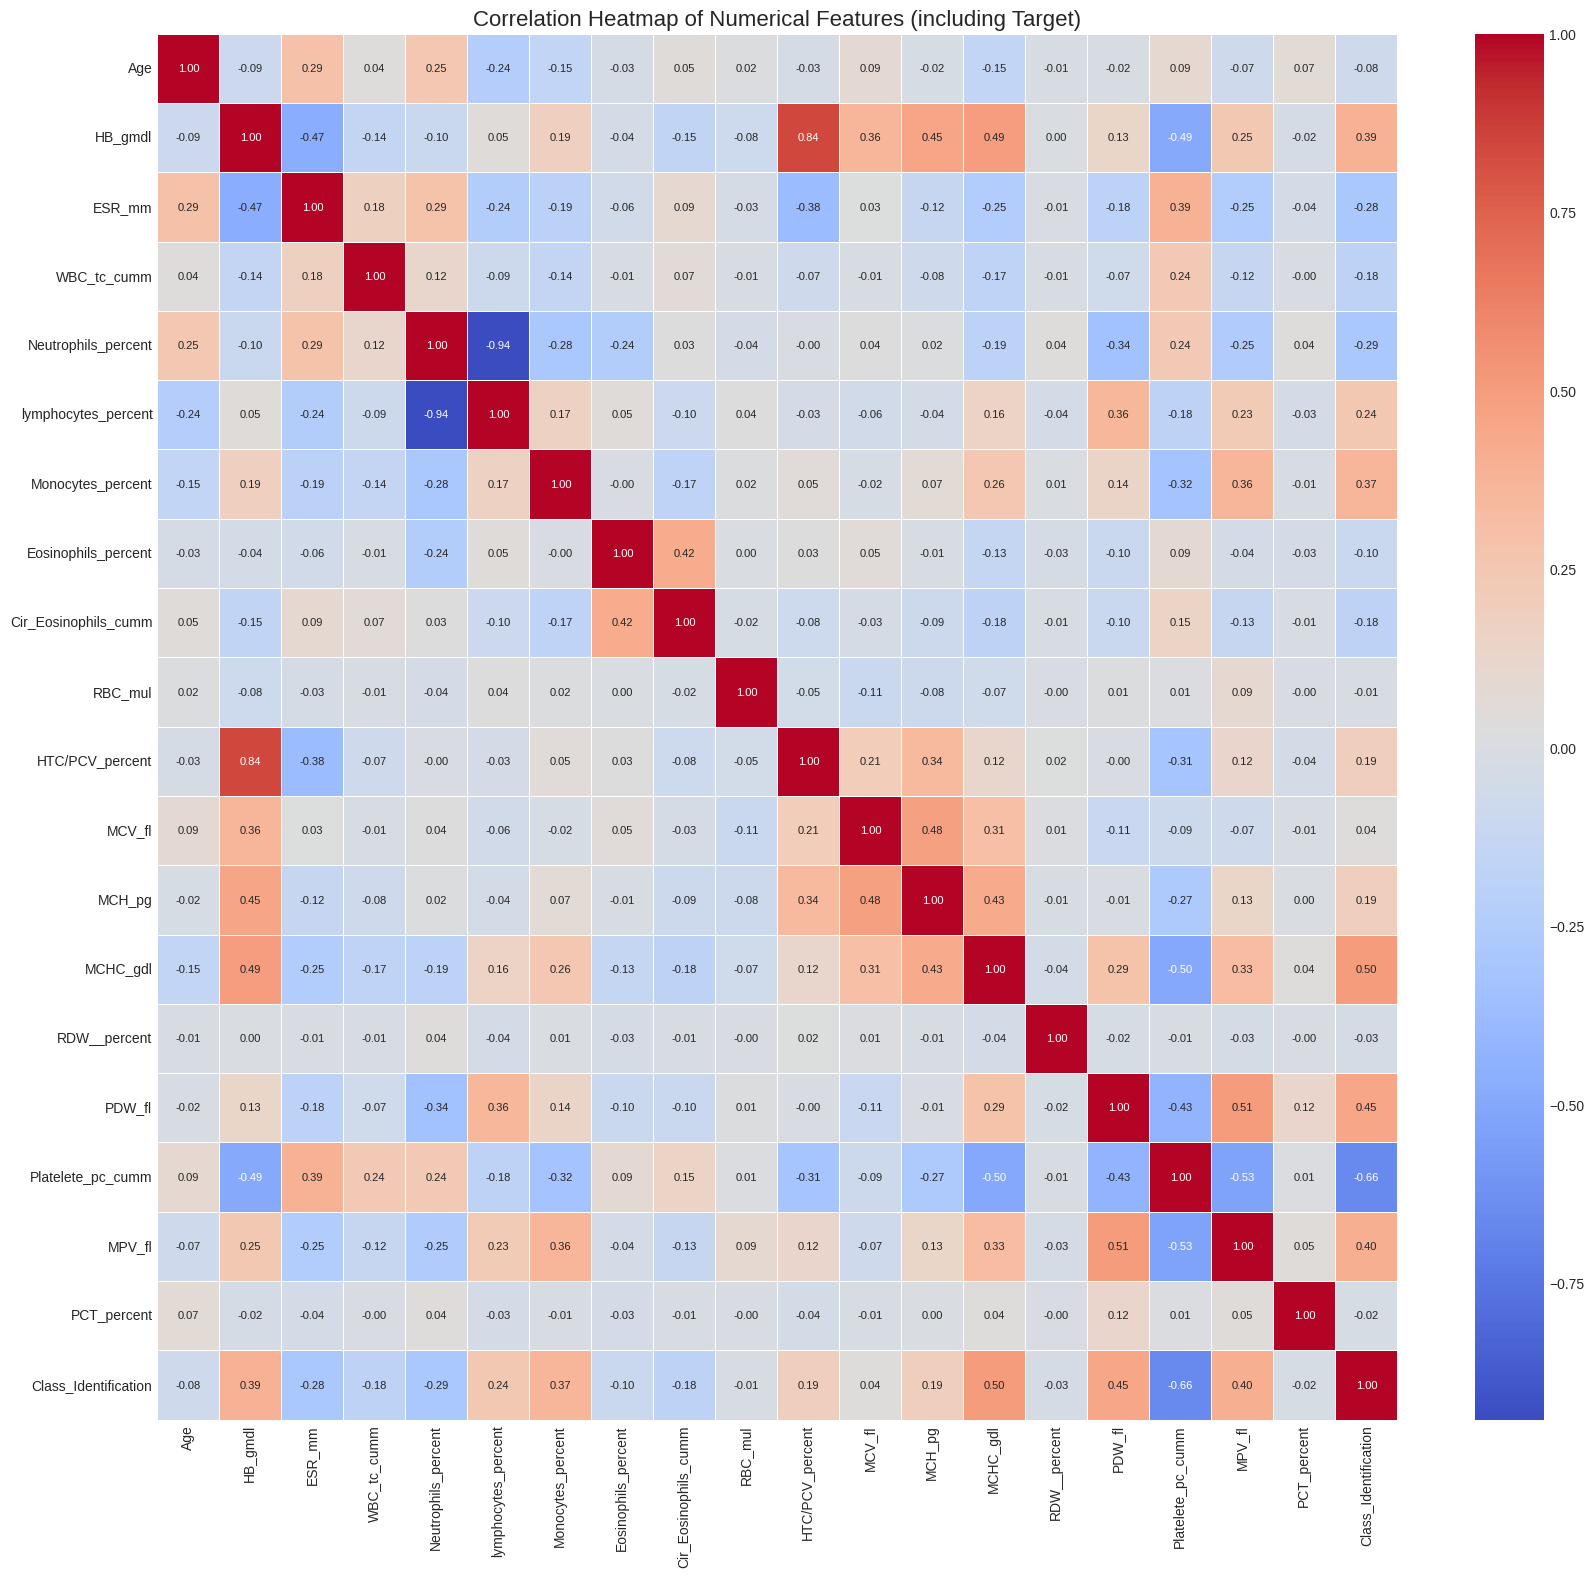


Correlation with Target Variable (Class_Identification):
Class_Identification    1.000000
MCHC_gdl                0.502812
PDW_fl                  0.451752
MPV_fl                  0.402111
HB_gmdl                 0.392304
Monocytes_percent       0.365504
lymphocytes_percent     0.243761
MCH_pg                  0.193627
HTC/PCV_percent         0.190733
MCV_fl                  0.037661
RBC_mul                -0.011130
PCT_percent            -0.020123
RDW__percent           -0.027144
Age                    -0.076373
Eosinophils_percent    -0.104694
Cir_Eosinophils_cumm   -0.178346
WBC_tc_cumm            -0.178882
ESR_mm                 -0.284327
Neutrophils_percent    -0.288983
Platelete_pc_cumm      -0.655093
Name: Class_Identification, dtype: float64

Pairplot for a subset of features:


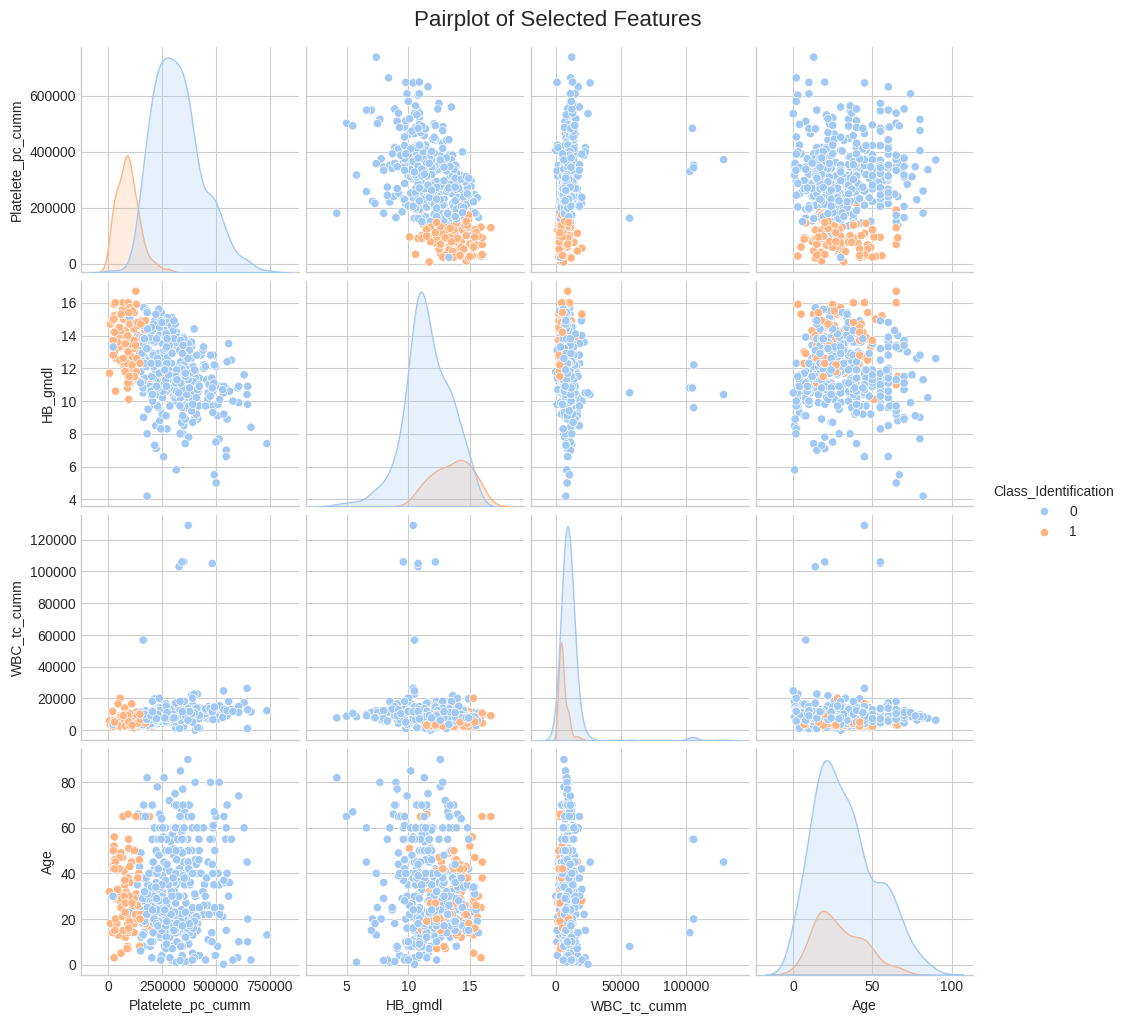

In [ ]:

numerical_cols_for_corr = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_cols_for_corr].corr()

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation Heatmap of Numerical Features (including Target)', fontsize=16)
plt.show()

if target_column in correlation_matrix.columns:
    print(f"\nCorrelation with Target Variable ({target_column}):")
    target_correlations = correlation_matrix[target_column].sort_values(ascending=False)
    print(target_correlations)
else:
    print(f"Target column '{target_column}' not found in correlation matrix columns for specific correlation display.")


subset_features_for_pairplot = ['Platelete_pc_cumm', 'HB_gmdl', 'WBC_tc_cumm', 'Age', target_column]

subset_features_for_pairplot = [col for col in subset_features_for_pairplot if col in df.columns]

if len(subset_features_for_pairplot) > 1:
    print("\nPairplot for a subset of features:")
    sns.pairplot(df[subset_features_for_pairplot], hue=target_column if target_column in subset_features_for_pairplot else None, diag_kind='kde')
    plt.suptitle('Pairplot of Selected Features', y=1.02, fontsize=16)
    plt.show()
else:
    print("\nNot enough columns for pairplot after checking existence.")



# Hypothesis Setting and Statistical Testing

In [ ]:
print("\n--- Starting Hypothesis Setting and Statistical Testing ---")


if target_column not in df.columns or not pd.api.types.is_numeric_dtype(df[target_column]):
    print(f"Error: Target column '{target_column}' is not suitable for statistical tests. Please check preprocessing.")

df_stat_tests = df.copy()


hypotheses_list = [
    {'feature': 'WBC_tc_cumm', 'test_type': 'ANOVA/t-test'},
    {'feature': 'Platelete_pc_cumm', 'test_type': 'ANOVA/t-test'},
    {'feature': 'HB_gmdl', 'test_type': 'ANOVA/t-test'},
    {'feature': 'Age', 'test_type': 'ANOVA/t-test'},
    {'feature': 'ESR_mm', 'test_type': 'ANOVA/t-test'},
    {'feature': 'MPV_fl', 'test_type': 'ANOVA/t-test'},
    {'feature': 'Neutrophils_percent', 'test_type': 'ANOVA/t-test'},
    {'feature': 'Lymphocytes_percent', 'test_type': 'ANOVA/t-test'}
]



--- Starting Hypothesis Setting and Statistical Testing ---


## Hypothesis Settings:

In [ ]:
print("\nDefined Hypotheses (General Form):")
for i, h in enumerate(hypotheses_list):
    print(f"Hypothesis {i+1} for feature '{h['feature']}':")
    print(f"  H₀ (Null Hypothesis): The mean of {h['feature']} is the same for both Positive and Negative Dengue classes.")
    print(f"  Hₐ (Alternative Hypothesis): The mean of {h['feature']} differs between Positive and Negative Dengue classes.")

alpha = 0.05


Defined Hypotheses (General Form):
Hypothesis 1 for feature 'WBC_tc_cumm':
  H₀ (Null Hypothesis): The mean of WBC_tc_cumm is the same for both Positive and Negative Dengue classes.
  Hₐ (Alternative Hypothesis): The mean of WBC_tc_cumm differs between Positive and Negative Dengue classes.
Hypothesis 2 for feature 'Platelete_pc_cumm':
  H₀ (Null Hypothesis): The mean of Platelete_pc_cumm is the same for both Positive and Negative Dengue classes.
  Hₐ (Alternative Hypothesis): The mean of Platelete_pc_cumm differs between Positive and Negative Dengue classes.
Hypothesis 3 for feature 'HB_gmdl':
  H₀ (Null Hypothesis): The mean of HB_gmdl is the same for both Positive and Negative Dengue classes.
  Hₐ (Alternative Hypothesis): The mean of HB_gmdl differs between Positive and Negative Dengue classes.
Hypothesis 4 for feature 'Age':
  H₀ (Null Hypothesis): The mean of Age is the same for both Positive and Negative Dengue classes.
  Hₐ (Alternative Hypothesis): The mean of Age differs betw

## ANOVA TESTS

In [ ]:
# --- ANOVA Tests ---
alpha = 0.05
print("\n--- ANOVA Tests ---")
anova_features_to_test = ['WBC_tc_cumm', 'Platelete_pc_cumm', 'HB_gmdl', 'Age', 'ESR_mm']
anova_features_to_test = [f for f in anova_features_to_test if f in df_stat_tests.columns]
for feature_name in anova_features_to_test:

    if not pd.api.types.is_numeric_dtype(df_stat_tests[feature_name]):
        print(f"Skipping ANOVA for non-numeric feature: {feature_name}")
        continue


    df_test_subset = df_stat_tests[[feature_name, target_column]].dropna()

    if df_test_subset[target_column].nunique() < 2:
        print(f"Skipping ANOVA for {feature_name}: Target variable has less than 2 unique groups after NaN drop.")
        continue
    if len(df_test_subset) < 10:
        print(f"Skipping ANOVA for {feature_name}: Not enough data points after NaN drop.")
        continue


    print(f"\nANOVA Test for: {feature_name}")
    print(f"H₀: The mean of {feature_name} is the same across Dengue classes.")
    print(f"Hₐ: The mean of {feature_name} differs across Dengue classes.")

    formula = f'{feature_name} ~ C({target_column})'
    try:
        model_anova = ols(formula, data=df_test_subset).fit()
        anova_table = anova_lm(model_anova, typ=2)
        print("ANOVA Table:")
        print(anova_table)

        p_value_anova = anova_table['PR(>F)'][0]
        f_value_anova = anova_table['F'][0]
        print(f"F-statistic: {f_value_anova:.4f}, P-value: {p_value_anova:.4g}")

        if p_value_anova < alpha:
            print(f"Conclusion: Reject H₀. The difference in means for {feature_name} is statistically significant (p < {alpha}).")
        else:
            print(f"Conclusion: Fail to reject H₀. The difference in means for {feature_name} is not statistically significant (p >= {alpha}).")
    except Exception as e:
        print(f"An error occurred during ANOVA for {feature_name}: {e}")




--- ANOVA Tests ---

ANOVA Test for: WBC_tc_cumm
H₀: The mean of WBC_tc_cumm is the same across Dengue classes.
Hₐ: The mean of WBC_tc_cumm differs across Dengue classes.
ANOVA Table:
                               sum_sq     df          F    PR(>F)
C(Class_Identification)  2.238298e+09    1.0  16.429013  0.000059
Residual                 6.771157e+10  497.0        NaN       NaN
F-statistic: 16.4290, P-value: 5.861e-05
Conclusion: Reject H₀. The difference in means for WBC_tc_cumm is statistically significant (p < 0.05).

ANOVA Test for: Platelete_pc_cumm
H₀: The mean of Platelete_pc_cumm is the same across Dengue classes.
Hₐ: The mean of Platelete_pc_cumm differs across Dengue classes.
ANOVA Table:
                               sum_sq     df           F        PR(>F)
C(Class_Identification)  4.120724e+12    1.0  373.627287  1.707389e-62
Residual                 5.481397e+12  497.0         NaN           NaN
F-statistic: 373.6273, P-value: 1.707e-62
Conclusion: Reject H₀. The differen

<ipython-input-26-cbefb57f14f4>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_anova = anova_table['PR(>F)'][0]
<ipython-input-26-cbefb57f14f4>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value_anova = anova_table['F'][0]
<ipython-input-26-cbefb57f14f4>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_anova = anova_table['PR(>F)'][0]
<ipython-input-26-cbefb57f14f4>:36: FutureWarning: Series.__getitem__ tr

ANOVA Table:
                              sum_sq     df          F        PR(>F)
C(Class_Identification)   302.179693    1.0  90.402875  8.302520e-20
Residual                 1661.266940  497.0        NaN           NaN
F-statistic: 90.4029, P-value: 8.303e-20
Conclusion: Reject H₀. The difference in means for HB_gmdl is statistically significant (p < 0.05).

ANOVA Test for: Age
H₀: The mean of Age is the same across Dengue classes.
Hₐ: The mean of Age differs across Dengue classes.
ANOVA Table:
                                sum_sq     df         F    PR(>F)
C(Class_Identification)    1011.400549    1.0  2.915904  0.088335
Residual                 172387.710193  497.0       NaN       NaN
F-statistic: 2.9159, P-value: 0.08833
Conclusion: Fail to reject H₀. The difference in means for Age is not statistically significant (p >= 0.05).

ANOVA Test for: ESR_mm
H₀: The mean of ESR_mm is the same across Dengue classes.
Hₐ: The mean of ESR_mm differs across Dengue classes.
ANOVA Table:
     

<ipython-input-26-cbefb57f14f4>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_anova = anova_table['PR(>F)'][0]
<ipython-input-26-cbefb57f14f4>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value_anova = anova_table['F'][0]


## STUDENT T TEST ( Independent Two Sample )

In [ ]:
# --- Student's t-tests / Welch's t-tests (Independent two-sample) ---
print("\n--- Independent Two-Sample t-tests (Welch's t-test if variances unequal) ---")
ttest_features_to_test = ['MPV_fl', 'Neutrophils_percent', 'Lymphocytes_percent', 'Platelete_pc_cumm'] # Example
ttest_features_to_test = [f for f in ttest_features_to_test if f in df_stat_tests.columns]

for feature_name in ttest_features_to_test:
    if not pd.api.types.is_numeric_dtype(df_stat_tests[feature_name]):
        print(f"Skipping t-test for non-numeric feature: {feature_name}")
        continue

    df_test_subset = df_stat_tests[[feature_name, target_column]].dropna()
    group1 = df_test_subset[df_test_subset[target_column] == 0][feature_name] #
    group2 = df_test_subset[df_test_subset[target_column] == 1][feature_name] #

    if len(group1) < 2 or len(group2) < 2:
        print(f"Skipping t-test for {feature_name}: Not enough data in one or both groups after NaN drop.")
        continue

    print(f"\nT-test for: {feature_name}")
    print(f"H₀: The mean of {feature_name} is the same for both Positive and Negative Dengue classes.")
    print(f"Hₐ: The mean of {feature_name} differs between Positive and Negative Dengue classes.")

    # Check for variance equality (Levene's test)
    levene_stat, levene_p = stats.levene(group1, group2)
    equal_var_flag = levene_p > alpha # If p > alpha, assume equal variances
    print(f"Levene's test for equal variances: p-value = {levene_p:.4g}. Equal variances assumed: {equal_var_flag}")

    t_stat, p_value_ttest = stats.ttest_ind(group1, group2, equal_var=equal_var_flag, nan_policy='omit')
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value_ttest:.4g}")

    if p_value_ttest < alpha:
        print(f"Conclusion: Reject H₀. The difference in means for {feature_name} is statistically significant (p < {alpha}).")
    else:
        print(f"Conclusion: Fail to reject H₀. The difference in means for {feature_name} is not statistically significant (p >= {alpha}).")



--- Independent Two-Sample t-tests (Welch's t-test if variances unequal) ---

T-test for: MPV_fl
H₀: The mean of MPV_fl is the same for both Positive and Negative Dengue classes.
Hₐ: The mean of MPV_fl differs between Positive and Negative Dengue classes.
Levene's test for equal variances: p-value = 0.02009. Equal variances assumed: False
T-statistic: -8.1713, P-value: 3.63e-13
Conclusion: Reject H₀. The difference in means for MPV_fl is statistically significant (p < 0.05).

T-test for: Neutrophils_percent
H₀: The mean of Neutrophils_percent is the same for both Positive and Negative Dengue classes.
Hₐ: The mean of Neutrophils_percent differs between Positive and Negative Dengue classes.
Levene's test for equal variances: p-value = 0.04539. Equal variances assumed: False
T-statistic: 6.2508, P-value: 5.324e-09
Conclusion: Reject H₀. The difference in means for Neutrophils_percent is statistically significant (p < 0.05).

T-test for: Platelete_pc_cumm
H₀: The mean of Platelete_pc_cumm

## Z-Test

In [ ]:

print("\n--- Z-test (Example) ---")
ztest_feature = 'WBC_tc_cumm'
if ztest_feature in df_stat_tests.columns and pd.api.types.is_numeric_dtype(df_stat_tests[ztest_feature]):
    df_test_subset_z = df_stat_tests[[ztest_feature, target_column]].dropna()
    group1_z = df_test_subset_z[df_test_subset_z[target_column] == 0][ztest_feature]
    group2_z = df_test_subset_z[df_test_subset_z[target_column] == 1][ztest_feature]

    if len(group1_z) > 30 and len(group2_z) > 30:
        print(f"\nZ-test for: {ztest_feature}")
        print(f"H₀: The mean of {ztest_feature} is the same for both Positive and Negative Dengue classes.")
        print(f"Hₐ: The mean of {ztest_feature} differs between Positive and Negative Dengue classes.")

        z_stat_sm, p_value_z_sm = ztest(group1_z, group2_z, value=0)
        print(f"Z-statistic: {z_stat_sm:.4f}, P-value: {p_value_z_sm:.4g}")

        if p_value_z_sm < alpha:
            print(f"Conclusion: Reject H₀. The difference in means for {ztest_feature} is statistically significant (p < {alpha}).")
        else:
            print(f"Conclusion: Fail to reject H₀. The difference in means for {ztest_feature} is not statistically significant (p >= {alpha}).")
    else:
        print(f"Skipping Z-test for {ztest_feature}: Sample sizes may not be large enough ({len(group1_z)}, {len(group2_z)}).")
else:
    print(f"Skipping Z-test: Feature '{ztest_feature}' not found or not numeric.")




--- Z-test (Example) ---

Z-test for: WBC_tc_cumm
H₀: The mean of WBC_tc_cumm is the same for both Positive and Negative Dengue classes.
Hₐ: The mean of WBC_tc_cumm differs between Positive and Negative Dengue classes.
Z-statistic: 4.0533, P-value: 5.051e-05
Conclusion: Reject H₀. The difference in means for WBC_tc_cumm is statistically significant (p < 0.05).


# Feature Engineering

## Low Platelate Endicator

In [ ]:
print("\n--- Starting Feature Engineering ---")
df_fe = df.copy()
platelet_col_name = 'Platelete_pc_cumm'
if platelet_col_name in df_fe.columns:
    df_fe['Low_Platelets_Indicator'] = (df_fe[platelet_col_name] < 150000).astype(int)
    print("Created Low_Platelets_Indicator feature (1 if < 150,000, else 0).")

else:
    print(f"Could not create Low_Platelets_Indicator: Column '{platelet_col_name}' not found.")


--- Starting Feature Engineering ---
Created Low_Platelets_Indicator feature (1 if < 150,000, else 0).


## Age Grouping

In [ ]:

if 'Age' in df_fe.columns:
    bins = [0, 12, 18, 35, 60, 120] # Example bins: Child, Adolescent, Young Adult, Adult, Senior
    labels = ['Child', 'Adolescent', 'Young_Adult', 'Adult', 'Senior']
    df_fe['Age_Group'] = pd.cut(df_fe['Age'], bins=bins, labels=labels, right=False)
    print("Created Age_Group feature.")

    if 'Age_Group' not in categorical_cols and 'Age_Group' in df_fe.columns:
        categorical_cols.append('Age_Group')
    print(df_fe['Age_Group'].value_counts())
else:
    print("Could not create Age_Group: 'Age' column missing.")


Created Age_Group feature.
Age_Group
Young_Adult    174
Adult          148
Adolescent      66
Senior          59
Child           52
Name: count, dtype: int64


## Visualizing Data after FE

In [ ]:

print("\nDataFrame head after Feature Engineering:")
print(df_fe.head())


numerical_cols_fe = df_fe.select_dtypes(include=np.number).columns.tolist()
categorical_cols_fe = df_fe.select_dtypes(exclude=np.number).columns.tolist()
if target_column in numerical_cols_fe: numerical_cols_fe.remove(target_column)
if target_column in categorical_cols_fe: categorical_cols_fe.remove(target_column)

print(f"\nNumerical columns after FE: {numerical_cols_fe}")
print(f"Categorical columns after FE: {categorical_cols_fe}")


DataFrame head after Feature Engineering:
    Age  HB_gmdl  ESR_mm  WBC_tc_cumm  Neutrophils_percent  \
0  14.0     11.4    28.0       4200.0                 57.0   
1  26.0     12.2    43.0       4700.0                 77.0   
2  42.0     14.9   103.0      19800.0                 82.0   
3  35.0     13.9    12.0       9700.0                 88.0   
4   8.0     10.0    28.0      10600.0                 46.0   

   lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
0                 36.0                5.0                  2.0   
1                 19.0                3.0                  1.0   
2                 15.0                2.0                  1.0   
3                 10.0                1.0                  1.0   
4                 42.0                2.0                 10.0   

   Cir_Eosinophils_cumm  RBC_mul  ...  MCH_pg  MCHC_gdl  RDW__percent  PDW_fl  \
0                  84.0     4.64  ...    24.6      30.8          15.5    20.1   
1                  47.0  

In [ ]:
df_fe.head()

Age  HB_gmdl  ESR_mm  WBC_tc_cumm  Neutrophils_percent  \
0  14.0     11.4    28.0       4200.0                 57.0   
1  26.0     12.2    43.0       4700.0                 77.0   
2  42.0     14.9   103.0      19800.0                 82.0   
3  35.0     13.9    12.0       9700.0                 88.0   
4   8.0     10.0    28.0      10600.0                 46.0   

   lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
0                 36.0                5.0                  2.0   
1                 19.0                3.0                  1.0   
2                 15.0                2.0                  1.0   
3                 10.0                1.0                  1.0   
4                 42.0                2.0                 10.0   

   Cir_Eosinophils_cumm  RBC_mul  ...  MCH_pg  MCHC_gdl  RDW__percent  PDW_fl  \
0                  84.0     4.64  ...    24.6      30.8          15.5    20.1   
1                  47.0     4.24  ...    28.8      30.8          14.3    12.9   
2                 198.0     5.31  ...    28.1      30.8          13.7    12.7   
3                  97.0     5.49  ...    25.3      30.8          14.1    12.7   
4                1060.0     3.99  ...    25.1      30.8          13.7    11.5   

   Platelete_pc_cumm  MPV_fl  PCT_percent  Class_Identification  \
0           167000.0    10.3         0.07                     0   
1           277000.0     8.5         0.24                     1   
2           215000.0     9.1         0.20                     0   
3           282000.0     8.7         0.25                     0   
4           337000.0     7.6         0.26                     0   

   Low_Platelets_Indicator    Age_Group  
0                        0   Adolescent  
1                        0  Young_Adult  
2                        0        Adult  
3                        0        Adult  
4                        0        Child  

[5 rows x 22 columns]

# Model Preparation ( Splitting , Encoding Categorical Features , Scaling)

## One Hot Encoding (Categorical Columns)

In [ ]:
print("\n--- Starting Model Preparation ---")
df_model_ready = df_fe.copy()


if 'Age_Group' in categorical_cols_fe:
    print("\nOne-Hot Encoding 'Age_Group' (and any other specified categorical features)...")
    df_model_ready = pd.get_dummies(df_model_ready, columns=['Age_Group'], prefix='AgeGrp', dummy_na=False)

    print("Columns after One-Hot Encoding 'Age_Group':")
    print(df_model_ready.columns)
else:
    print("\nNo new categorical features like 'Age_Group' found to one-hot encode from categorical_cols_fe list.")



--- Starting Model Preparation ---

One-Hot Encoding 'Age_Group' (and any other specified categorical features)...
Columns after One-Hot Encoding 'Age_Group':
Index(['Age', 'HB_gmdl', 'ESR_mm', 'WBC_tc_cumm', 'Neutrophils_percent',
       'lymphocytes_percent', 'Monocytes_percent', 'Eosinophils_percent',
       'Cir_Eosinophils_cumm', 'RBC_mul', 'HTC/PCV_percent', 'MCV_fl',
       'MCH_pg', 'MCHC_gdl', 'RDW__percent', 'PDW_fl', 'Platelete_pc_cumm',
       'MPV_fl', 'PCT_percent', 'Class_Identification',
       'Low_Platelets_Indicator', 'AgeGrp_Child', 'AgeGrp_Adolescent',
       'AgeGrp_Young_Adult', 'AgeGrp_Adult', 'AgeGrp_Senior'],
      dtype='object')


## Defining Features and Target

In [ ]:

if target_column not in df_model_ready.columns:
    print(f"CRITICAL ERROR: Target column '{target_column}' is missing from the DataFrame before splitting.")

X = df_model_ready.drop(target_column, axis=1)
y = df_model_ready[target_column]

In [ ]:
df_model_ready.head()

Age  HB_gmdl  ESR_mm  WBC_tc_cumm  Neutrophils_percent  \
0  14.0     11.4    28.0       4200.0                 57.0   
1  26.0     12.2    43.0       4700.0                 77.0   
2  42.0     14.9   103.0      19800.0                 82.0   
3  35.0     13.9    12.0       9700.0                 88.0   
4   8.0     10.0    28.0      10600.0                 46.0   

   lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
0                 36.0                5.0                  2.0   
1                 19.0                3.0                  1.0   
2                 15.0                2.0                  1.0   
3                 10.0                1.0                  1.0   
4                 42.0                2.0                 10.0   

   Cir_Eosinophils_cumm  RBC_mul  ...  Platelete_pc_cumm  MPV_fl  PCT_percent  \
0                  84.0     4.64  ...           167000.0    10.3         0.07   
1                  47.0     4.24  ...           277000.0     8.5         0.24   
2                 198.0     5.31  ...           215000.0     9.1         0.20   
3                  97.0     5.49  ...           282000.0     8.7         0.25   
4                1060.0     3.99  ...           337000.0     7.6         0.26   

   Class_Identification  Low_Platelets_Indicator  AgeGrp_Child  \
0                     0                        0         False   
1                     1                        0         False   
2                     0                        0         False   
3                     0                        0         False   
4                     0                        0          True   

   AgeGrp_Adolescent  AgeGrp_Young_Adult  AgeGrp_Adult  AgeGrp_Senior  
0               True               False         False          False  
1              False                True         False          False  
2              False               False          True          False  
3              False               False          True          False  
4              False               False         False          False  

[5 rows x 26 columns]

In [ ]:

X_non_numeric_check = X.select_dtypes(exclude=np.number).columns
if not X_non_numeric_check.empty:
    print(f"Warning: Non-numeric columns found in X: {X_non_numeric_check.tolist()}. Attempting to drop them.")
    X = X.select_dtypes(include=np.number)
    print("Kept only numeric columns in X.")
else:
    print("All columns in X are numeric.")

Kept only numeric columns in X.


In [ ]:
df_fe.head()

Age  HB_gmdl  ESR_mm  WBC_tc_cumm  Neutrophils_percent  \
0  14.0     11.4    28.0       4200.0                 57.0   
1  26.0     12.2    43.0       4700.0                 77.0   
2  42.0     14.9   103.0      19800.0                 82.0   
3  35.0     13.9    12.0       9700.0                 88.0   
4   8.0     10.0    28.0      10600.0                 46.0   

   lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
0                 36.0                5.0                  2.0   
1                 19.0                3.0                  1.0   
2                 15.0                2.0                  1.0   
3                 10.0                1.0                  1.0   
4                 42.0                2.0                 10.0   

   Cir_Eosinophils_cumm  RBC_mul  ...  MCH_pg  MCHC_gdl  RDW__percent  PDW_fl  \
0                  84.0     4.64  ...    24.6      30.8          15.5    20.1   
1                  47.0     4.24  ...    28.8      30.8          14.3    12.9   
2                 198.0     5.31  ...    28.1      30.8          13.7    12.7   
3                  97.0     5.49  ...    25.3      30.8          14.1    12.7   
4                1060.0     3.99  ...    25.1      30.8          13.7    11.5   

   Platelete_pc_cumm  MPV_fl  PCT_percent  Class_Identification  \
0           167000.0    10.3         0.07                     0   
1           277000.0     8.5         0.24                     1   
2           215000.0     9.1         0.20                     0   
3           282000.0     8.7         0.25                     0   
4           337000.0     7.6         0.26                     0   

   Low_Platelets_Indicator    Age_Group  
0                        0   Adolescent  
1                        0  Young_Adult  
2                        0        Adult  
3                        0        Adult  
4                        0        Child  

[5 rows x 22 columns]

## Train Test Split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"\nTraining set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")



Training set shape: X_train: (374, 20), y_train: (374,)
Test set shape: X_test: (125, 20), y_test: (125,)
Training target distribution:
Class_Identification
0    0.81016
1    0.18984
Name: proportion, dtype: float64
Test target distribution:
Class_Identification
0    0.808
1    0.192
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Example model
model = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train, y_train)


print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       101
           1       0.92      0.96      0.94        24

    accuracy                           0.98       125
   macro avg       0.96      0.97      0.96       125
weighted avg       0.98      0.98      0.98       125



## Feature Scaling (Standard Scaler)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd


if isinstance(X_train, pd.DataFrame):
    cols_to_scale = [col for col in X_train.columns if X_train[col].nunique() > 2]
else:
    cols_to_scale = list(range(X_train.shape[1]))

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if cols_to_scale:
    if isinstance(X_train, pd.DataFrame):
        X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
        X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
    else:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

    print(f"\nFeatures scaled using StandardScaler: {cols_to_scale}")
else:
    print("\nNo columns identified for scaling (or all are binary). Using unscaled data.")


print("\nFirst 5 rows of scaled X_train (or original X_train if no scaling):")
if isinstance(X_train_scaled, pd.DataFrame):
    print(X_train_scaled.head())
else:
    print(X_train_scaled[:5])


best_model = grid_search.best_estimator_


best_model.fit(X_train_scaled, y_train)


accuracy = best_model.score(X_test_scaled, y_test)
print(f"\nAccuracy of the retrained best model on the scaled test set: {accuracy:.4f}")



Features scaled using StandardScaler: ['Age', 'HB_gmdl', 'ESR_mm', 'WBC_tc_cumm', 'Neutrophils_percent', 'lymphocytes_percent', 'Monocytes_percent', 'Eosinophils_percent', 'Cir_Eosinophils_cumm', 'RBC_mul', 'HTC/PCV_percent', 'MCV_fl', 'MCH_pg', 'MCHC_gdl', 'RDW__percent', 'PDW_fl', 'Platelete_pc_cumm', 'MPV_fl', 'PCT_percent']

First 5 rows of scaled X_train (or original X_train if no scaling):
          Age   HB_gmdl    ESR_mm  WBC_tc_cumm  Neutrophils_percent  \
276  0.383262 -0.844992  0.495382    -0.064839            -0.173032   
314  0.639565 -0.598254  0.210240    -0.488272             1.979321   
437 -0.231865 -0.104778 -0.034167    -0.133971            -0.316523   
339 -0.488168  1.276955 -0.767388     0.211689             0.974889   
300  0.895868  0.783479 -0.156370     0.254896             0.329183   

     lymphocytes_percent  Monocytes_percent  Eosinophils_percent  \
276            -0.016085          -0.545748             1.713053   
314            -1.836670          -0.

240    0
193    1
450    0
170    0
292    0
Name: Class_Identification, dtype: int64

# Machine Learning Modeling, Evaluation, and Plotting

## Defining Functions For Plotting

In [ ]:
def plot_roc_curve_custom(y_true, y_scores, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_precision_recall_curve_custom(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'{model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

def plot_confusion_matrix_custom(y_true, y_pred, model_name, classes_labels=None):
    if classes_labels is None:
        try:
            classes_labels = label_encoder_target.classes_
        except NameError: # Fallback if label_encoder_target is not defined
            classes_labels = ['Class 0', 'Class 1']

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes_labels, yticklabels=classes_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

def plot_learning_curve_custom(estimator, title, X_data, y_data, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(f"Score ({scoring})")

    train_sizes_abs, train_scores, test_scores = learning_curve(
        estimator, X_data, y_data, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring, shuffle=True, random_state=42)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid(True)
    plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

## Defining ML Models

In [ ]:
%pip install xgboost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:

models_dict = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=5),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100),
    "AdaBoost": AdaBoostClassifier(random_state=42, n_estimators=100),
    "Gaussian Naive Bayes": GaussianNB()
}

if xgboost:
    models_dict["XGBoost"] = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_estimators=100)



Missing values in numerical columns imputed using median.


## MODELS --> TRAIN --> EVALUATE --> PLOT



--- Evaluating: Logistic Regression ---
Accuracy: 0.9600
Precision: 0.8519
Recall: 0.9583
F1-Score: 0.9020
ROC AUC: 0.9711
Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.96      0.97       101
    Positive       0.85      0.96      0.90        24

    accuracy                           0.96       125
   macro avg       0.92      0.96      0.94       125
weighted avg       0.96      0.96      0.96       125


Plots for Logistic Regression:


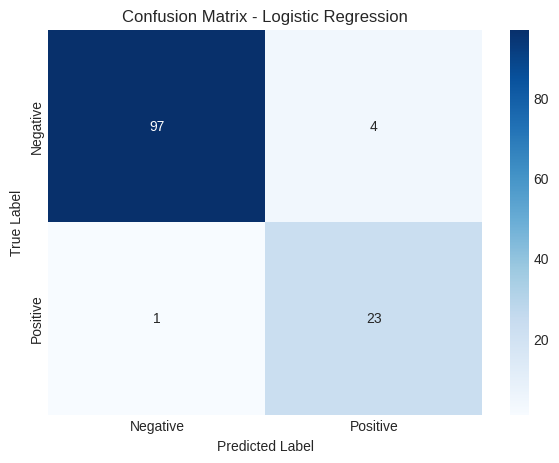

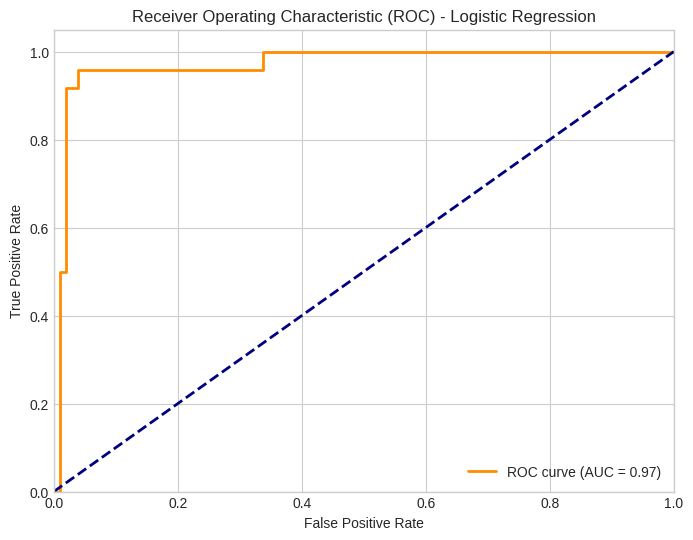

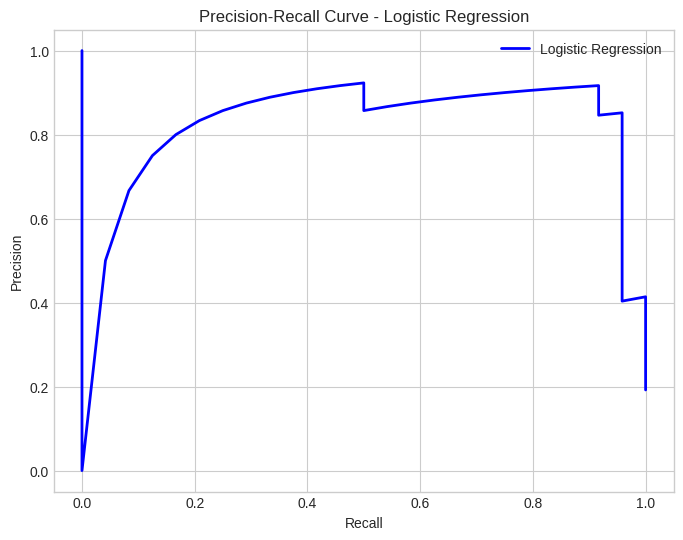


Learning Curve for Logistic Regression:


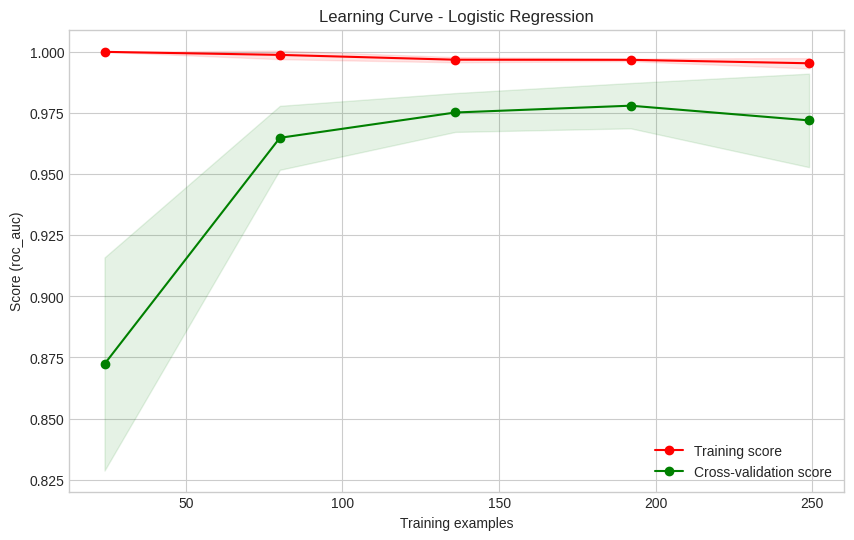

<ipython-input-45-ab827eb2675a>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=feature_importance_df, palette='coolwarm_r')


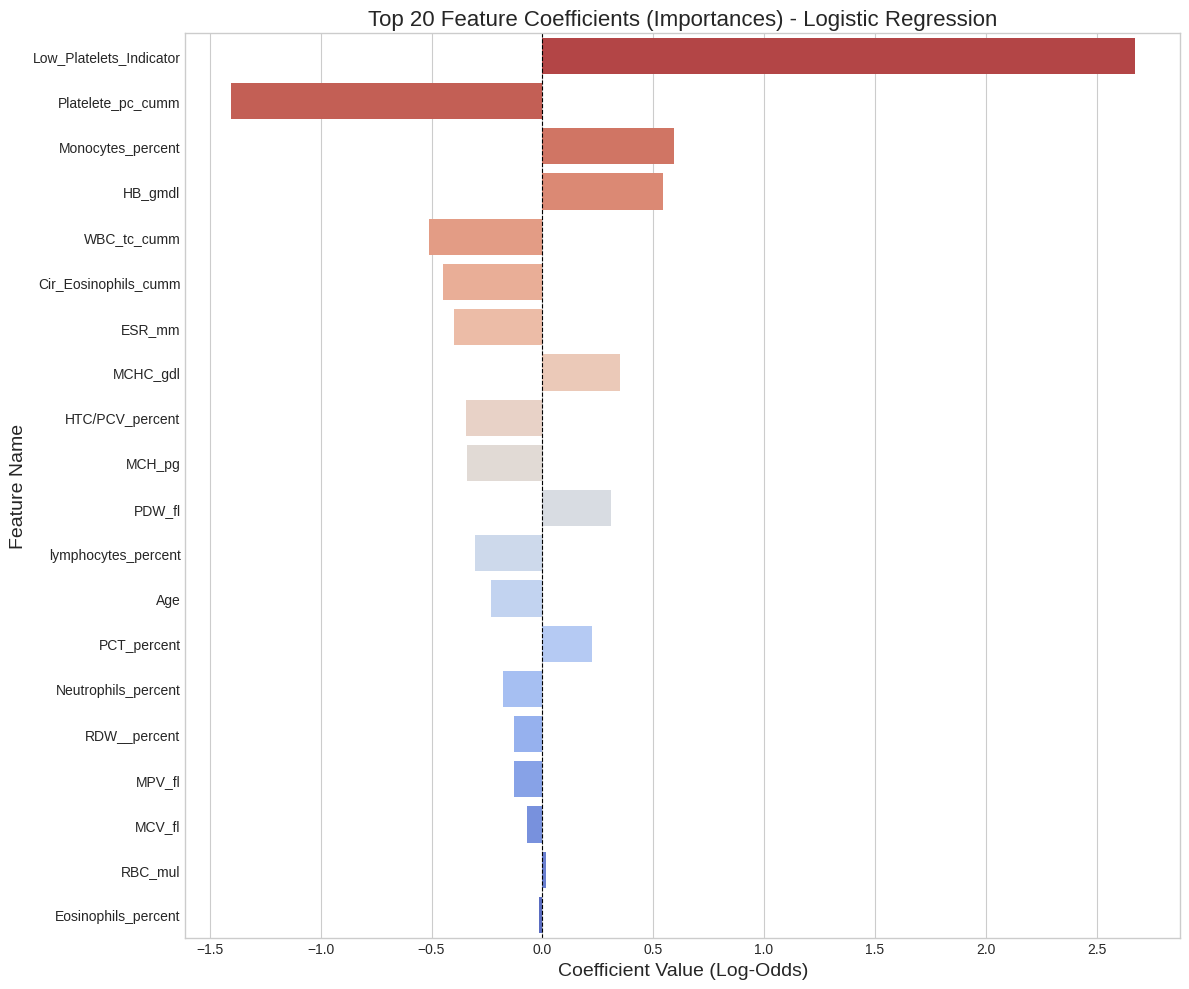



--- Evaluating: K-Nearest Neighbors ---
Accuracy: 0.9280
Precision: 0.8000
Recall: 0.8333
F1-Score: 0.8163
ROC AUC: 0.9204
Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.95      0.96       101
    Positive       0.80      0.83      0.82        24

    accuracy                           0.93       125
   macro avg       0.88      0.89      0.89       125
weighted avg       0.93      0.93      0.93       125


Plots for K-Nearest Neighbors:


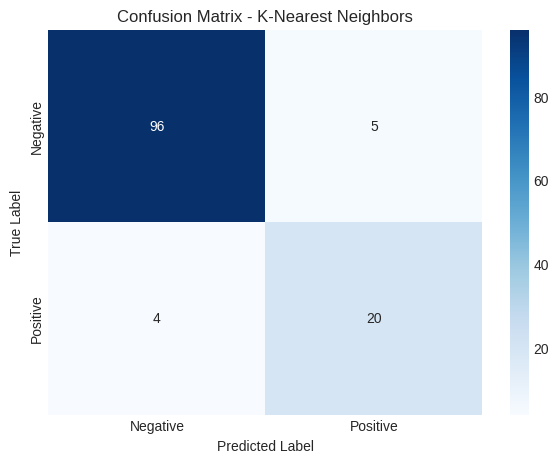

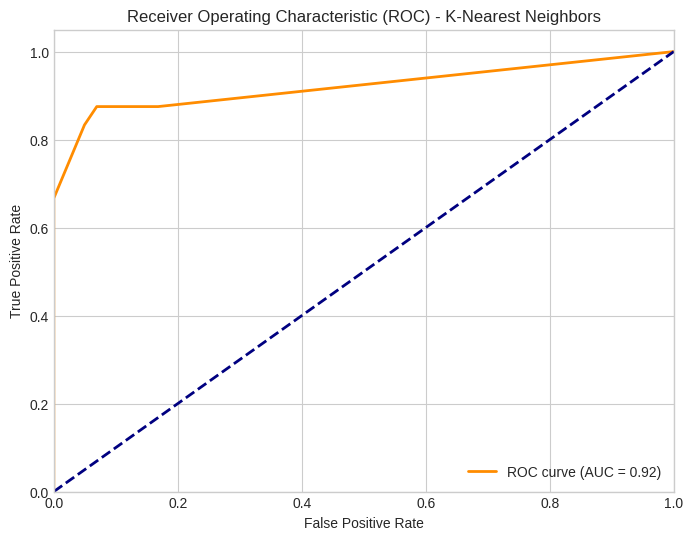

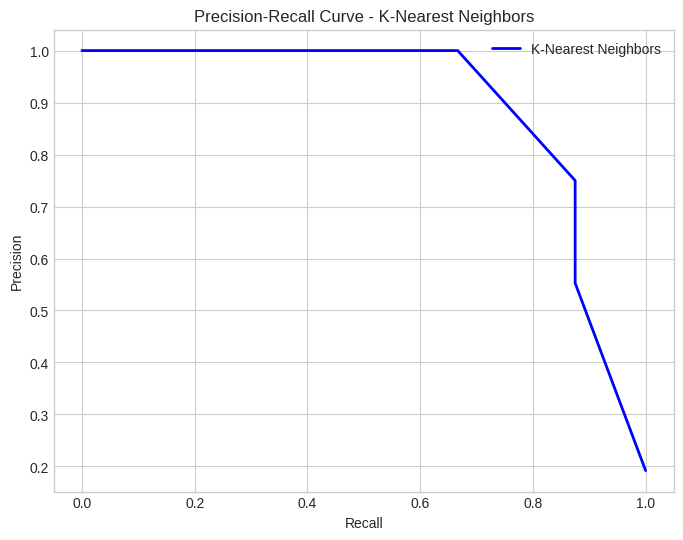


Learning Curve for K-Nearest Neighbors:


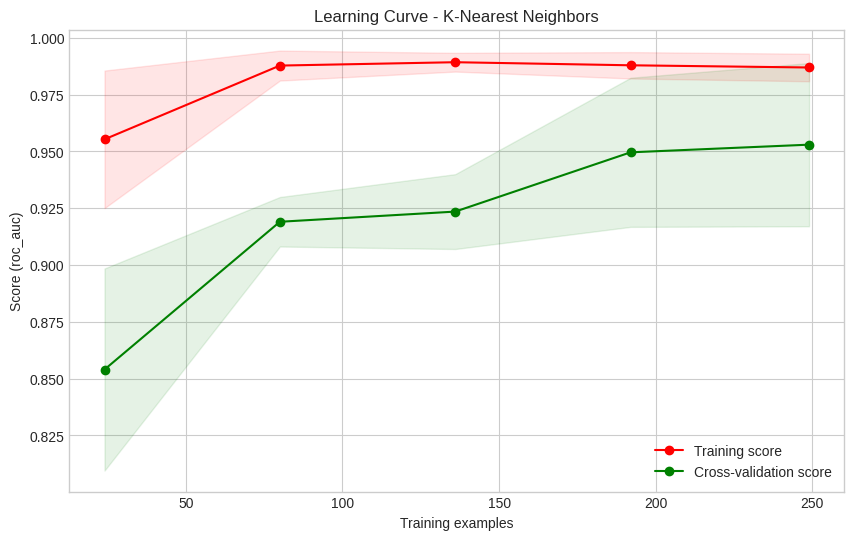



--- Evaluating: Support Vector Machine ---
Accuracy: 0.9680
Precision: 0.8846
Recall: 0.9583
F1-Score: 0.9200
ROC AUC: 0.9748
Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       101
    Positive       0.88      0.96      0.92        24

    accuracy                           0.97       125
   macro avg       0.94      0.96      0.95       125
weighted avg       0.97      0.97      0.97       125


Plots for Support Vector Machine:


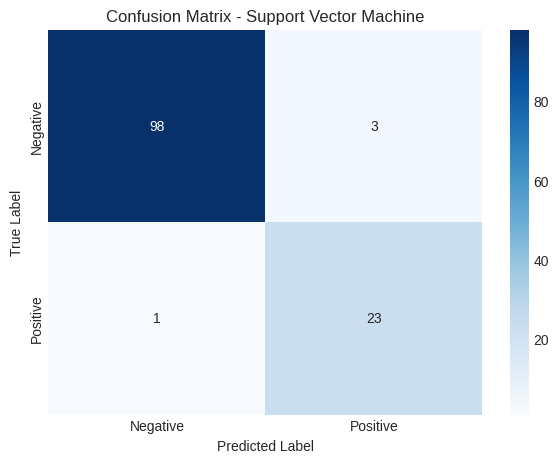

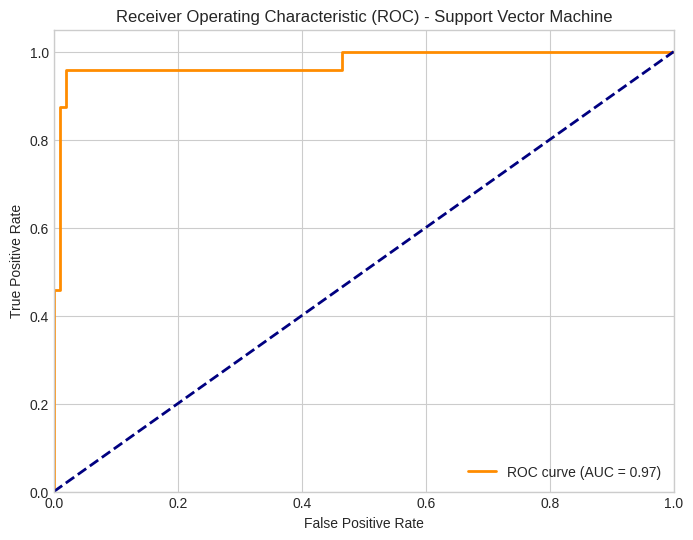

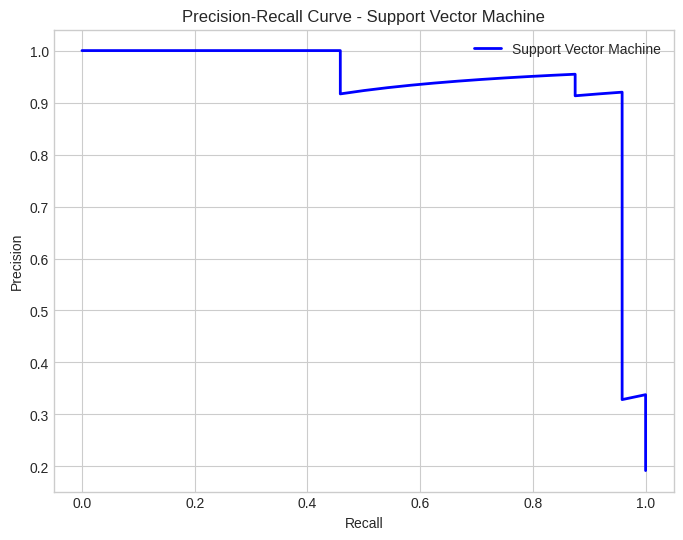


Learning Curve for Support Vector Machine:


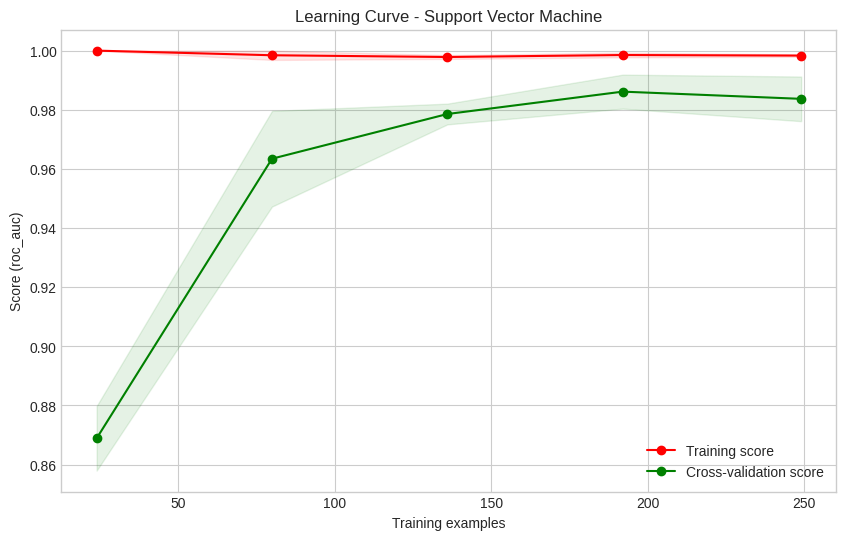



--- Evaluating: Decision Tree ---
Accuracy: 0.9680
Precision: 0.9167
Recall: 0.9167
F1-Score: 0.9167
ROC AUC: 0.9480
Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98       101
    Positive       0.92      0.92      0.92        24

    accuracy                           0.97       125
   macro avg       0.95      0.95      0.95       125
weighted avg       0.97      0.97      0.97       125


Plots for Decision Tree:


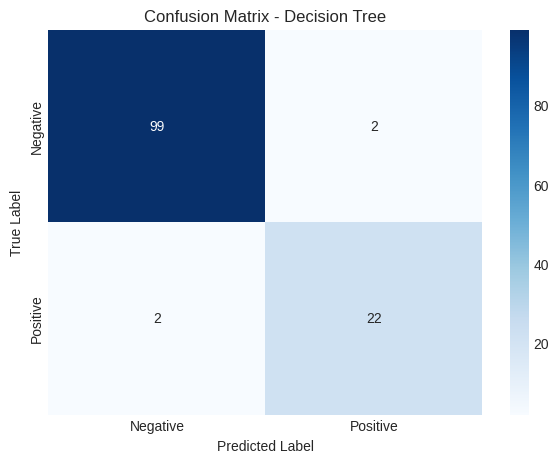

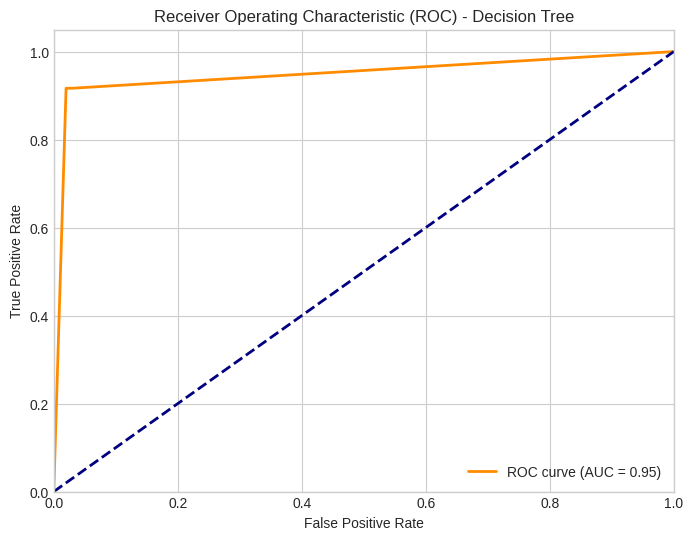

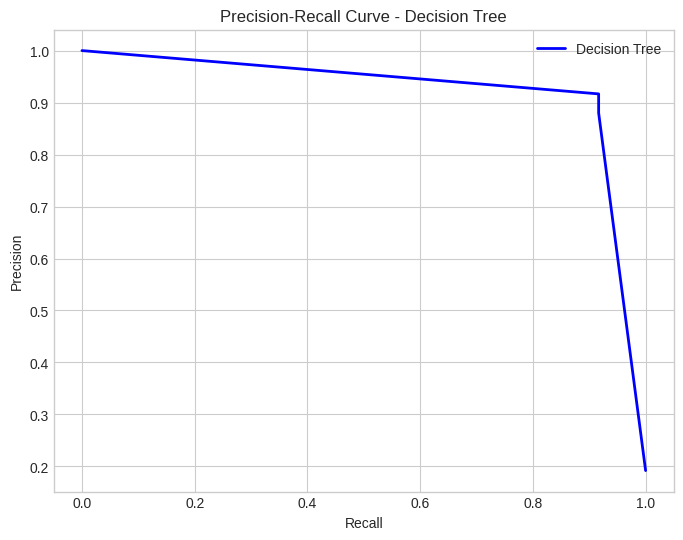


Learning Curve for Decision Tree:


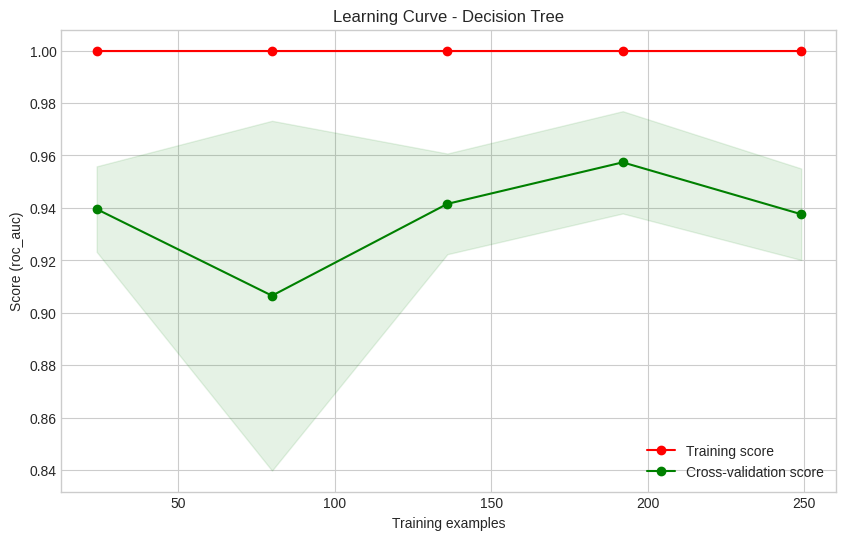

<ipython-input-45-ab827eb2675a>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


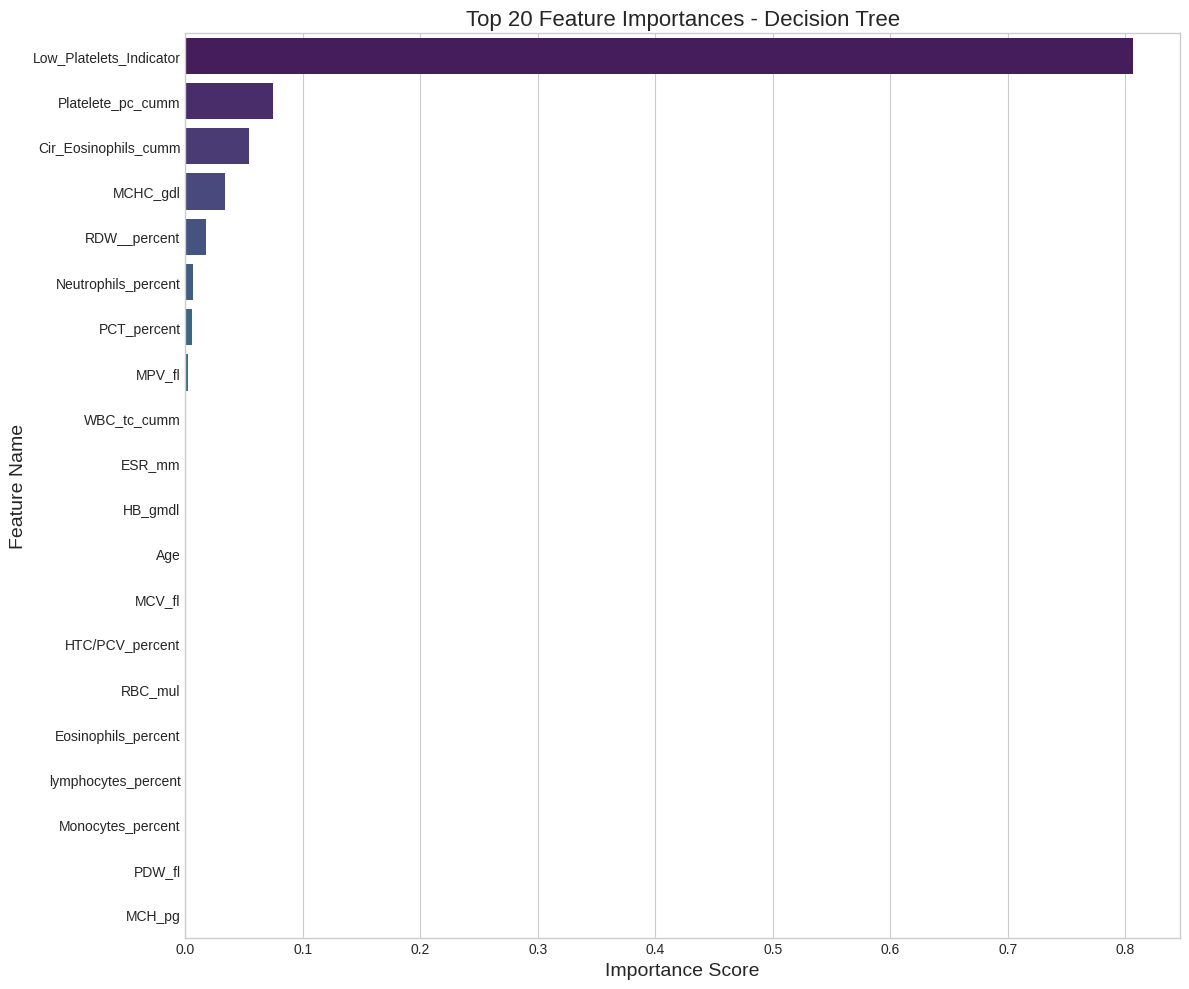



--- Evaluating: Random Forest ---
Accuracy: 0.9760
Precision: 0.9200
Recall: 0.9583
F1-Score: 0.9388
ROC AUC: 0.9907
Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99       101
    Positive       0.92      0.96      0.94        24

    accuracy                           0.98       125
   macro avg       0.96      0.97      0.96       125
weighted avg       0.98      0.98      0.98       125


Plots for Random Forest:


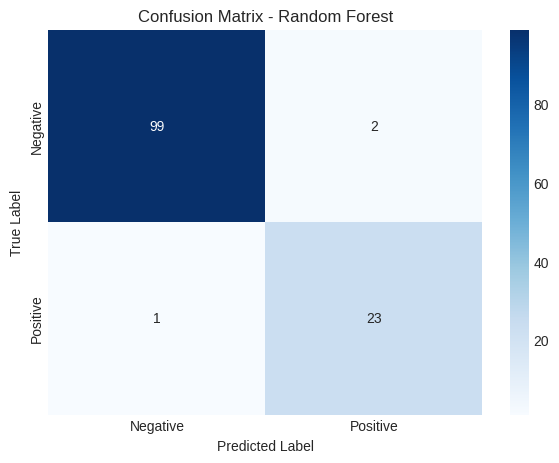

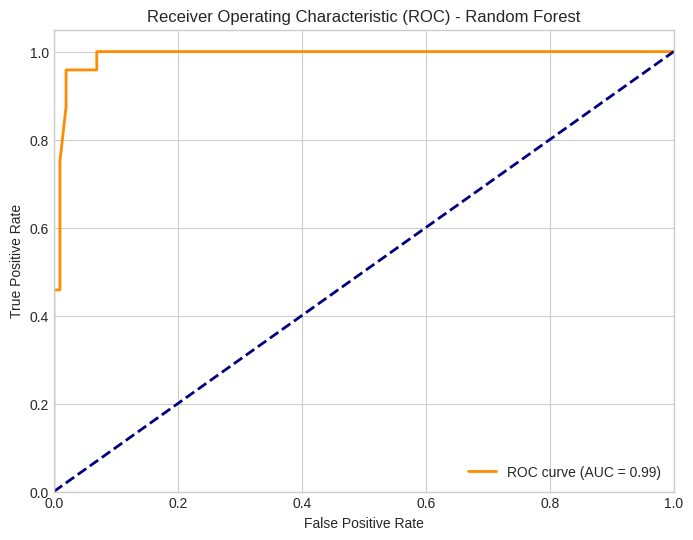

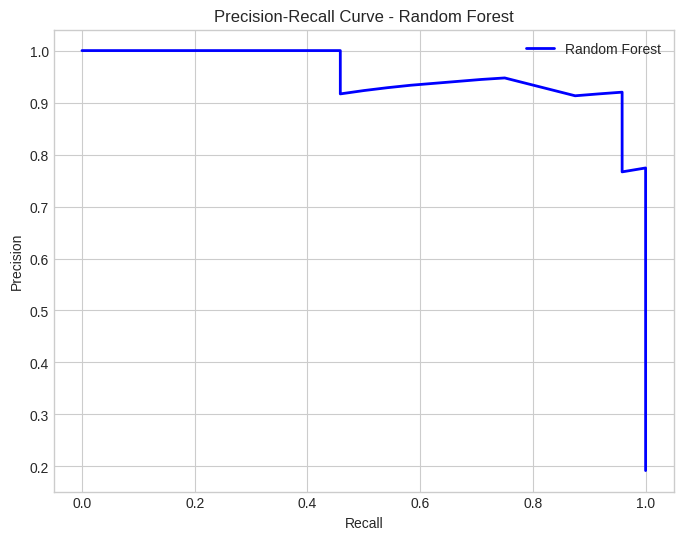


Learning Curve for Random Forest:


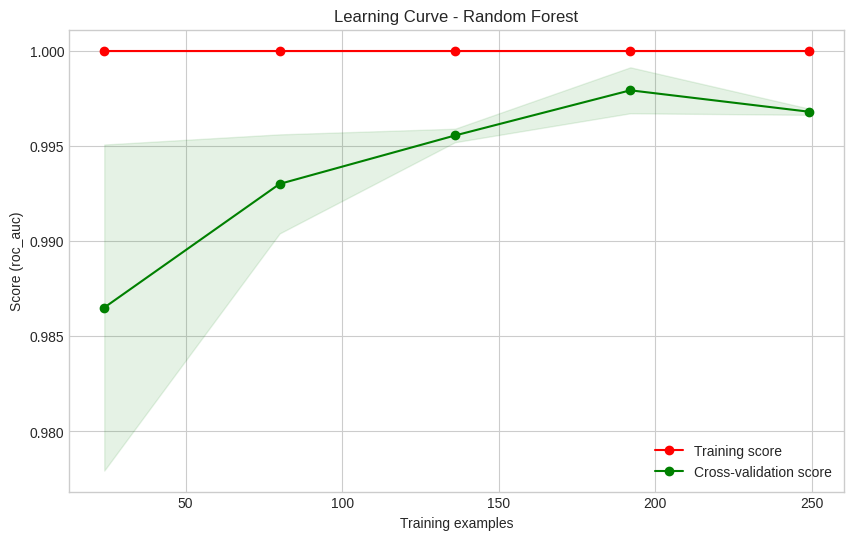

<ipython-input-45-ab827eb2675a>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


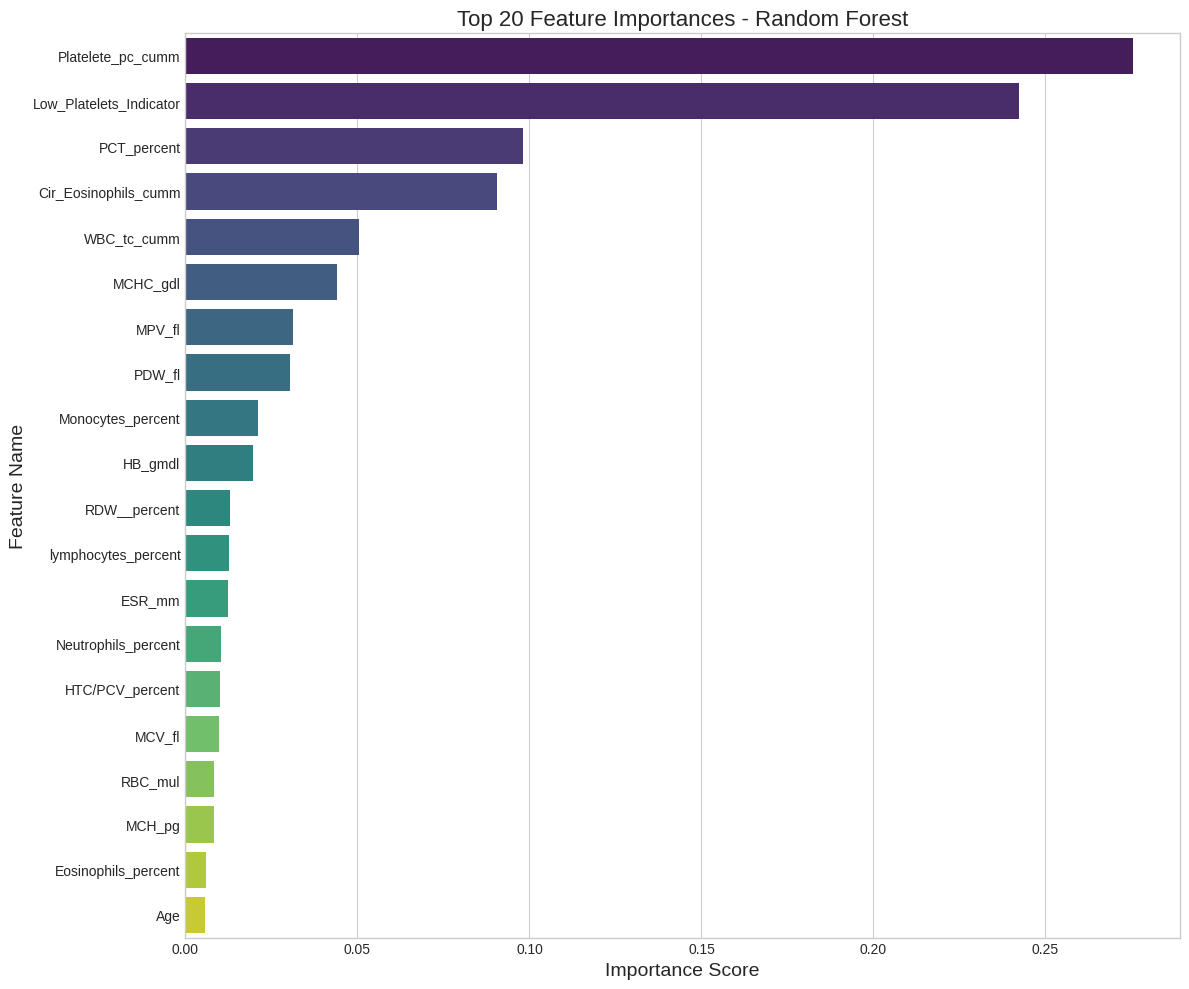



--- Evaluating: Gradient Boosting ---
Accuracy: 0.9680
Precision: 0.8846
Recall: 0.9583
F1-Score: 0.9200
ROC AUC: 0.9917
Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       101
    Positive       0.88      0.96      0.92        24

    accuracy                           0.97       125
   macro avg       0.94      0.96      0.95       125
weighted avg       0.97      0.97      0.97       125


Plots for Gradient Boosting:


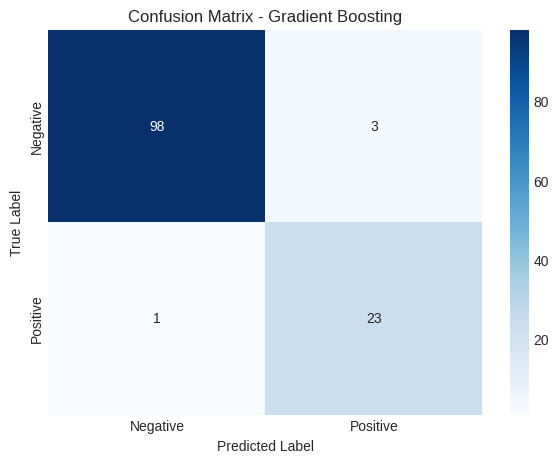

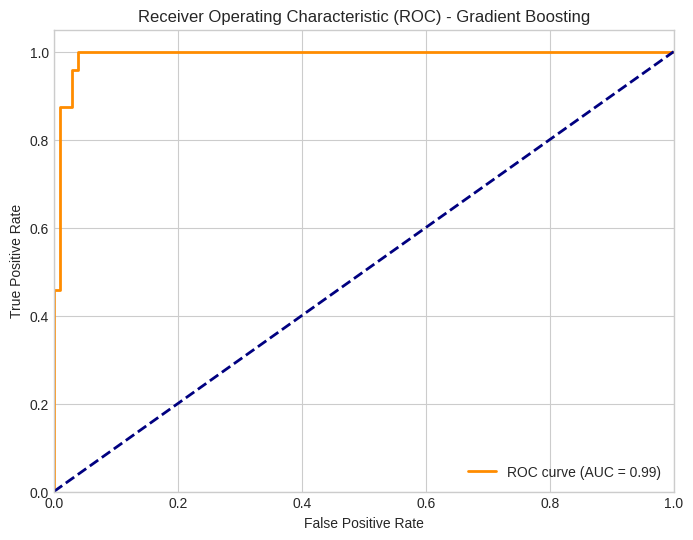

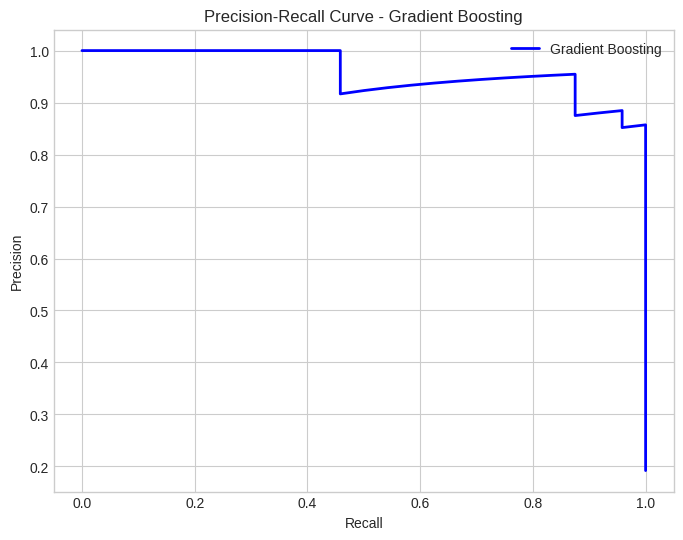


Learning Curve for Gradient Boosting:


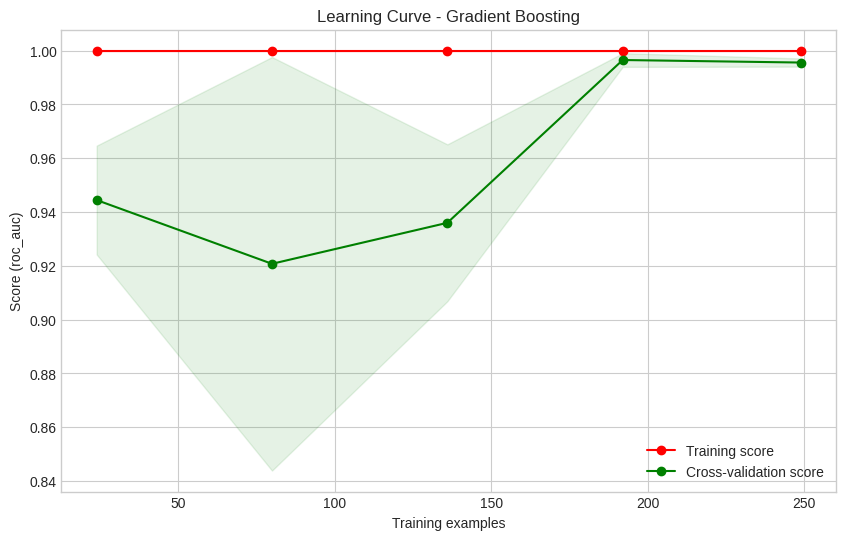

<ipython-input-45-ab827eb2675a>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


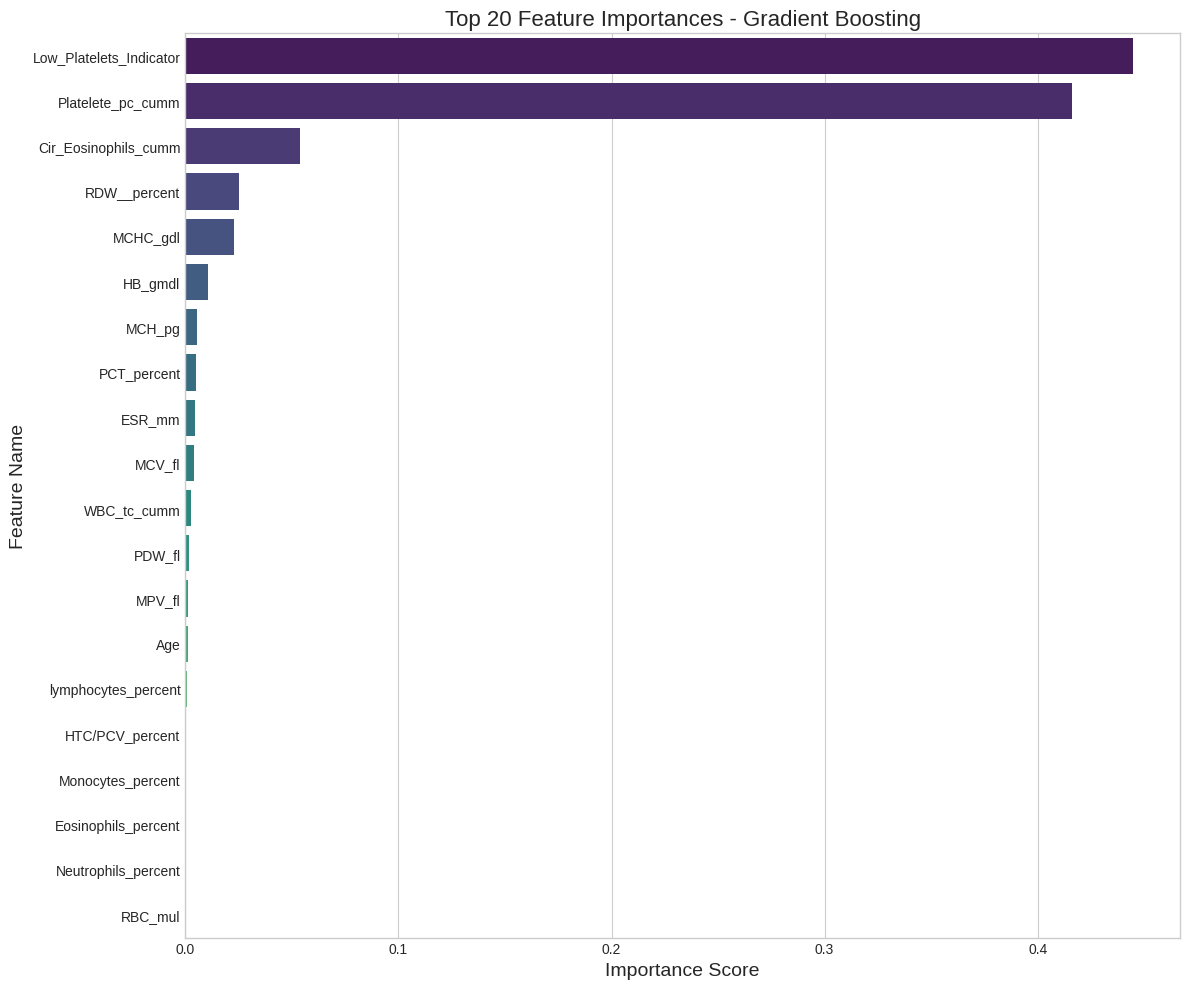



--- Evaluating: AdaBoost ---
Accuracy: 0.9760
Precision: 0.9200
Recall: 0.9583
F1-Score: 0.9388
ROC AUC: 0.9874
Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99       101
    Positive       0.92      0.96      0.94        24

    accuracy                           0.98       125
   macro avg       0.96      0.97      0.96       125
weighted avg       0.98      0.98      0.98       125


Plots for AdaBoost:


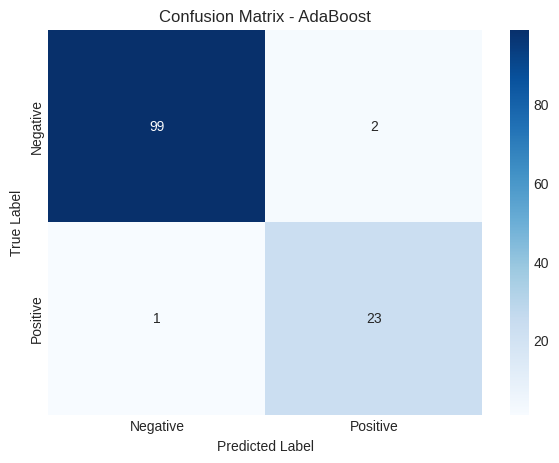

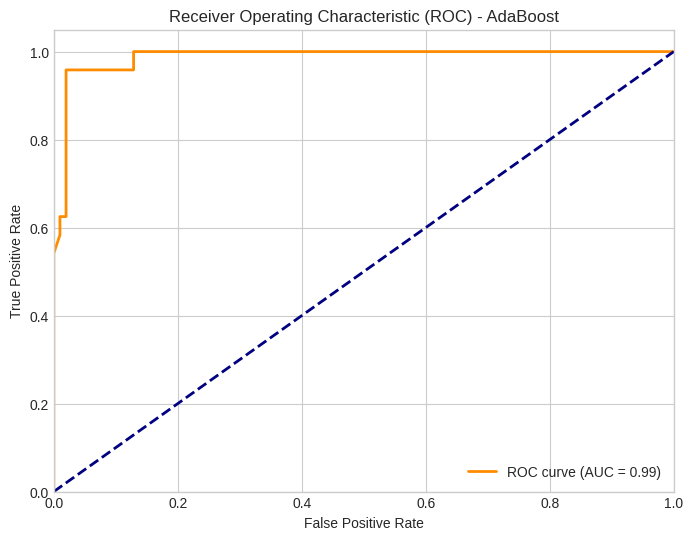

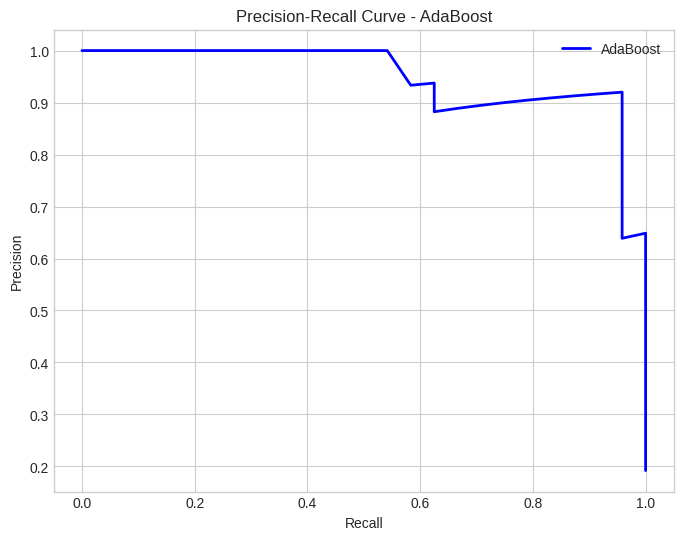


Learning Curve for AdaBoost:


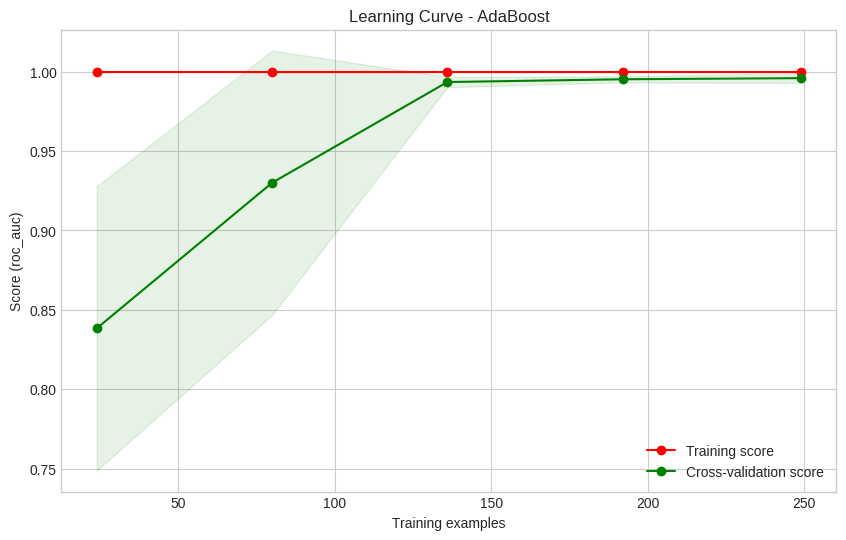

<ipython-input-45-ab827eb2675a>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


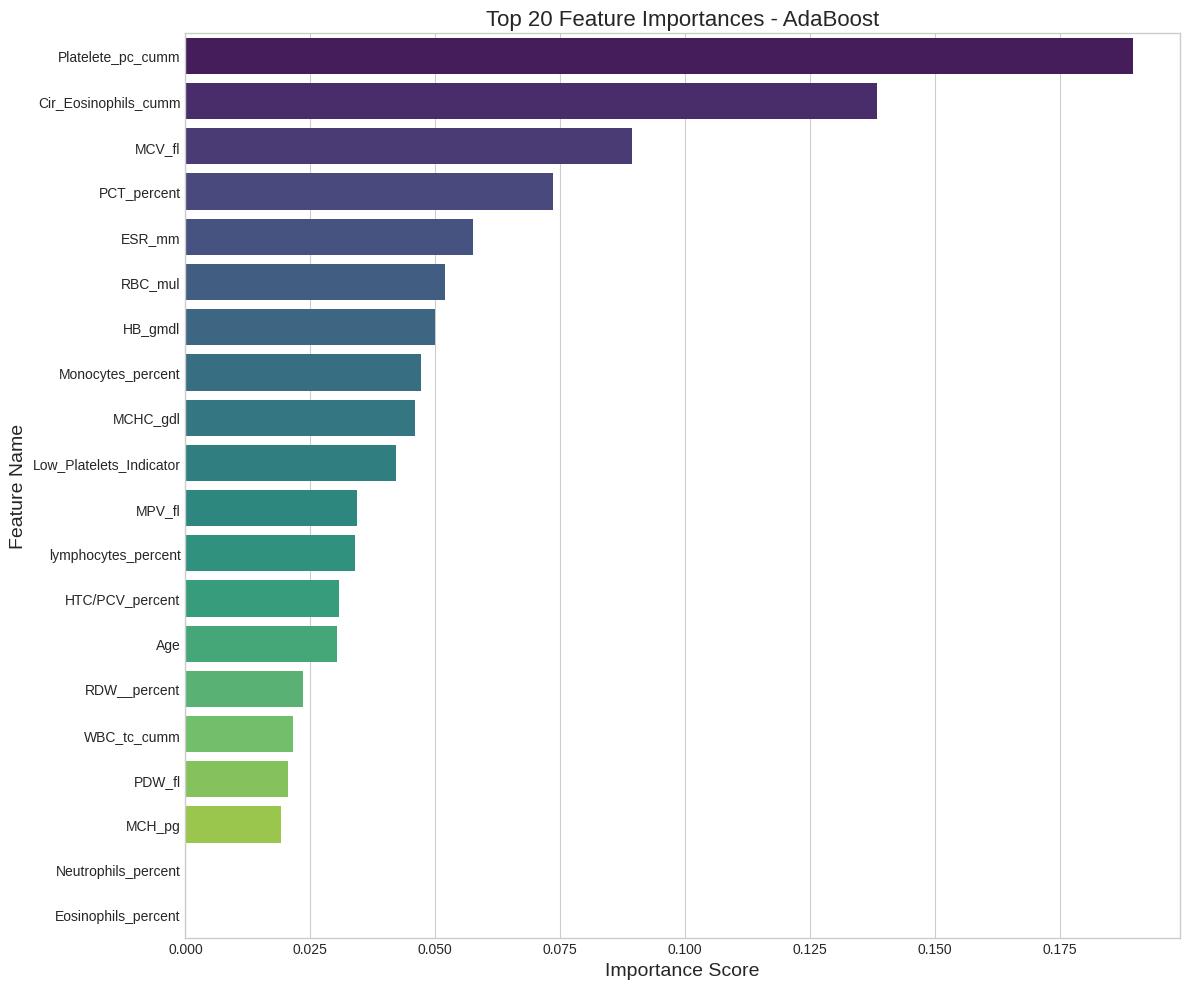



--- Evaluating: Gaussian Naive Bayes ---
Accuracy: 0.9360
Precision: 0.7667
Recall: 0.9583
F1-Score: 0.8519
ROC AUC: 0.9670
Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.93      0.96       101
    Positive       0.77      0.96      0.85        24

    accuracy                           0.94       125
   macro avg       0.88      0.94      0.91       125
weighted avg       0.95      0.94      0.94       125


Plots for Gaussian Naive Bayes:


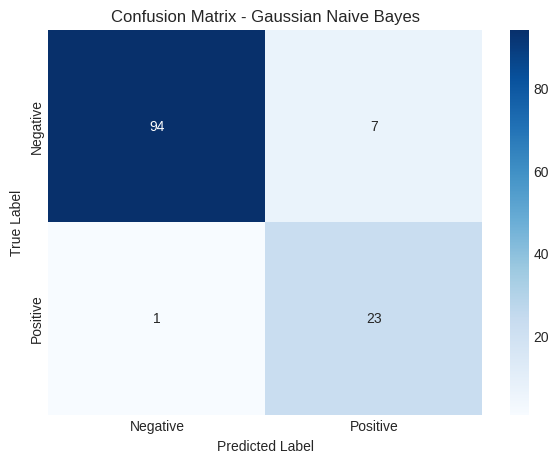

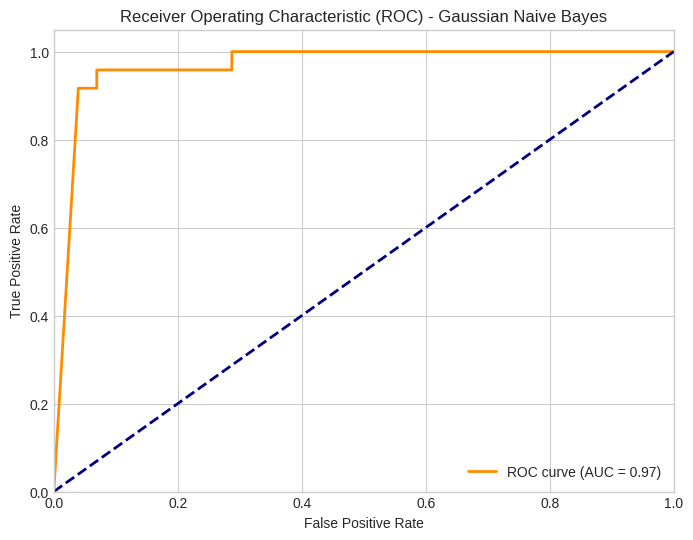

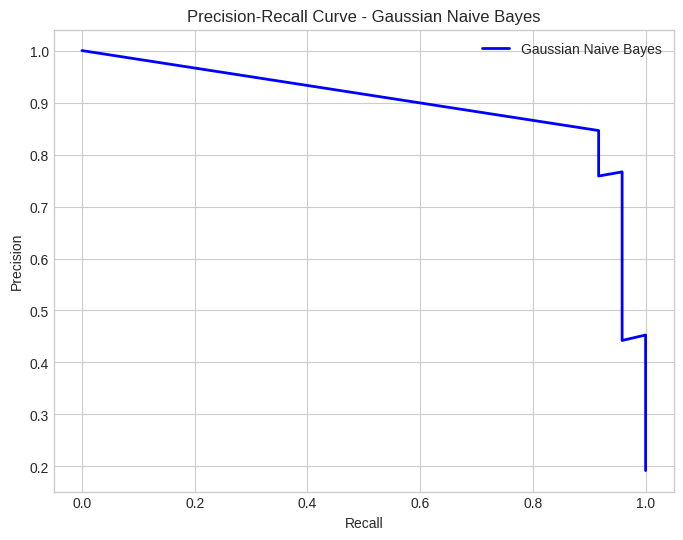


Learning Curve for Gaussian Naive Bayes:


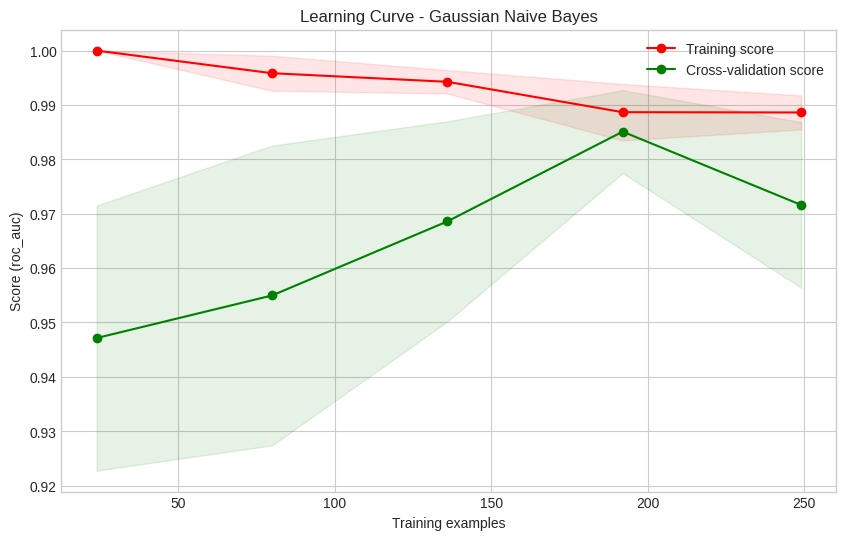



--- Evaluating: XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:08:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9680
Precision: 0.8846
Recall: 0.9583
F1-Score: 0.9200
ROC AUC: 0.9854
Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       101
    Positive       0.88      0.96      0.92        24

    accuracy                           0.97       125
   macro avg       0.94      0.96      0.95       125
weighted avg       0.97      0.97      0.97       125


Plots for XGBoost:


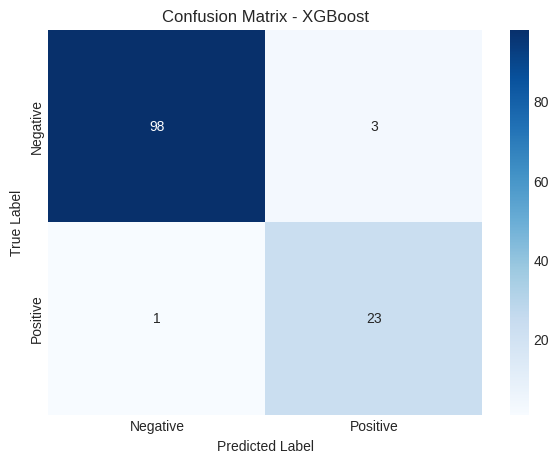

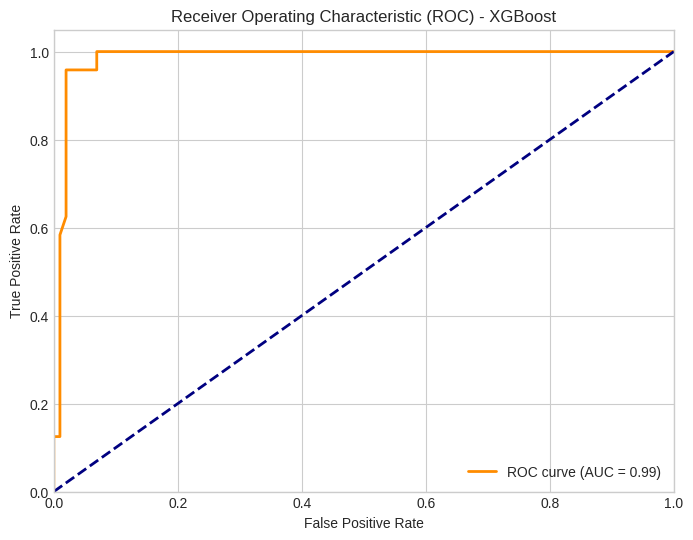

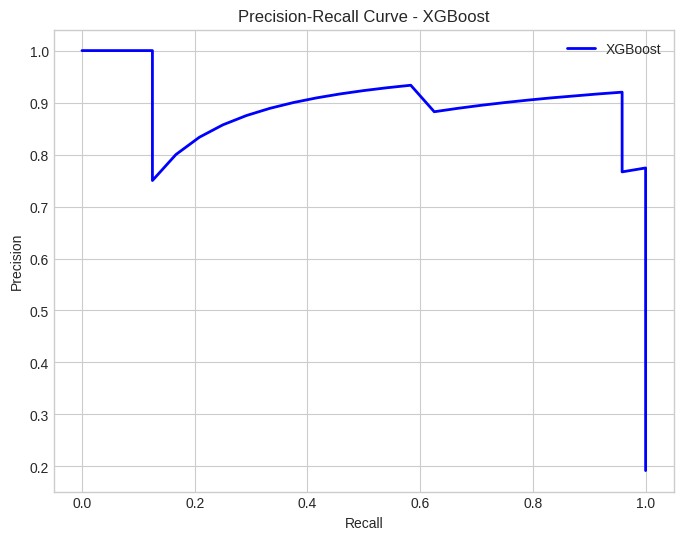


Learning Curve for XGBoost:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:08:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:08:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:08:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:08:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:08:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

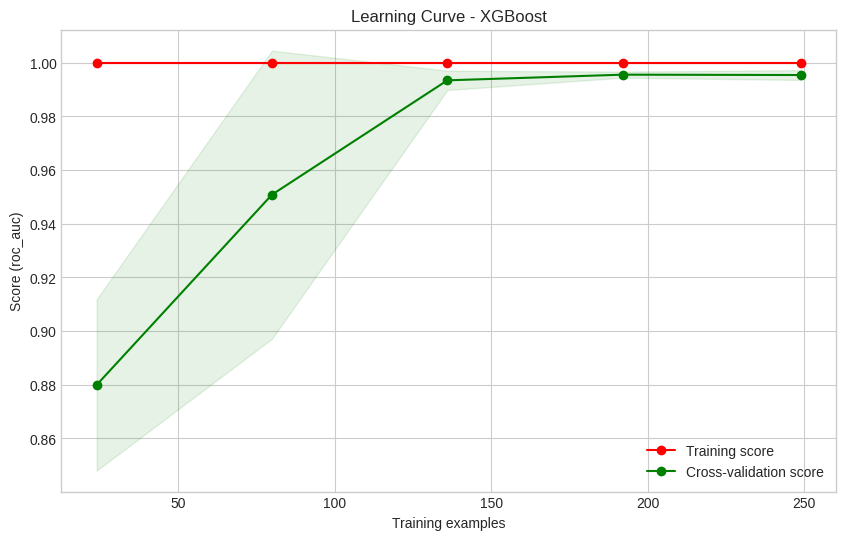

<ipython-input-45-ab827eb2675a>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


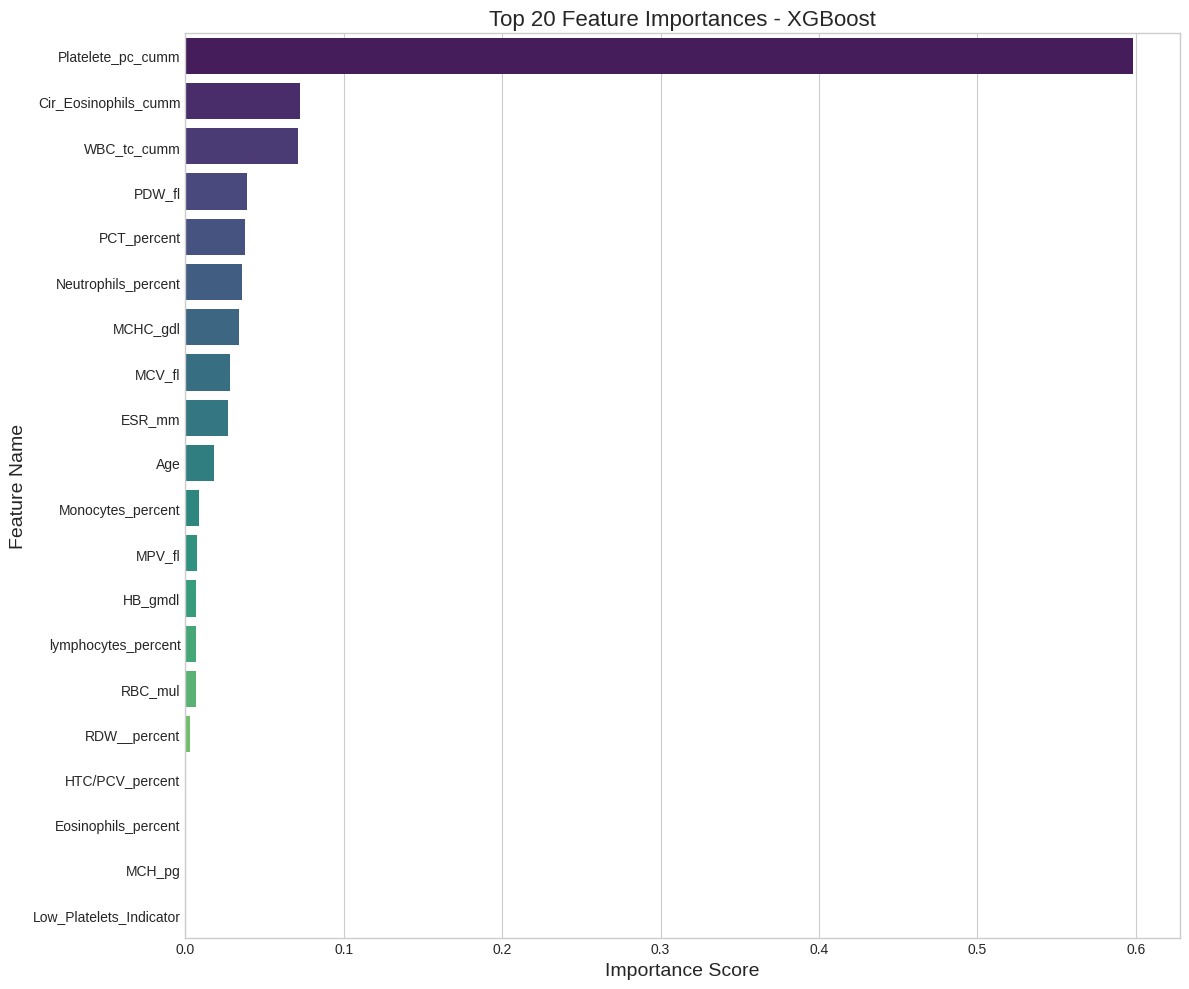

In [ ]:

model_performance_summary = {}


for model_name, model_instance in models_dict.items():
    print(f"\n\n--- Evaluating: {model_name} ---")


    model_instance.fit(X_train_scaled, y_train)


    y_pred_test = model_instance.predict(X_test_scaled)
    y_pred_proba_test = model_instance.predict_proba(X_test_scaled)[:, 1] if hasattr(model_instance, "predict_proba") else None


    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred_test, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred_test, average='binary', zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba_test) if y_pred_proba_test is not None else 'N/A'

    report = classification_report(y_test, y_pred_test, zero_division=0,
                                   target_names=label_encoder_target.classes_ if 'label_encoder_target' in locals() else ['Class 0', 'Class 1'])

    model_performance_summary[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc if roc_auc != 'N/A' else 0
    }
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc != 'N/A': print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(report)


    print(f"\nPlots for {model_name}:")
    plot_confusion_matrix_custom(y_test, y_pred_test, model_name)
    if y_pred_proba_test is not None:
        plot_roc_curve_custom(y_test, y_pred_proba_test, model_name)
        plot_precision_recall_curve_custom(y_test, y_pred_proba_test, model_name)

    print(f"\nLearning Curve for {model_name}:")

    plot_learning_curve_custom(model_instance, f"Learning Curve - {model_name}", X_train_scaled, y_train, cv=3, scoring='roc_auc' if y_pred_proba_test is not None else 'accuracy')



    if hasattr(model_instance, 'feature_importances_'): # For tree-based models
        importances = model_instance.feature_importances_
        feature_names = X_train.columns
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

        plt.figure(figsize=(12, 10))
        sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Top 20 Feature Importances - {model_name}', fontsize=16)
        plt.xlabel('Importance Score', fontsize=14)
        plt.ylabel('Feature Name', fontsize=14)
        plt.tight_layout()
        plt.show()
    elif hasattr(model_instance, 'coef_'):
        if model_name == "Logistic Regression" and model_instance.coef_.shape[0] == 1:
            importances = model_instance.coef_[0]
            feature_names = X_train.columns

            feature_importance_df = pd.DataFrame({'feature': feature_names, 'coefficient': importances})
            feature_importance_df['abs_coefficient'] = np.abs(feature_importance_df['coefficient'])
            feature_importance_df = feature_importance_df.sort_values(by='abs_coefficient', ascending=False).head(20)

            plt.figure(figsize=(12, 10))
            sns.barplot(x='coefficient', y='feature', data=feature_importance_df, palette='coolwarm_r')
            plt.title(f'Top 20 Feature Coefficients (Importances) - {model_name}', fontsize=16)
            plt.xlabel('Coefficient Value (Log-Odds)', fontsize=14)
            plt.ylabel('Feature Name', fontsize=14)
            plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
            plt.tight_layout()
            plt.show()

# Model Comparison



--- Overall Model Performance Summary ---
                        Accuracy  Precision    Recall  F1-Score   ROC AUC
Gradient Boosting          0.968   0.884615  0.958333  0.920000  0.991749
Random Forest              0.976   0.920000  0.958333  0.938776  0.990718
AdaBoost                   0.976   0.920000  0.958333  0.938776  0.987417
XGBoost                    0.968   0.884615  0.958333  0.920000  0.985355
Support Vector Machine     0.968   0.884615  0.958333  0.920000  0.974835
Logistic Regression        0.960   0.851852  0.958333  0.901961  0.971122
Gaussian Naive Bayes       0.936   0.766667  0.958333  0.851852  0.966997
Decision Tree              0.968   0.916667  0.916667  0.916667  0.948020
K-Nearest Neighbors        0.928   0.800000  0.833333  0.816327  0.920380


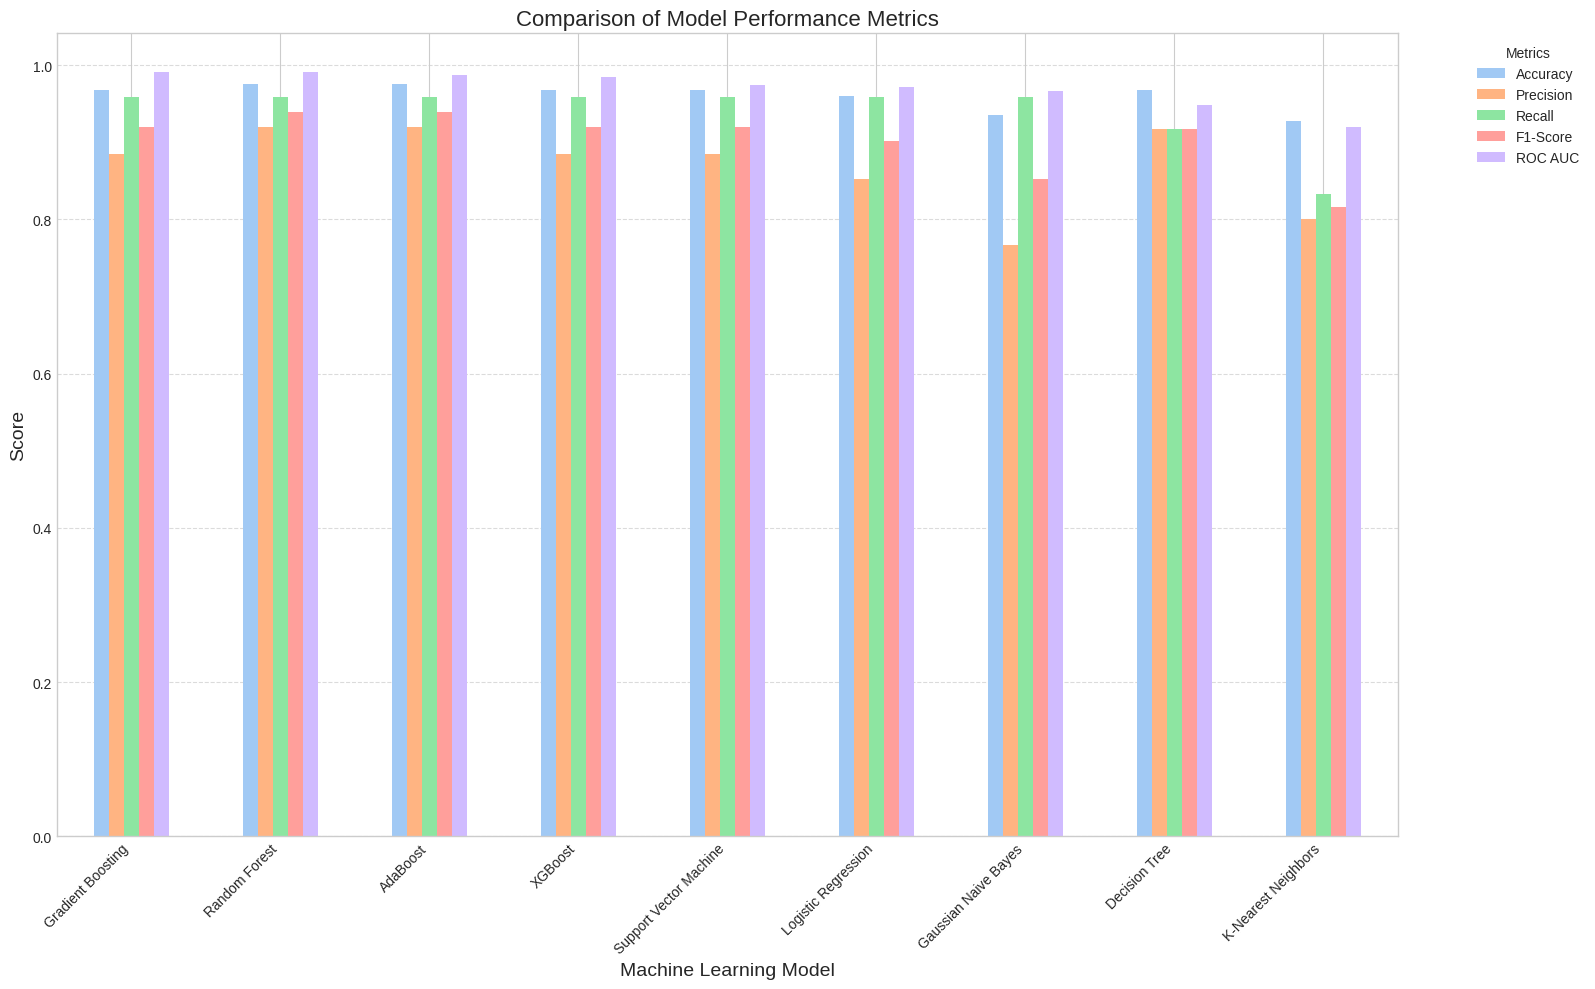

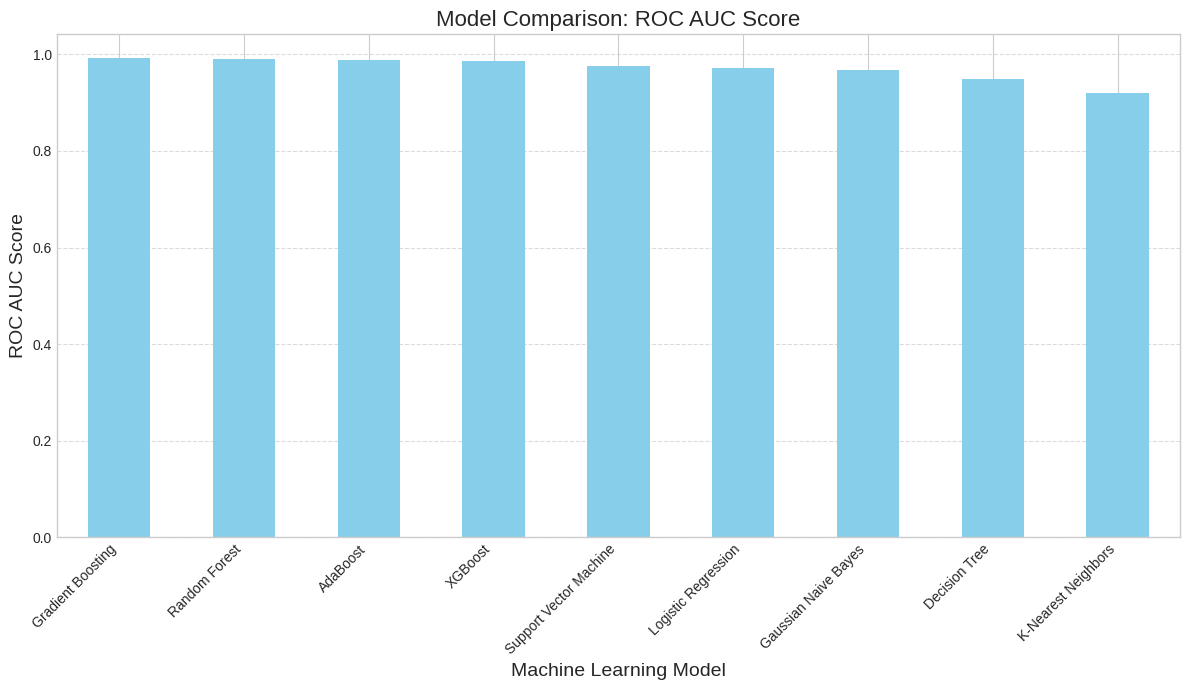

In [ ]:
print("\n\n--- Overall Model Performance Summary ---")
performance_summary_df = pd.DataFrame(model_performance_summary).T
performance_summary_df = performance_summary_df.sort_values(by='ROC AUC', ascending=False)

print(performance_summary_df)

plt.figure(figsize=(16, 10))
performance_summary_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']].plot(kind='bar', ax=plt.gca())
plt.title('Comparison of Model Performance Metrics', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Machine Learning Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Specifically ROC AUC for comparison
plt.figure(figsize=(12, 7))
performance_summary_df['ROC AUC'].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Model Comparison: ROC AUC Score', fontsize=16)
plt.ylabel('ROC AUC Score', fontsize=14)
plt.xlabel('Machine Learning Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




# Applying SMOTE

In [ ]:
%pip install imblearn

In [ ]:

try:
    import imblearn
    print("imbalanced-learn is already installed.")
except ImportError:
    print("imbalanced-learn not found. Attempting to install...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "imblearn"])
        print("imbalanced-learn installed successfully.")
        import imblearn
    except Exception as e:
        print(f"Error installing imbalanced-learn: {e}")
        print("Please install imbalanced-learn manually (e.g., 'pip install imbalanced-learn') and then re-run the script.")
        imblearn = None


imbalanced-learn is already installed.



--- Applying SMOTE to Address Class Imbalance (if any) ---
Original training set shape: (374, 20)
Original training target distribution: Counter({0: 303, 1: 71})

Training set shape after SMOTE: (606, 20)
Training target distribution after SMOTE: Counter({0: 303, 1: 303})
SMOTE applied successfully to the training data.


--- Re-evaluating Models with SMOTE-augmented Training Data ---


--- Evaluating: Logistic Regression (with SMOTE training data) ---
Accuracy (with SMOTE): 0.9600
Precision (with SMOTE): 0.8519
Recall (with SMOTE): 0.9583
F1-Score (with SMOTE): 0.9020
ROC AUC (with SMOTE): 0.9691
Classification Report (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.99      0.96      0.97       101
    Positive       0.85      0.96      0.90        24

    accuracy                           0.96       125
   macro avg       0.92      0.96      0.94       125
weighted avg       0.96      0.96      0.96       125


Plots for Logistic Regression 

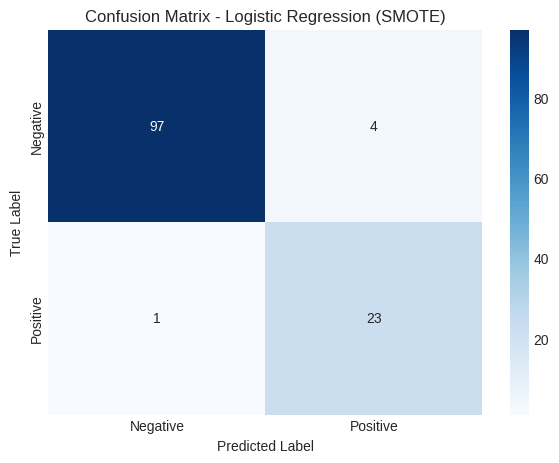

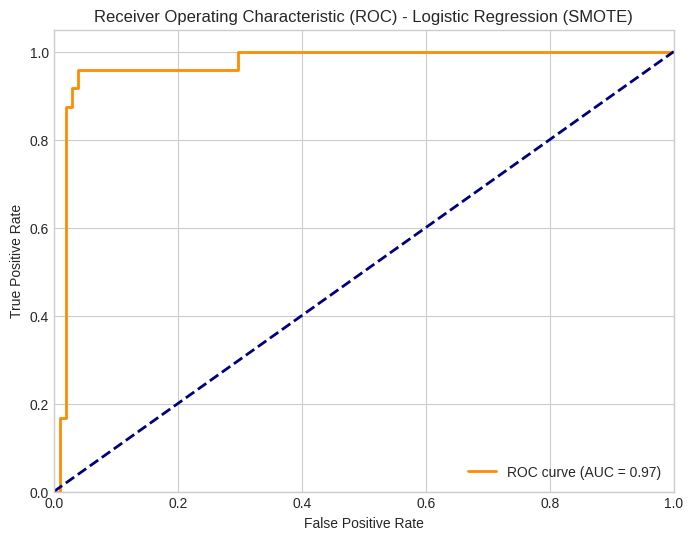

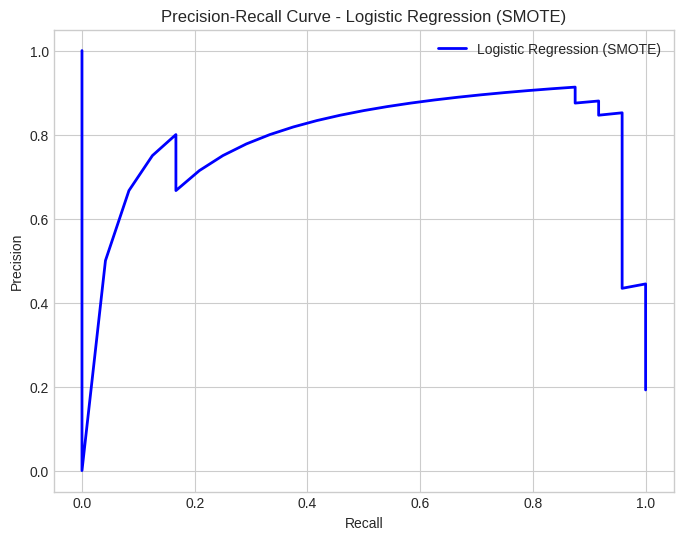

<ipython-input-49-5f5000814e81>:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=feature_importance_df_smote_lr, palette='coolwarm_r')


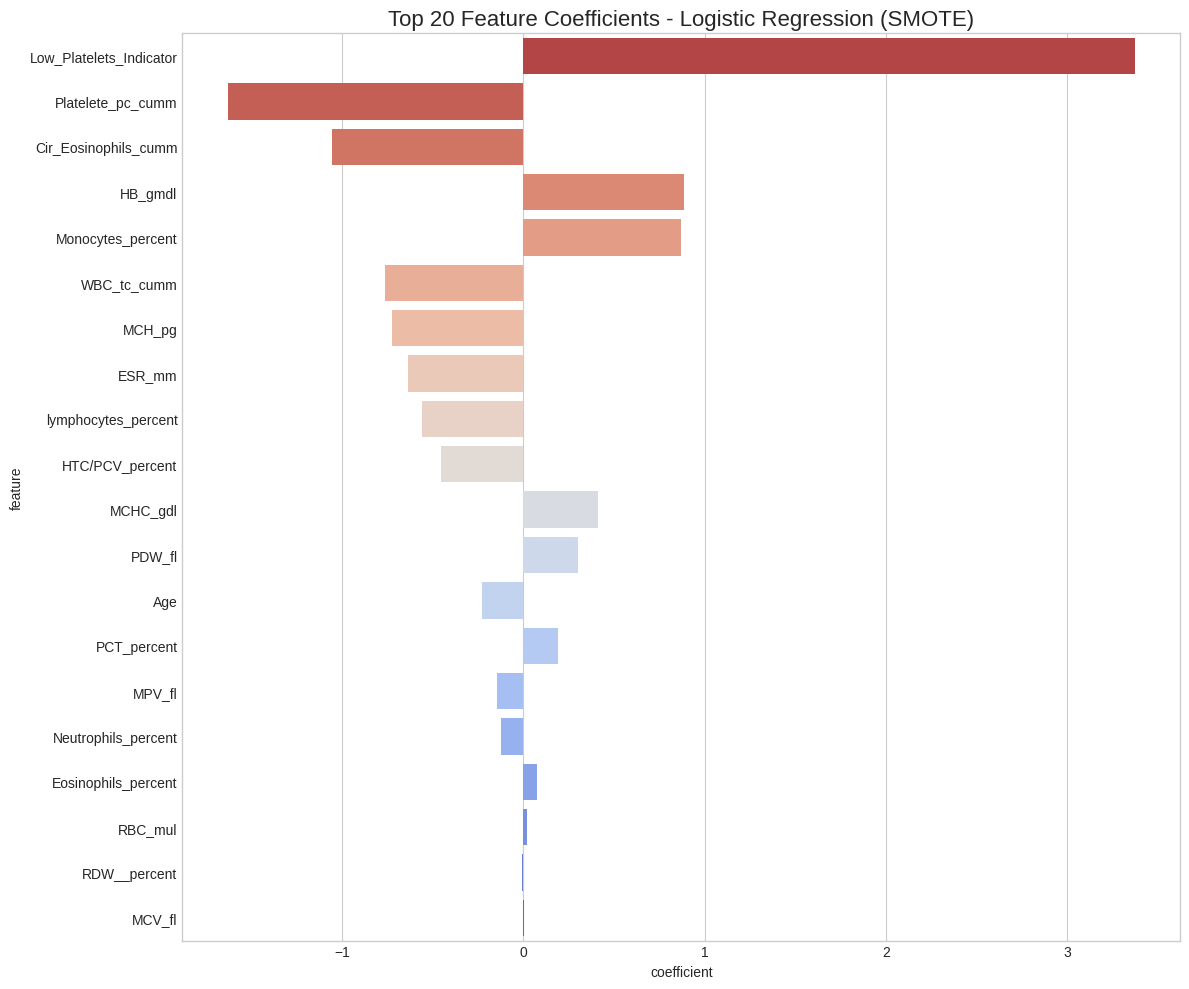



--- Evaluating: K-Nearest Neighbors (with SMOTE training data) ---
Accuracy (with SMOTE): 0.8960
Precision (with SMOTE): 0.6774
Recall (with SMOTE): 0.8750
F1-Score (with SMOTE): 0.7636
ROC AUC (with SMOTE): 0.9150
Classification Report (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.97      0.90      0.93       101
    Positive       0.68      0.88      0.76        24

    accuracy                           0.90       125
   macro avg       0.82      0.89      0.85       125
weighted avg       0.91      0.90      0.90       125


Plots for K-Nearest Neighbors (with SMOTE training data):


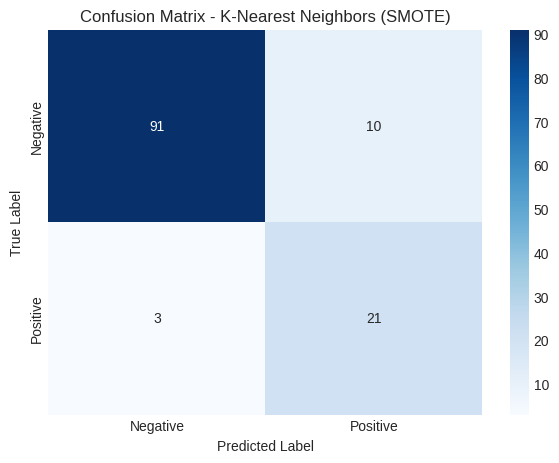

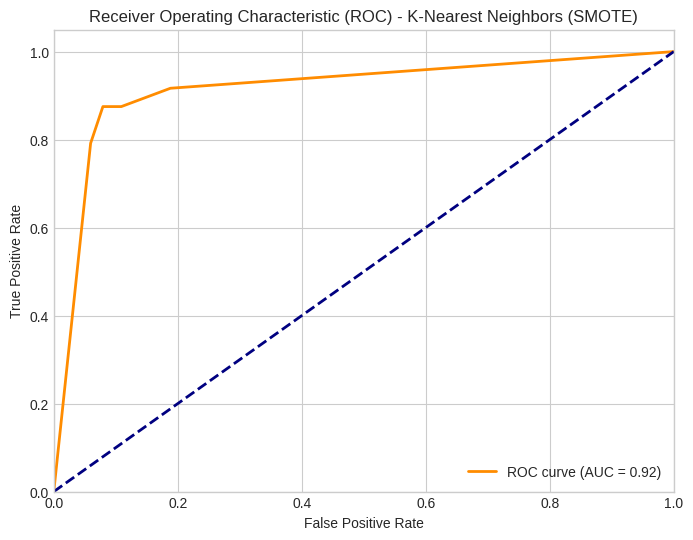

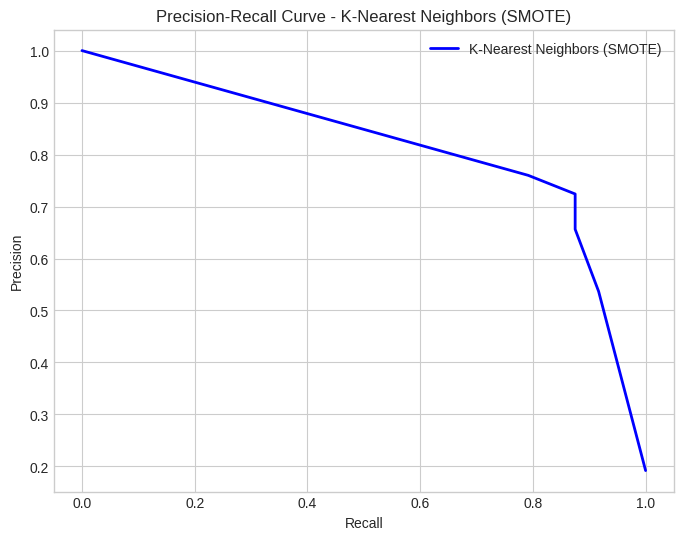



--- Evaluating: Support Vector Machine (with SMOTE training data) ---
Accuracy (with SMOTE): 0.9680
Precision (with SMOTE): 0.8846
Recall (with SMOTE): 0.9583
F1-Score (with SMOTE): 0.9200
ROC AUC (with SMOTE): 0.9649
Classification Report (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       101
    Positive       0.88      0.96      0.92        24

    accuracy                           0.97       125
   macro avg       0.94      0.96      0.95       125
weighted avg       0.97      0.97      0.97       125


Plots for Support Vector Machine (with SMOTE training data):


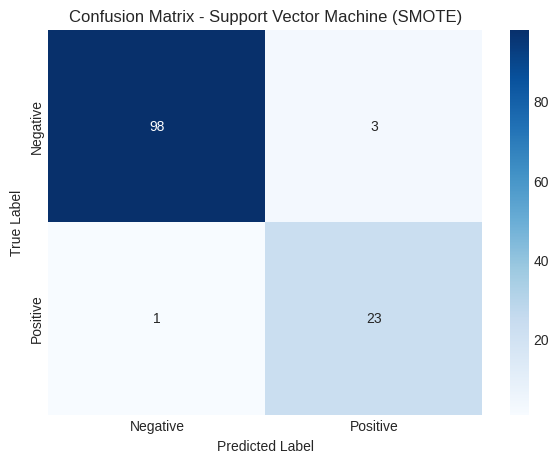

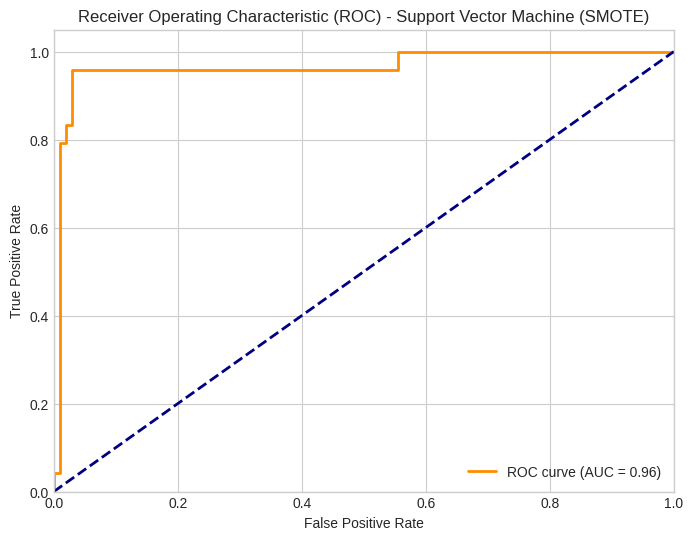

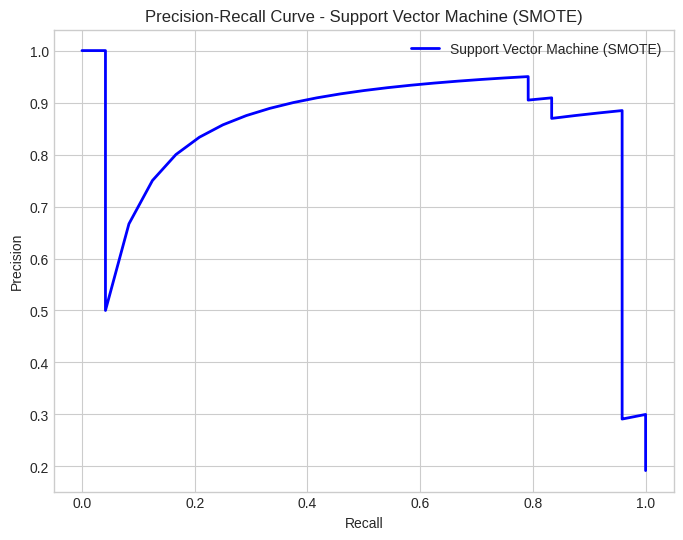



--- Evaluating: Decision Tree (with SMOTE training data) ---
Accuracy (with SMOTE): 0.9520
Precision (with SMOTE): 0.8750
Recall (with SMOTE): 0.8750
F1-Score (with SMOTE): 0.8750
ROC AUC (with SMOTE): 0.9202
Classification Report (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97       101
    Positive       0.88      0.88      0.88        24

    accuracy                           0.95       125
   macro avg       0.92      0.92      0.92       125
weighted avg       0.95      0.95      0.95       125


Plots for Decision Tree (with SMOTE training data):


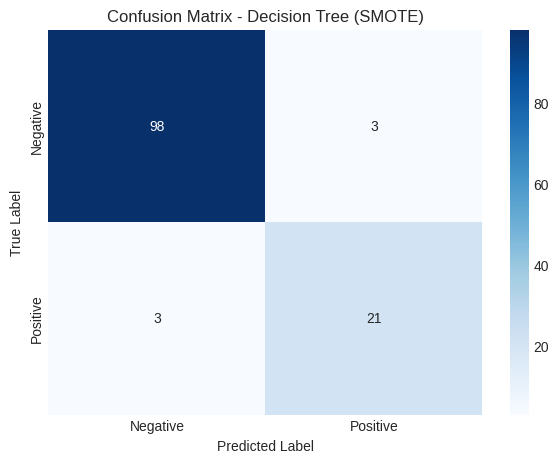

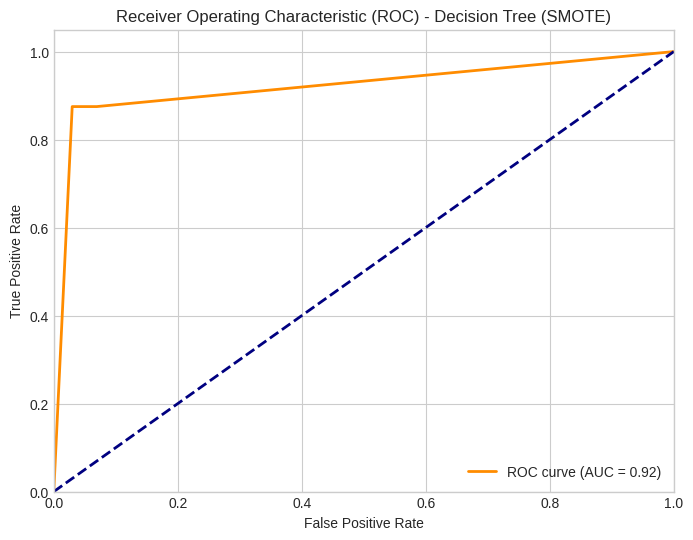

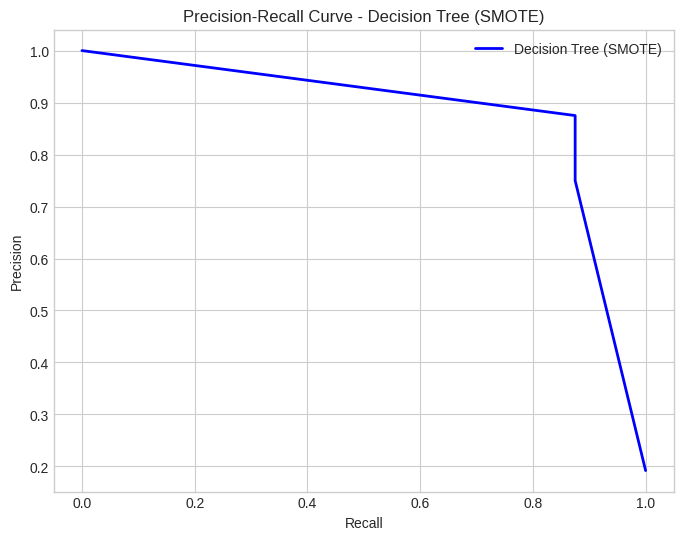

<ipython-input-49-5f5000814e81>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df_smote, palette='viridis')


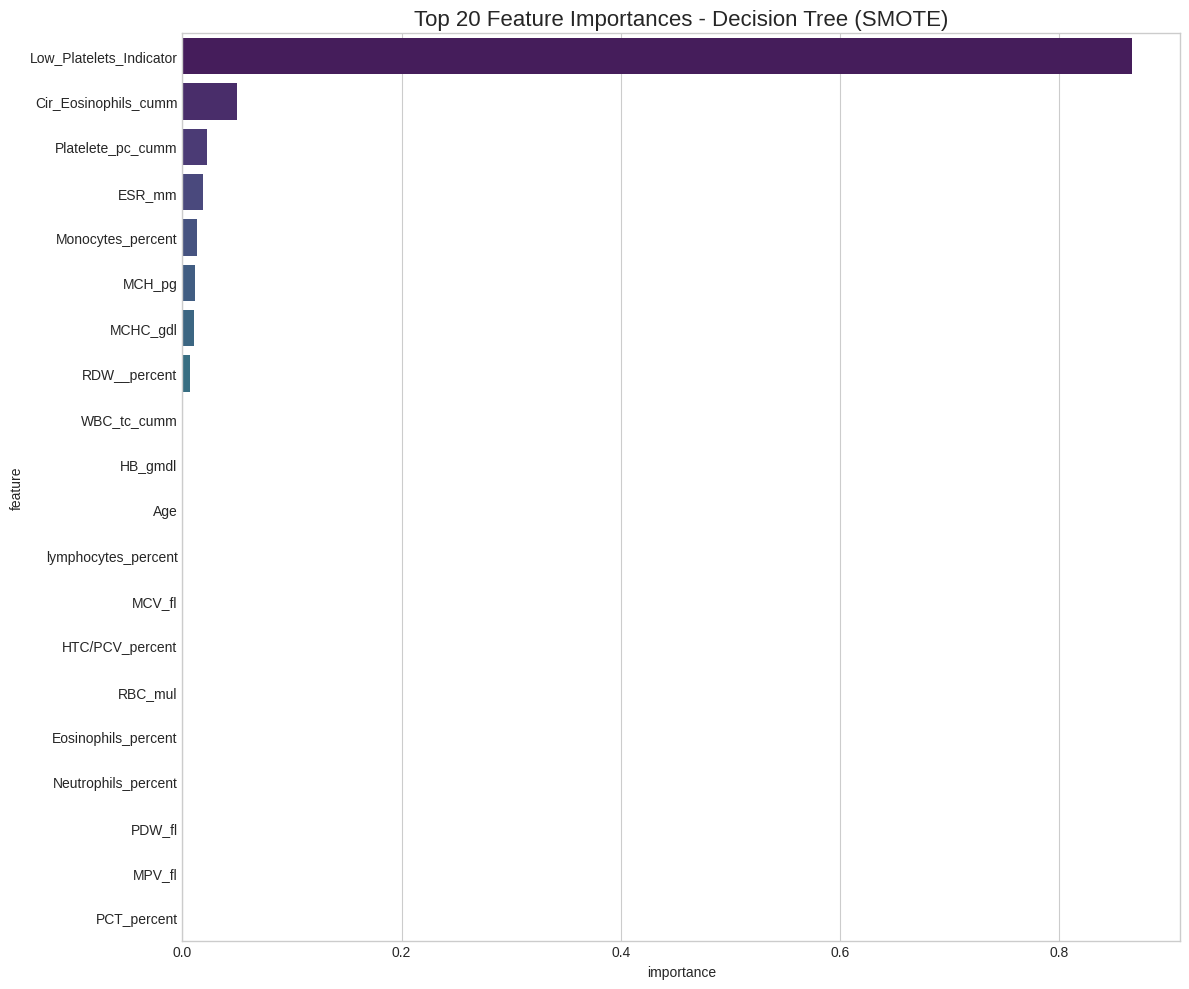



--- Evaluating: Random Forest (with SMOTE training data) ---
Accuracy (with SMOTE): 0.9760
Precision (with SMOTE): 0.9200
Recall (with SMOTE): 0.9583
F1-Score (with SMOTE): 0.9388
ROC AUC (with SMOTE): 0.9930
Classification Report (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99       101
    Positive       0.92      0.96      0.94        24

    accuracy                           0.98       125
   macro avg       0.96      0.97      0.96       125
weighted avg       0.98      0.98      0.98       125


Plots for Random Forest (with SMOTE training data):


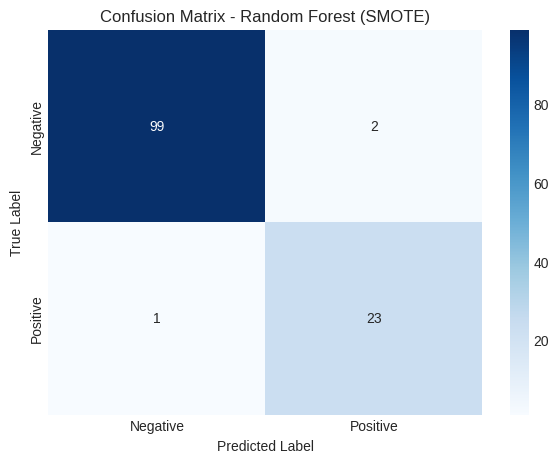

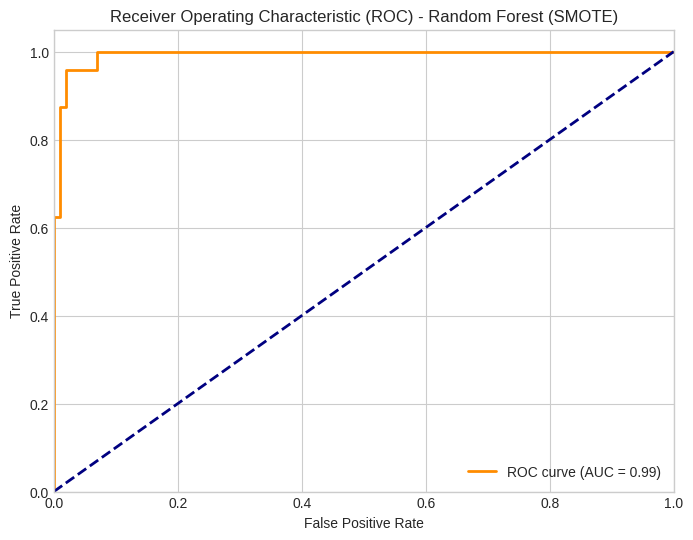

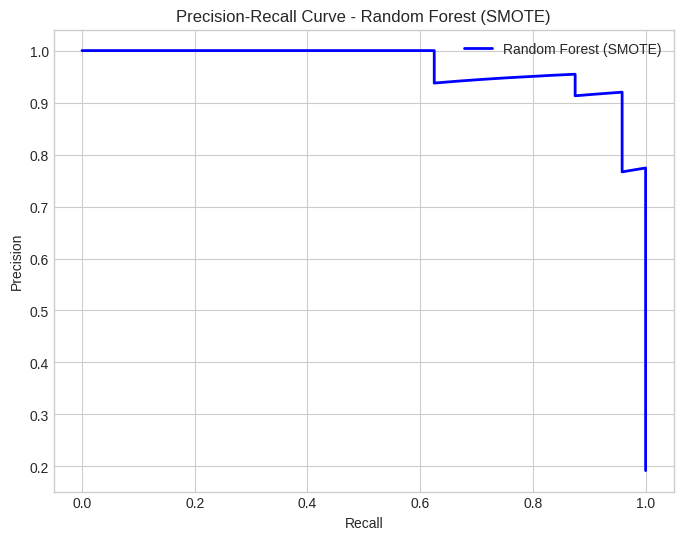

<ipython-input-49-5f5000814e81>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df_smote, palette='viridis')


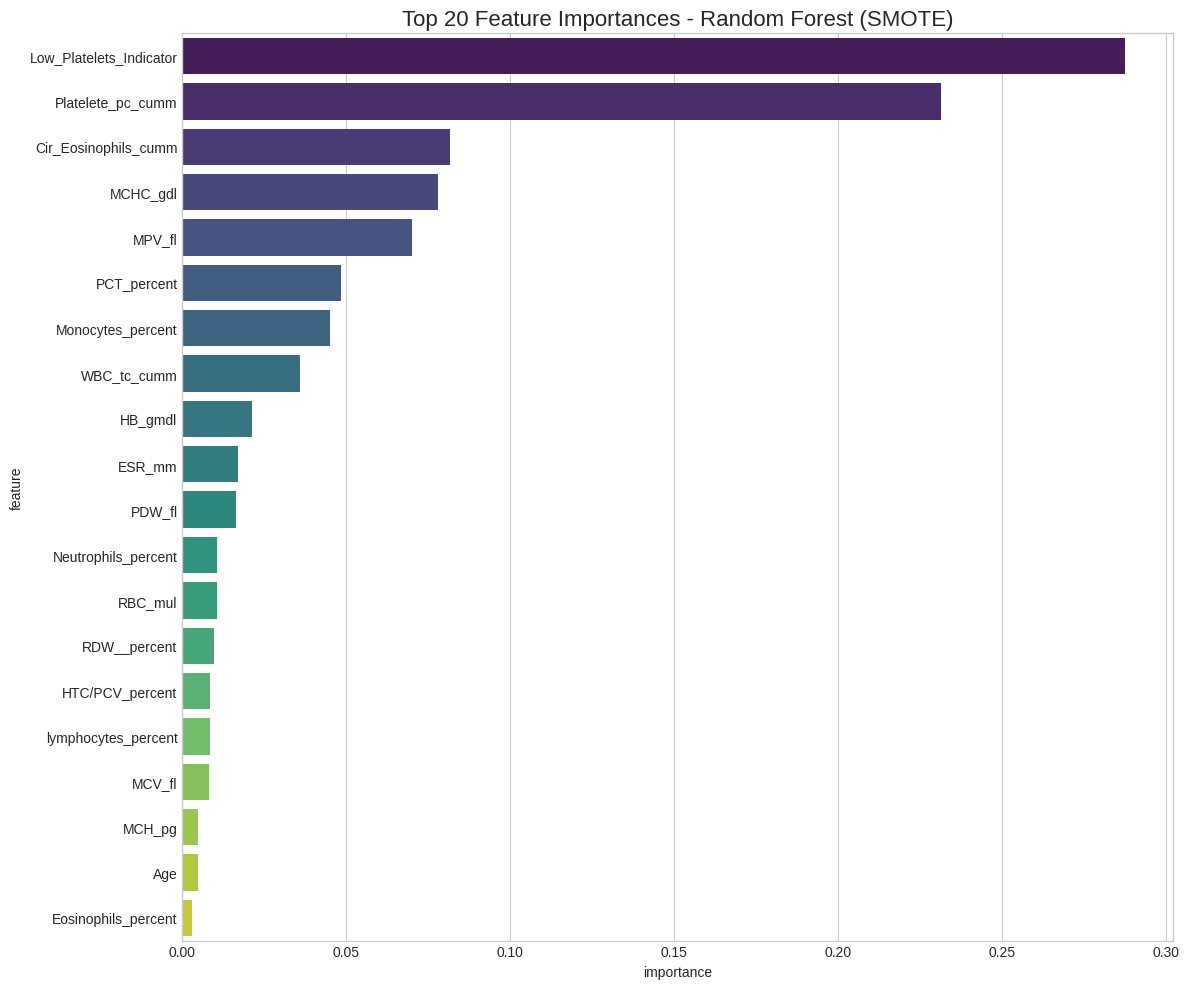



--- Evaluating: Gradient Boosting (with SMOTE training data) ---
Accuracy (with SMOTE): 0.9680
Precision (with SMOTE): 0.8846
Recall (with SMOTE): 0.9583
F1-Score (with SMOTE): 0.9200
ROC AUC (with SMOTE): 0.9860
Classification Report (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       101
    Positive       0.88      0.96      0.92        24

    accuracy                           0.97       125
   macro avg       0.94      0.96      0.95       125
weighted avg       0.97      0.97      0.97       125


Plots for Gradient Boosting (with SMOTE training data):


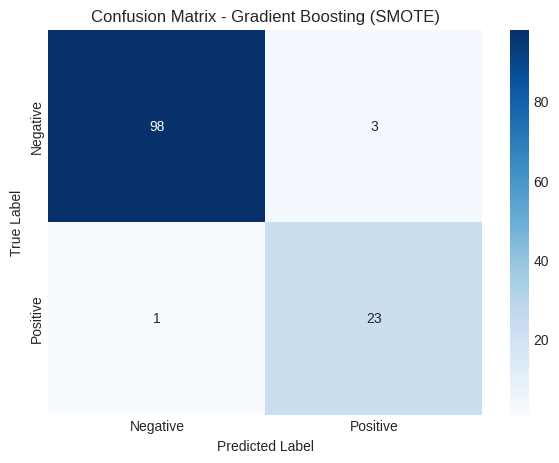

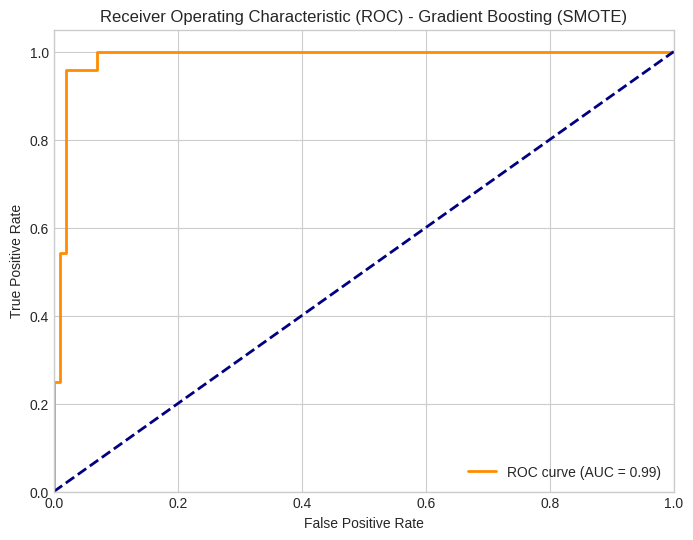

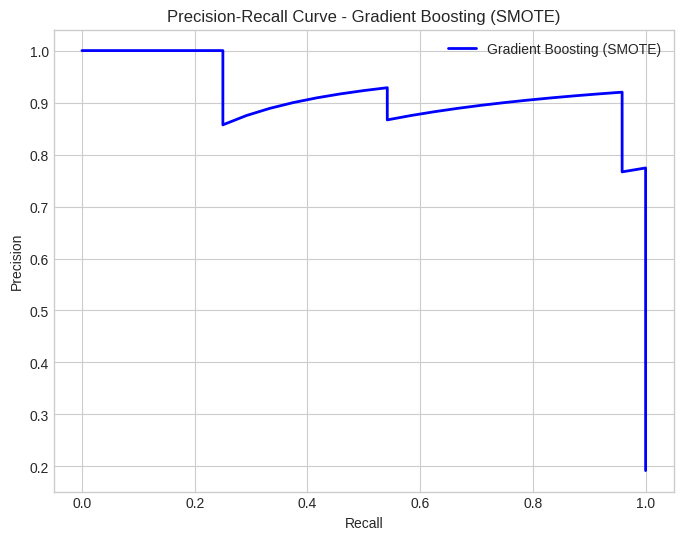

<ipython-input-49-5f5000814e81>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df_smote, palette='viridis')


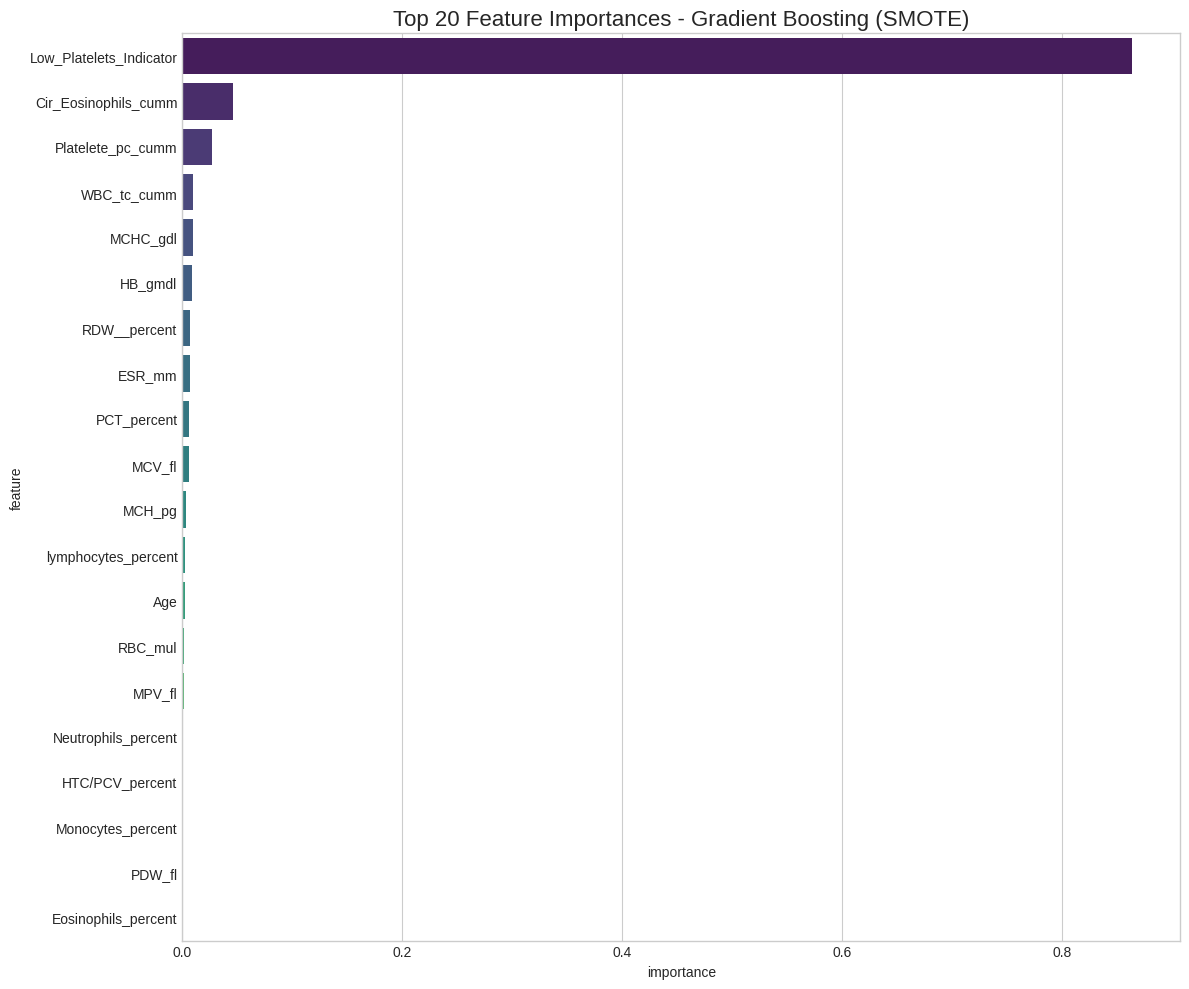



--- Evaluating: AdaBoost (with SMOTE training data) ---
Accuracy (with SMOTE): 0.9600
Precision (with SMOTE): 0.8519
Recall (with SMOTE): 0.9583
F1-Score (with SMOTE): 0.9020
ROC AUC (with SMOTE): 0.9790
Classification Report (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.99      0.96      0.97       101
    Positive       0.85      0.96      0.90        24

    accuracy                           0.96       125
   macro avg       0.92      0.96      0.94       125
weighted avg       0.96      0.96      0.96       125


Plots for AdaBoost (with SMOTE training data):


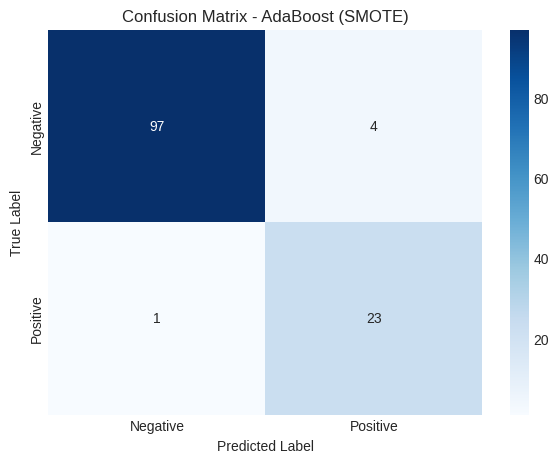

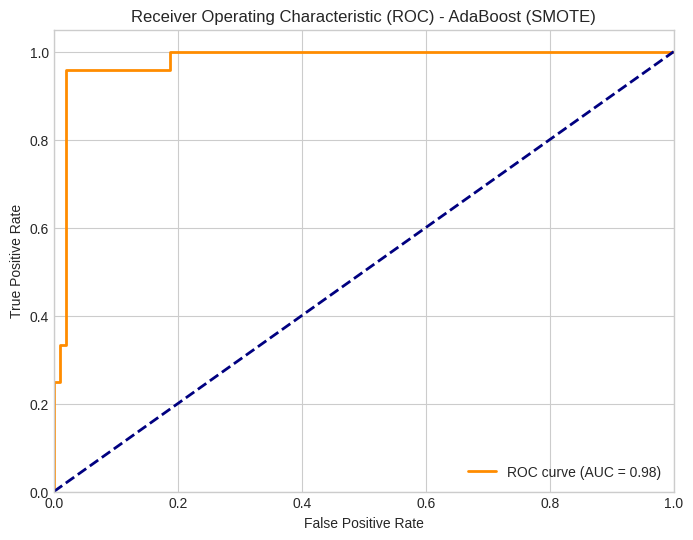

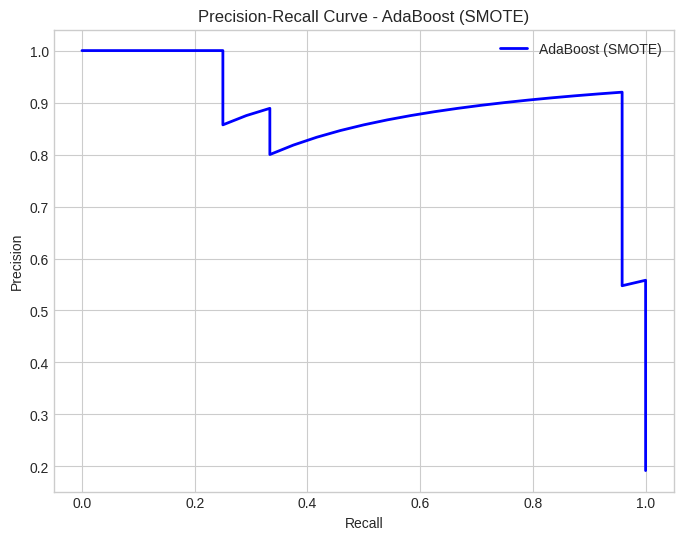

<ipython-input-49-5f5000814e81>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df_smote, palette='viridis')


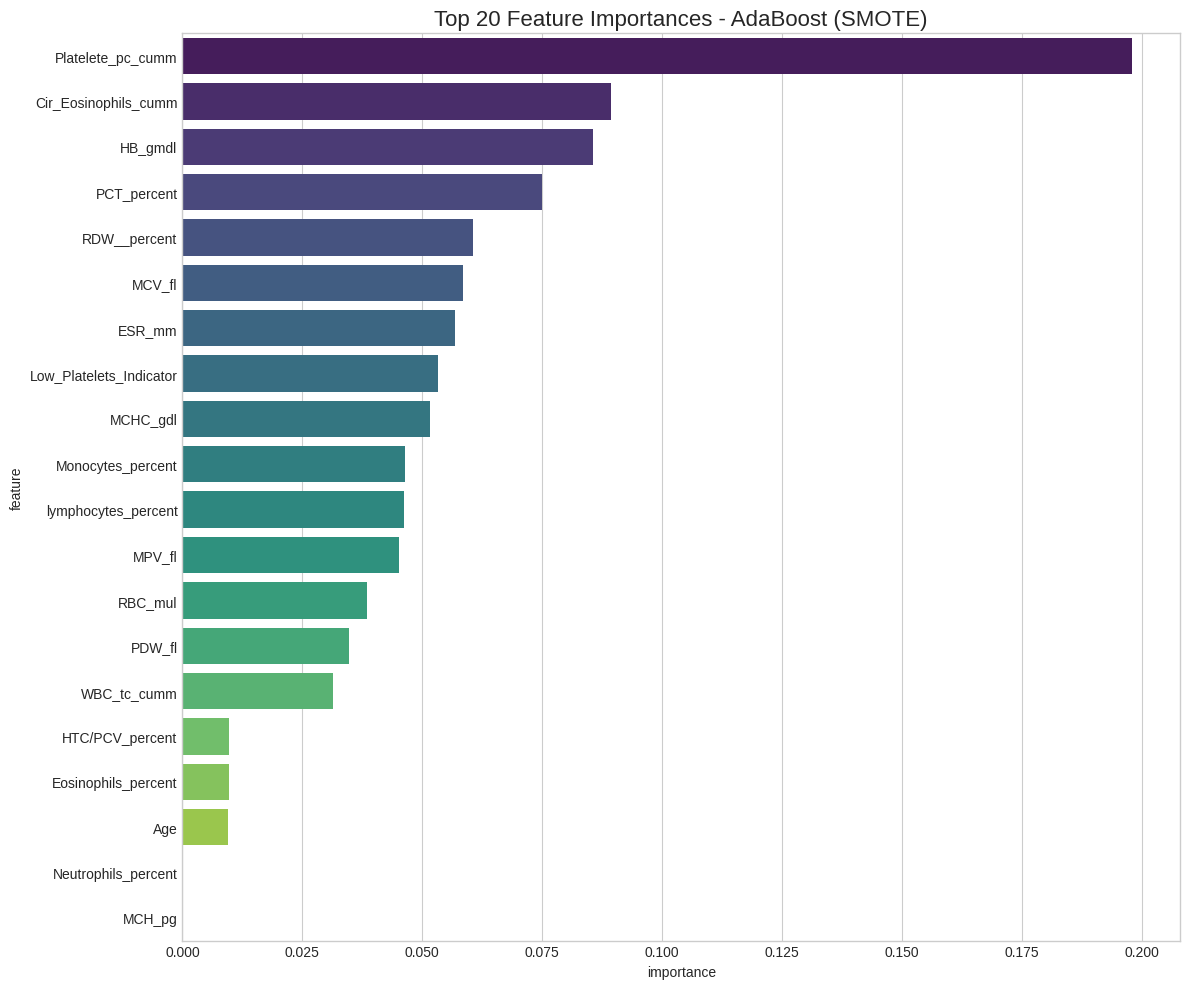



--- Evaluating: Gaussian Naive Bayes (with SMOTE training data) ---
Accuracy (with SMOTE): 0.9360
Precision (with SMOTE): 0.7667
Recall (with SMOTE): 0.9583
F1-Score (with SMOTE): 0.8519
ROC AUC (with SMOTE): 0.9678
Classification Report (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.99      0.93      0.96       101
    Positive       0.77      0.96      0.85        24

    accuracy                           0.94       125
   macro avg       0.88      0.94      0.91       125
weighted avg       0.95      0.94      0.94       125


Plots for Gaussian Naive Bayes (with SMOTE training data):


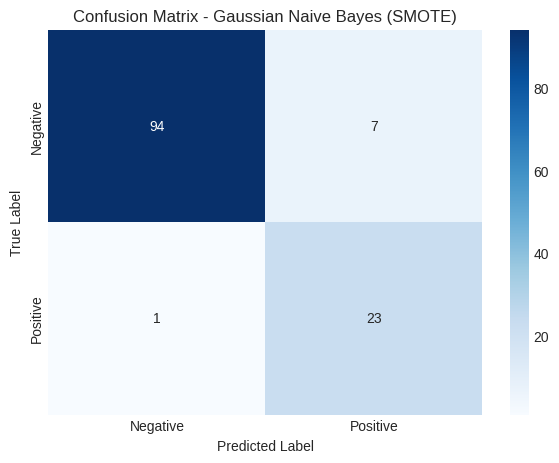

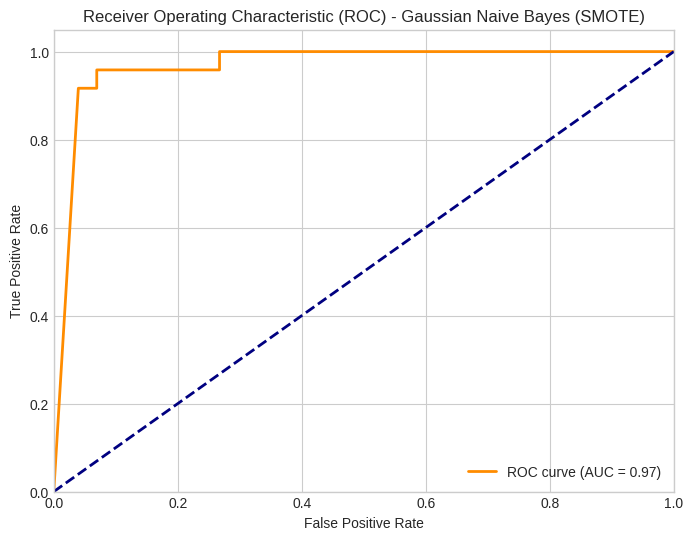

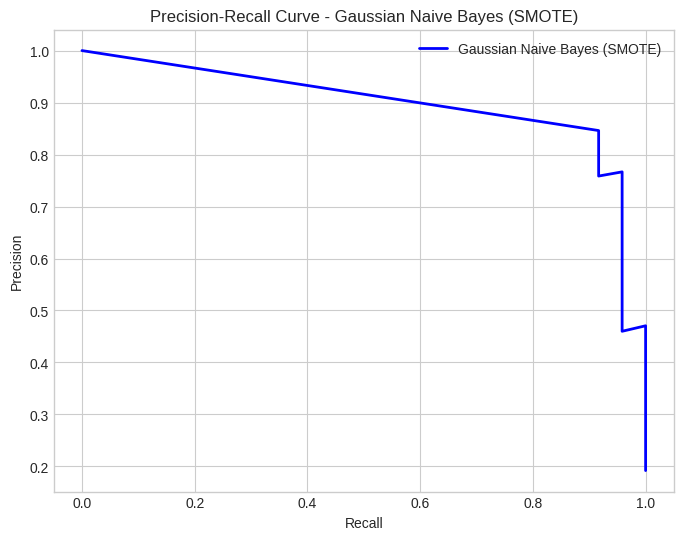



--- Evaluating: XGBoost (with SMOTE training data) ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:09:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (with SMOTE): 0.9680
Precision (with SMOTE): 0.8846
Recall (with SMOTE): 0.9583
F1-Score (with SMOTE): 0.9200
ROC AUC (with SMOTE): 0.9829
Classification Report (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.99      0.97      0.98       101
    Positive       0.88      0.96      0.92        24

    accuracy                           0.97       125
   macro avg       0.94      0.96      0.95       125
weighted avg       0.97      0.97      0.97       125


Plots for XGBoost (with SMOTE training data):


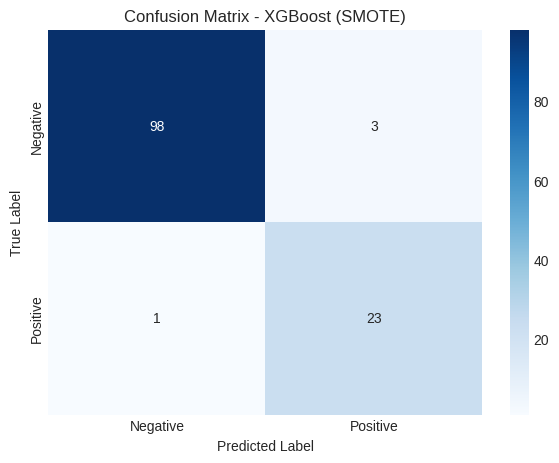

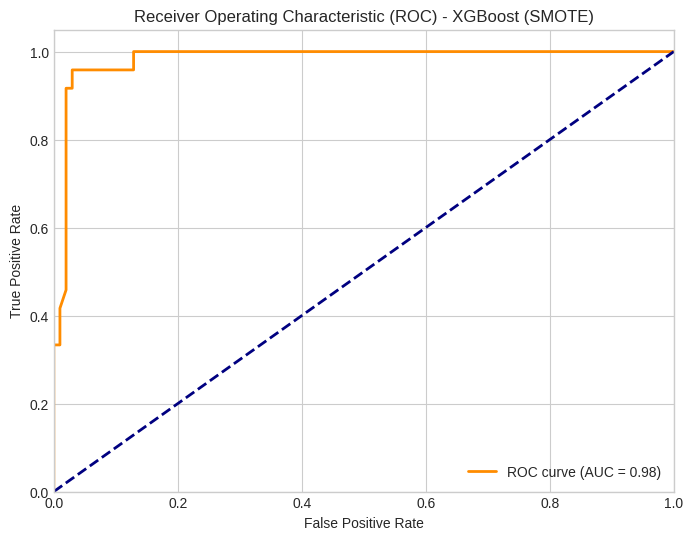

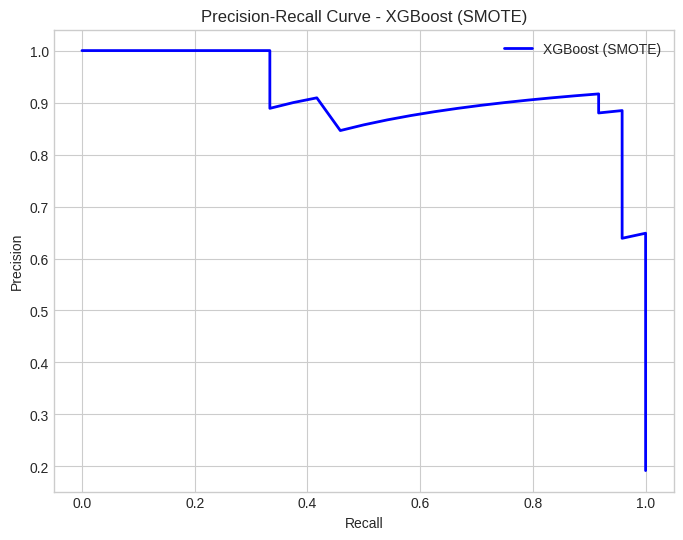

<ipython-input-49-5f5000814e81>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df_smote, palette='viridis')


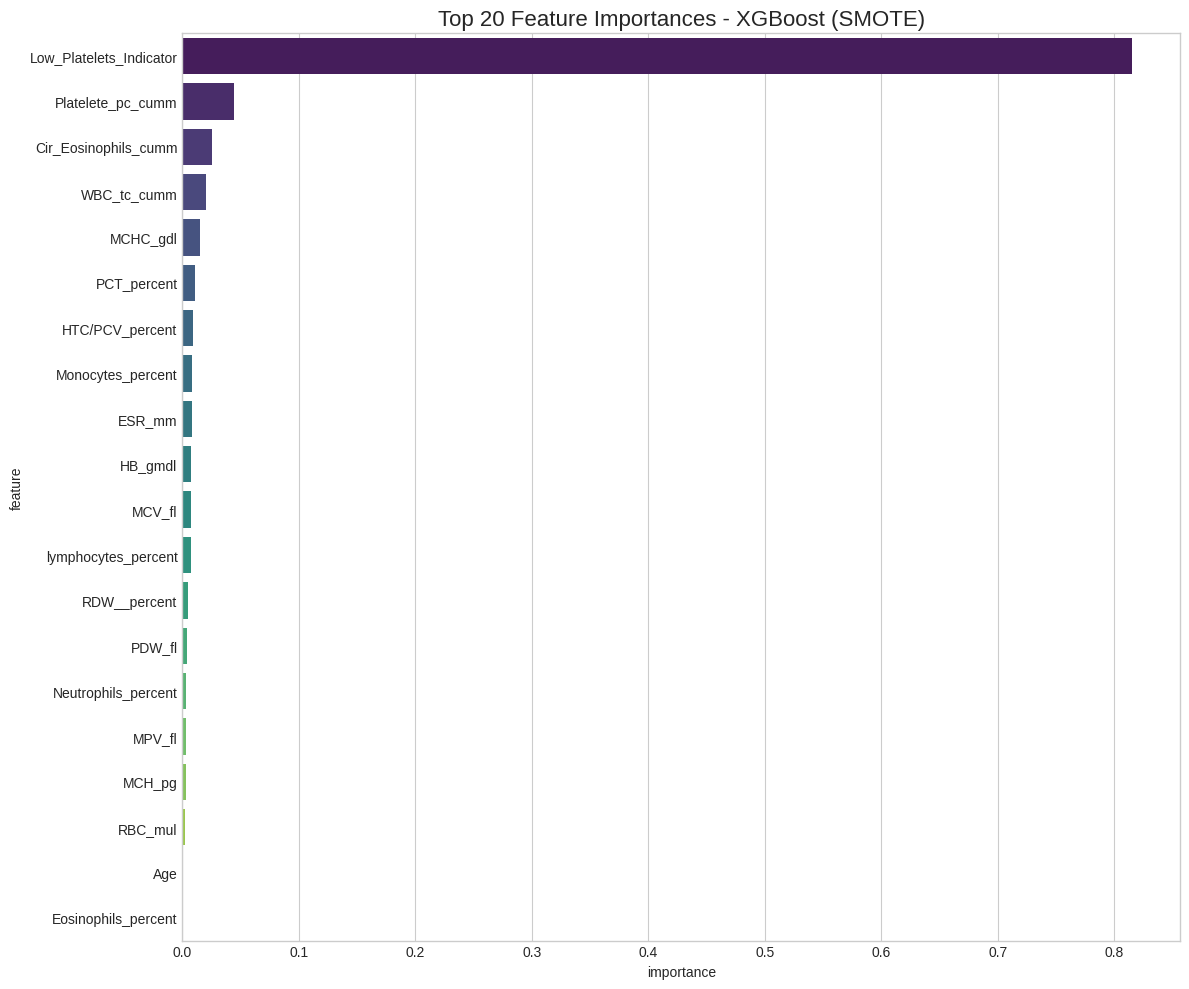



--- Overall Model Performance Summary (After Training with SMOTE) ---
                        Accuracy  Precision    Recall  F1-Score   ROC AUC
Random Forest              0.976   0.920000  0.958333  0.938776  0.992987
Gradient Boosting          0.968   0.884615  0.958333  0.920000  0.985974
XGBoost                    0.968   0.884615  0.958333  0.920000  0.982880
AdaBoost                   0.960   0.851852  0.958333  0.901961  0.978960
Logistic Regression        0.960   0.851852  0.958333  0.901961  0.969059
Gaussian Naive Bayes       0.936   0.766667  0.958333  0.851852  0.967822
Support Vector Machine     0.968   0.884615  0.958333  0.920000  0.964934
Decision Tree              0.952   0.875000  0.875000  0.875000  0.920173
K-Nearest Neighbors        0.896   0.677419  0.875000  0.763636  0.915017


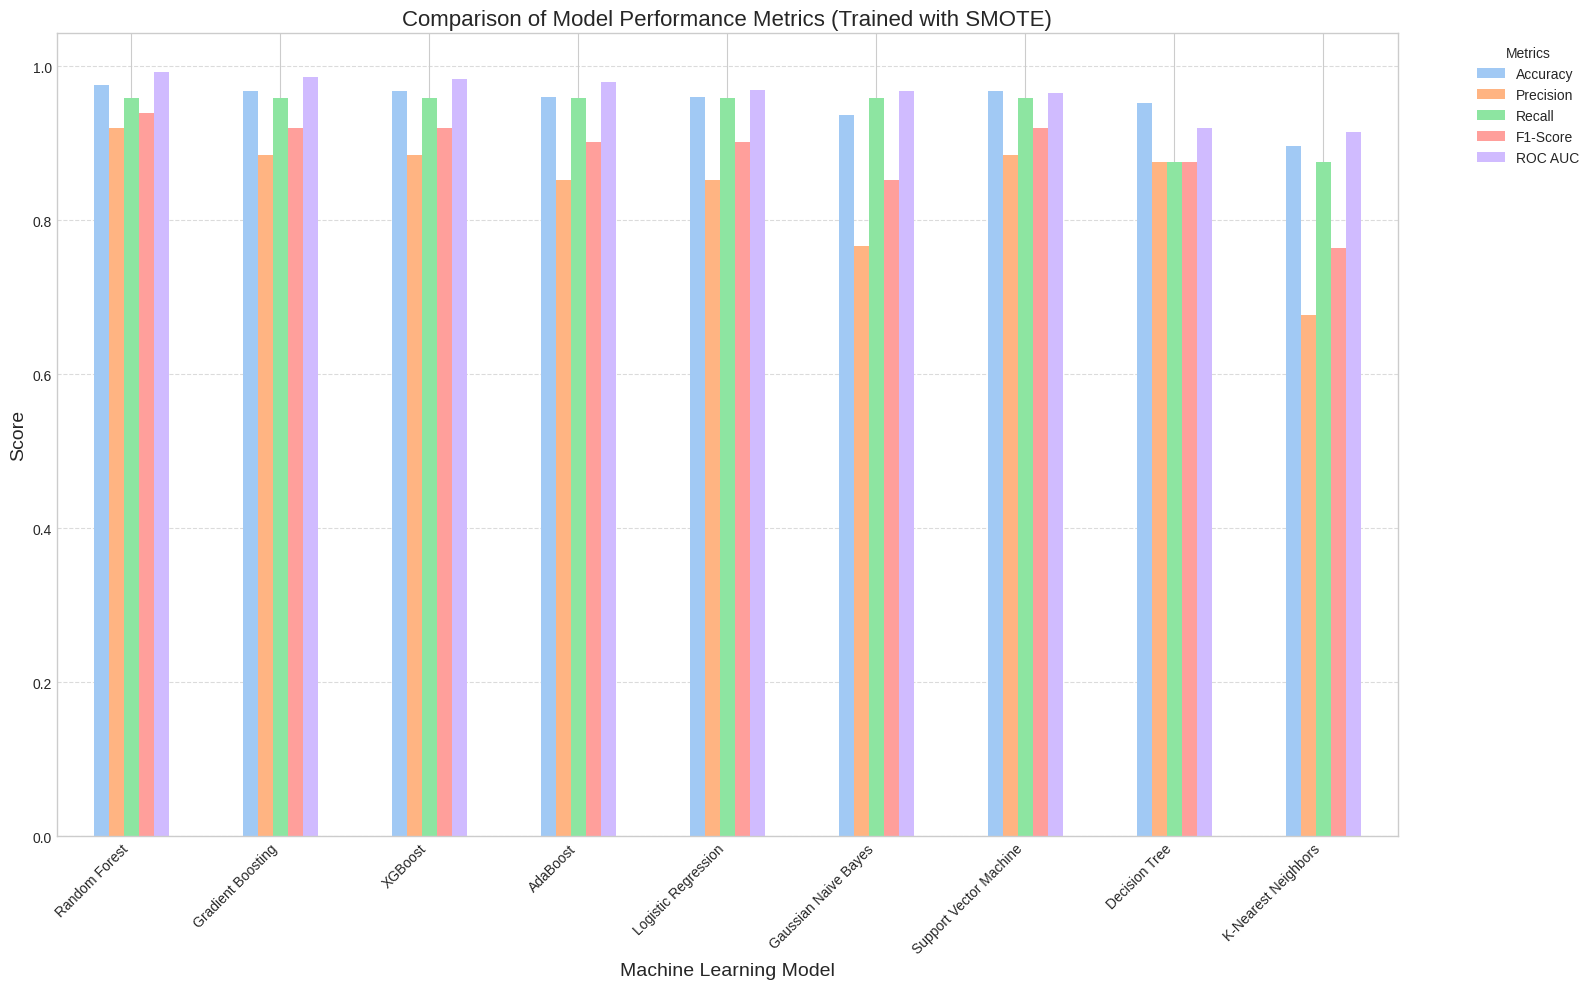



--- Comparison: Original vs. SMOTE ---

Original Performance Summary:
                        Accuracy  Precision    Recall  F1-Score   ROC AUC
Gradient Boosting          0.968   0.884615  0.958333  0.920000  0.991749
Random Forest              0.976   0.920000  0.958333  0.938776  0.990718
AdaBoost                   0.976   0.920000  0.958333  0.938776  0.987417
XGBoost                    0.968   0.884615  0.958333  0.920000  0.985355
Support Vector Machine     0.968   0.884615  0.958333  0.920000  0.974835
Logistic Regression        0.960   0.851852  0.958333  0.901961  0.971122
Gaussian Naive Bayes       0.936   0.766667  0.958333  0.851852  0.966997
Decision Tree              0.968   0.916667  0.916667  0.916667  0.948020
K-Nearest Neighbors        0.928   0.800000  0.833333  0.816327  0.920380

Performance Summary after SMOTE:
                        Accuracy  Precision    Recall  F1-Score   ROC AUC
Random Forest              0.976   0.920000  0.958333  0.938776  0.992987
Gradie

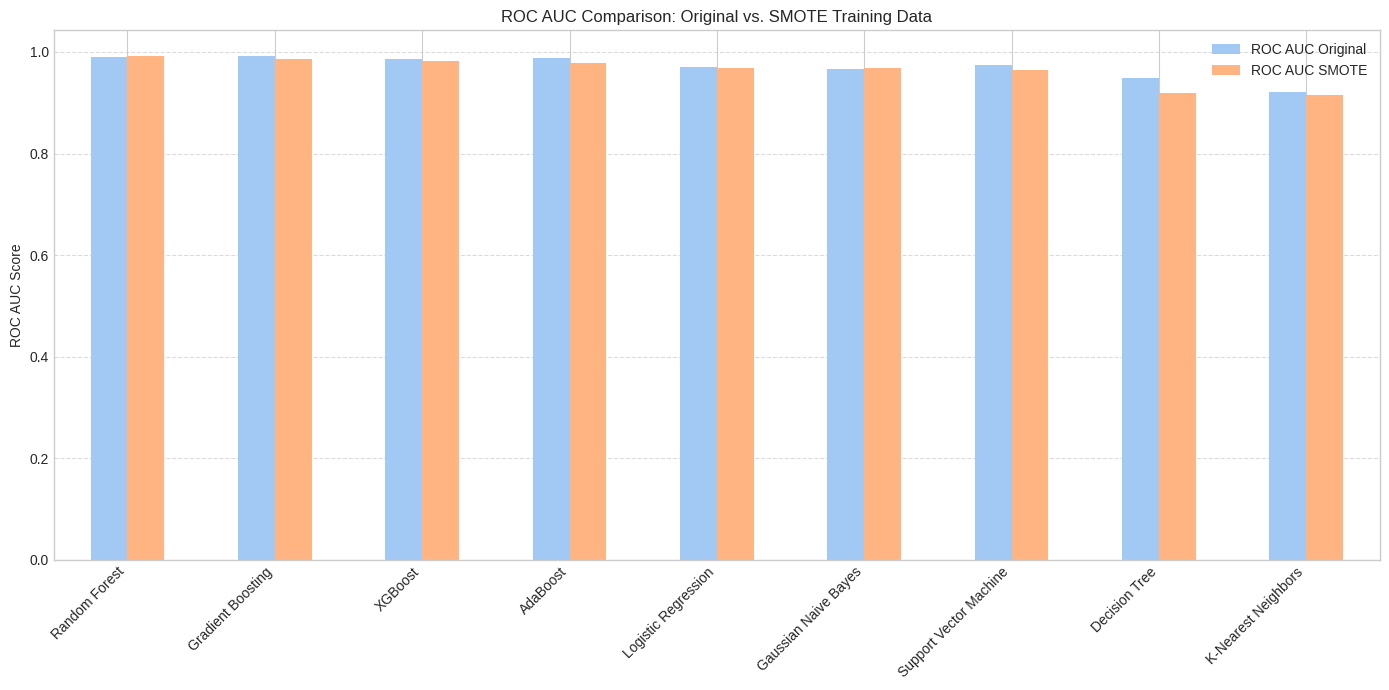

In [ ]:
from collections import Counter
if imblearn:
    from imblearn.over_sampling import SMOTE
else:
    print("SMOTE cannot be applied as imbalanced-learn library is not available.")

print("\n--- Applying SMOTE to Address Class Imbalance (if any) ---")
print(f"Original training set shape: {X_train_scaled.shape}")
print(f"Original training target distribution: {Counter(y_train)}")


X_train_smote, y_train_smote = X_train_scaled, y_train

if imblearn:
    try:
        smote = SMOTE(random_state=42)

        X_train_smote_np, y_train_smote_np = smote.fit_resample(X_train_scaled.values if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled, y_train)


        X_train_smote = pd.DataFrame(X_train_smote_np, columns=X_train.columns)
        y_train_smote = pd.Series(y_train_smote_np, name=y_train.name)

        print(f"\nTraining set shape after SMOTE: {X_train_smote.shape}")
        print(f"Training target distribution after SMOTE: {Counter(y_train_smote)}")
        print("SMOTE applied successfully to the training data.")
    except Exception as e:
        print(f"Error applying SMOTE: {e}")
        print("Using original training data for model training.")

else:
    print("Skipping SMOTE application as imbalanced-learn is not available.")



model_performance_summary_smote = {}

print("\n\n--- Re-evaluating Models with SMOTE-augmented Training Data ---")


for model_name, model_instance in models_dict.items():
    print(f"\n\n--- Evaluating: {model_name} (with SMOTE training data) ---")


    model_instance.fit(X_train_smote, y_train_smote)


    y_pred_test_smote = model_instance.predict(X_test_scaled)
    y_pred_proba_test_smote = model_instance.predict_proba(X_test_scaled)[:, 1] if hasattr(model_instance, "predict_proba") else None


    accuracy_smote = accuracy_score(y_test, y_pred_test_smote)
    precision_smote = precision_score(y_test, y_pred_test_smote, average='binary', zero_division=0)
    recall_smote = recall_score(y_test, y_pred_test_smote, average='binary', zero_division=0)
    f1_smote = f1_score(y_test, y_pred_test_smote, average='binary', zero_division=0)
    roc_auc_smote = roc_auc_score(y_test, y_pred_proba_test_smote) if y_pred_proba_test_smote is not None else 'N/A'

    report_smote = classification_report(y_test, y_pred_test_smote, zero_division=0,
                                         target_names=label_encoder_target.classes_ if 'label_encoder_target' in locals() else ['Class 0', 'Class 1'])

    model_performance_summary_smote[model_name] = {
        'Accuracy': accuracy_smote,
        'Precision': precision_smote,
        'Recall': recall_smote,
        'F1-Score': f1_smote,
        'ROC AUC': roc_auc_smote if roc_auc_smote != 'N/A' else 0
    }
    print(f"Accuracy (with SMOTE): {accuracy_smote:.4f}")
    print(f"Precision (with SMOTE): {precision_smote:.4f}")
    print(f"Recall (with SMOTE): {recall_smote:.4f}")
    print(f"F1-Score (with SMOTE): {f1_smote:.4f}")
    if roc_auc_smote != 'N/A': print(f"ROC AUC (with SMOTE): {roc_auc_smote:.4f}")
    print("Classification Report (with SMOTE):")
    print(report_smote)


    print(f"\nPlots for {model_name} (with SMOTE training data):")
    plot_confusion_matrix_custom(y_test, y_pred_test_smote, f"{model_name} (SMOTE)")
    if y_pred_proba_test_smote is not None:
        plot_roc_curve_custom(y_test, y_pred_proba_test_smote, f"{model_name} (SMOTE)")
        plot_precision_recall_curve_custom(y_test, y_pred_proba_test_smote, f"{model_name} (SMOTE)")


    if hasattr(model_instance, 'feature_importances_'):
        importances_smote = model_instance.feature_importances_
        feature_names_smote = X_train_smote.columns
        feature_importance_df_smote = pd.DataFrame({'feature': feature_names_smote, 'importance': importances_smote})
        feature_importance_df_smote = feature_importance_df_smote.sort_values(by='importance', ascending=False).head(20)

        plt.figure(figsize=(12, 10))
        sns.barplot(x='importance', y='feature', data=feature_importance_df_smote, palette='viridis')
        plt.title(f'Top 20 Feature Importances - {model_name} (SMOTE)', fontsize=16)
        plt.tight_layout()
        plt.show()
    elif hasattr(model_instance, 'coef_') and model_name == "Logistic Regression" and model_instance.coef_.shape[0] == 1:
        importances_smote_lr = model_instance.coef_[0]
        feature_names_smote_lr = X_train_smote.columns
        feature_importance_df_smote_lr = pd.DataFrame({'feature': feature_names_smote_lr, 'coefficient': importances_smote_lr})
        feature_importance_df_smote_lr['abs_coefficient'] = np.abs(feature_importance_df_smote_lr['coefficient'])
        feature_importance_df_smote_lr = feature_importance_df_smote_lr.sort_values(by='abs_coefficient', ascending=False).head(20)

        plt.figure(figsize=(12, 10))
        sns.barplot(x='coefficient', y='feature', data=feature_importance_df_smote_lr, palette='coolwarm_r')
        plt.title(f'Top 20 Feature Coefficients - {model_name} (SMOTE)', fontsize=16)
        plt.tight_layout()
        plt.show()



print("\n\n--- Overall Model Performance Summary (After Training with SMOTE) ---")
performance_summary_df_smote = pd.DataFrame(model_performance_summary_smote).T
performance_summary_df_smote = performance_summary_df_smote.sort_values(by='ROC AUC', ascending=False)

print(performance_summary_df_smote)


plt.figure(figsize=(16, 10))
performance_summary_df_smote[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']].plot(kind='bar', ax=plt.gca())
plt.title('Comparison of Model Performance Metrics (Trained with SMOTE)', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Machine Learning Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


if 'performance_summary_df' in locals():
    print("\n\n--- Comparison: Original vs. SMOTE ---")
    print("\nOriginal Performance Summary:")
    print(performance_summary_df)
    print("\nPerformance Summary after SMOTE:")
    print(performance_summary_df_smote)


    comparison_roc_auc = pd.DataFrame({
        'ROC AUC Original': performance_summary_df['ROC AUC'],
        'ROC AUC SMOTE': performance_summary_df_smote['ROC AUC']
    }).sort_values(by='ROC AUC SMOTE', ascending=False)

    comparison_roc_auc.plot(kind='bar', figsize=(14, 7))
    plt.title('ROC AUC Comparison: Original vs. SMOTE Training Data')
    plt.ylabel('ROC AUC Score')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# SHAP , LIME ,xAI

In [ ]:
%pip install shap

In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bb2a5ecf9770b1d559a5e26a8afd4bc63e376047c50e017b4dfc46e5d401621e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:

import shap
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Ensure this is imported


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
target_names_for_report = ['Class 0', 'Class 1']

In [ ]:

print("--- Initializing SHAP TreeExplainer and Calculating SHAP values for Random Forest ---")


explainer_shap_rf = shap.TreeExplainer(rf_model, X_train_scaled)


if isinstance(X_test_scaled, pd.DataFrame):
    X_test_shap_df = X_test_scaled.head(100).copy()
else:
    feature_names_for_shap = X_train.columns.tolist() if isinstance(X_train, pd.DataFrame) else [f"feature_{i}" for i in range(X_test_scaled.shape[1])]
    X_test_shap_df = pd.DataFrame(X_test_scaled[:100,:], columns=feature_names_for_shap)


print("Calculating SHAP values with check_additivity=False...")
shap_values_rf_list = explainer_shap_rf.shap_values(X_test_shap_df, check_additivity=False)


shap_values_rf_positive_class = shap_values_rf_list[1]


expected_value_rf_positive_class = explainer_shap_rf.expected_value[1]

print("SHAP values calculated for Random Forest.")
print(f"Shape of SHAP values for positive class: {shap_values_rf_positive_class.shape}")
print(f"Expected value (base value) for positive class: {expected_value_rf_positive_class}")


--- Initializing SHAP TreeExplainer and Calculating SHAP values for Random Forest ---
Calculating SHAP values with check_additivity=False...
SHAP values calculated for Random Forest.
Shape of SHAP values for positive class: (20, 2)
Expected value (base value) for positive class: 0.20010000000000008


In [ ]:

print("\n--- SHAP Force Plot (Instance 0) for Random Forest ---")
instance_index_force_rf = 0


shap_values_for_plot = shap_values_rf_positive_class[instance_index_force_rf,:]


feature_values_for_plot = X_test_shap_df.iloc[instance_index_force_rf,:].values


feature_names_for_plot = X_test_shap_df.columns.tolist()


print(f"Base value: {expected_value_rf_positive_class}")
print(f"Shape of SHAP values for plot: {shap_values_for_plot.shape}")
print(f"Number of SHAP values for plot: {len(shap_values_for_plot)}")
print(f"Shape of feature values for plot: {feature_values_for_plot.shape}")
print(f"Number of feature values for plot: {len(feature_values_for_plot)}")
print(f"Number of feature names: {len(feature_names_for_plot)}")


if len(shap_values_for_plot) == len(feature_values_for_plot) == len(feature_names_for_plot):
    print("Dimensions match. Proceeding to plot...")
    plt.figure()
    shap.force_plot(expected_value_rf_positive_class,
                    shap_values_for_plot,
                    feature_values_for_plot,
                    feature_names=feature_names_for_plot,
                    matplotlib=True,
                    show=False)
    plt.title(f"SHAP Force Plot (Instance {instance_index_force_rf}) - Random Forest", y=1.05)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
else:
    print("ERROR: Dimension mismatch detected between SHAP values, feature values, or feature names.")
    print(f"  Length of SHAP values: {len(shap_values_for_plot)}")
    print(f"  Length of feature values: {len(feature_values_for_plot)}")
    print(f"  Length of feature names: {len(feature_names_for_plot)}")
    print("Please check the data preparation for X_test_shap_df and ensure it matches the data used for explainer.shap_values().")




--- SHAP Force Plot (Instance 0) for Random Forest ---
Base value: 0.20010000000000008
Shape of SHAP values for plot: (2,)
Number of SHAP values for plot: 2
Shape of feature values for plot: (20,)
Number of feature values for plot: 20
Number of feature names: 20
ERROR: Dimension mismatch detected between SHAP values, feature values, or feature names.
  Length of SHAP values: 2
  Length of feature values: 20
  Length of feature names: 20
Please check the data preparation for X_test_shap_df and ensure it matches the data used for explainer.shap_values().



--- SHAP Explanations for Random Forest ---
Initializing SHAP TreeExplainer...
Calculating SHAP values for 100 samples and 20 features.
Using check_additivity=False...
Shape of SHAP values for positive class for plots: (100, 20)
Shape of data for plots (X_test_shap_df): (100, 20)
Scalar expected value for positive class for plots: 0.20010000000000008

SHAP Force Plot (Instance 0) for Random Forest:
Force plot base value shape: ()
Force plot SHAP values shape: (20,)
Force plot features shape: (20,)


<Figure size 1000x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

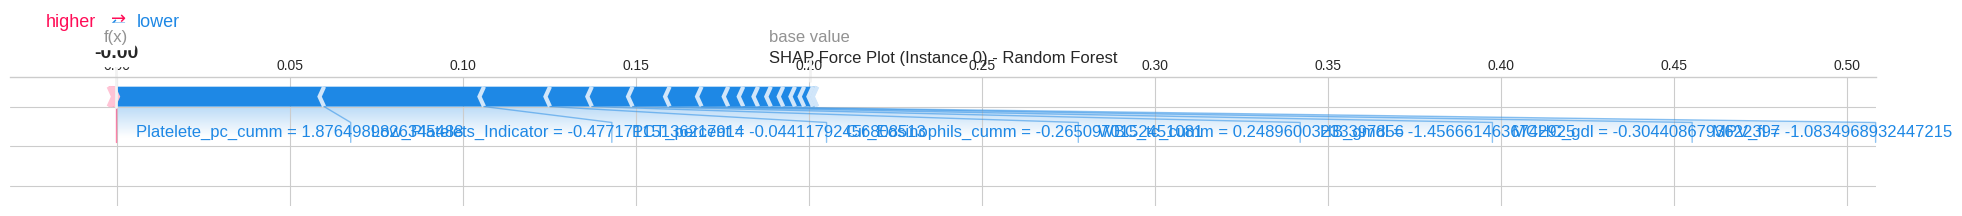


SHAP Summary Plot (Beeswarm) for Random Forest:


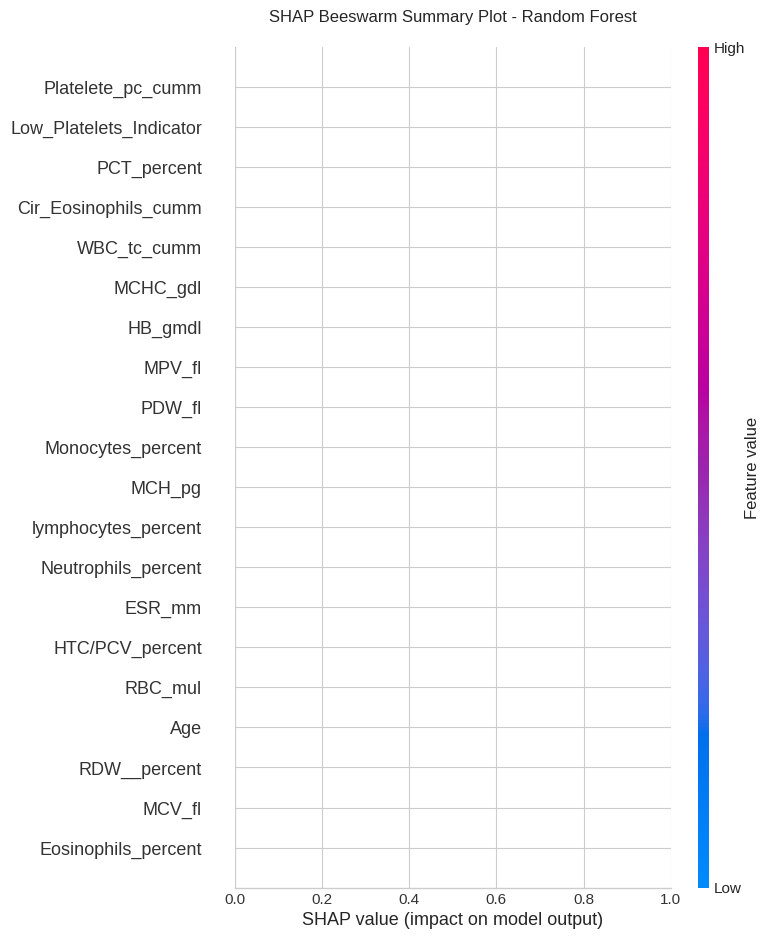


SHAP Summary Plot (Bar) for Random Forest:


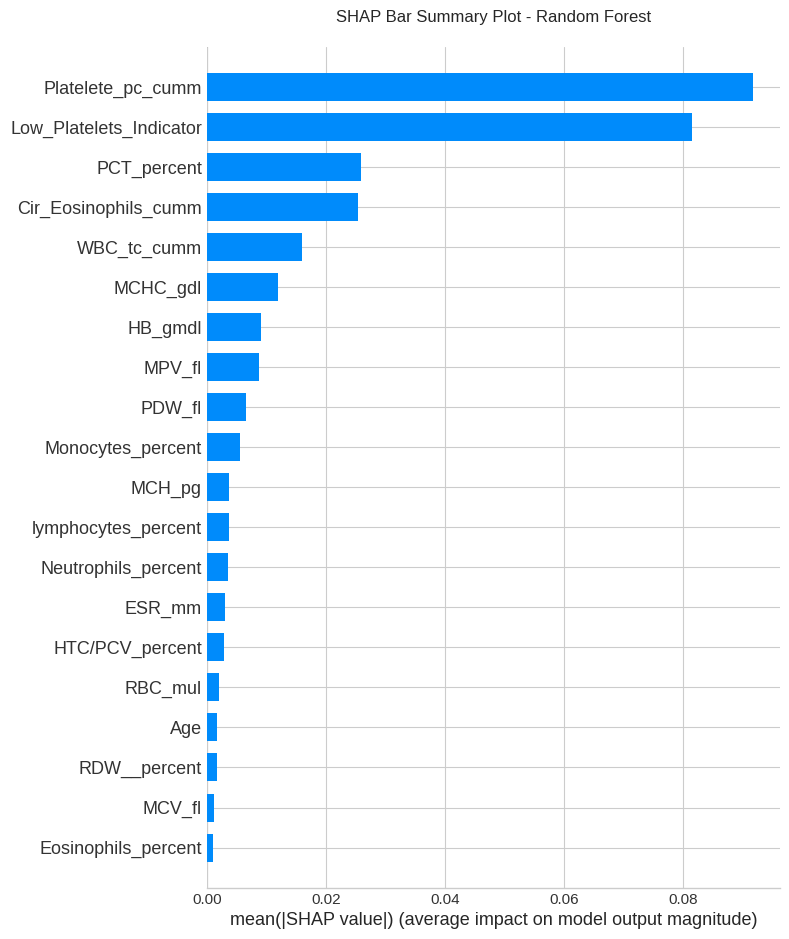


SHAP Waterfall Plot (Instance 0) for Random Forest:


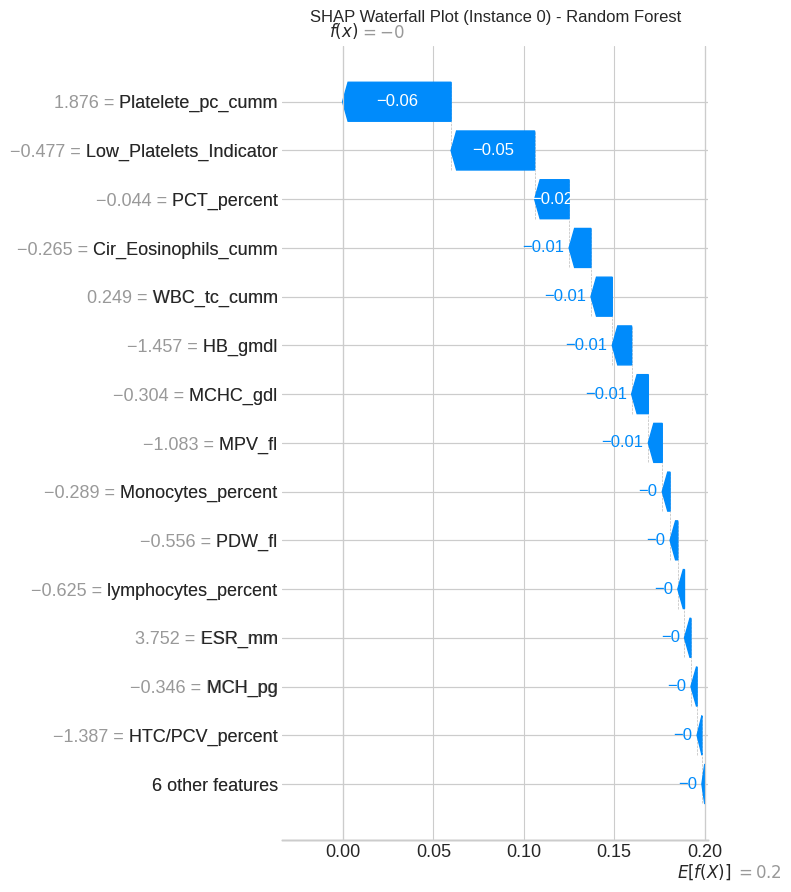

In [ ]:

print(f"\n--- SHAP Explanations for {model_name_rf} ---")
try:

    print("Initializing SHAP TreeExplainer...")

    if isinstance(X_train_scaled, np.ndarray) and isinstance(X_train, pd.DataFrame):
        background_data_shap = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    elif isinstance(X_train_scaled, pd.DataFrame):
        background_data_shap = X_train_scaled
    else:
        background_data_shap = X_train_scaled

    explainer_shap_rf = shap.TreeExplainer(rf_model, background_data_shap)


    if isinstance(X_test_scaled, pd.DataFrame):
        X_test_shap_df = X_test_scaled.head(100).copy()
    else:
        if isinstance(X_train, pd.DataFrame) and X_train.shape[1] == X_test_scaled.shape[1]:
            feature_names_for_shap = X_train.columns.tolist()
        elif isinstance(background_data_shap, pd.DataFrame) and background_data_shap.shape[1] == X_test_scaled.shape[1]:
            feature_names_for_shap = background_data_shap.columns.tolist()
        else:
            feature_names_for_shap = [f"feature_{i}" for i in range(X_test_scaled.shape[1])]
        X_test_shap_df = pd.DataFrame(X_test_scaled[:100,:], columns=feature_names_for_shap)



    print(f"Calculating SHAP values for {X_test_shap_df.shape[0]} samples and {X_test_shap_df.shape[1]} features.")
    print("Using check_additivity=False...")

    shap_explanation_object = explainer_shap_rf(X_test_shap_df, check_additivity=False)



    if len(shap_explanation_object.values.shape) == 3 and shap_explanation_object.values.shape[2] == 2:

        shap_values_positive_class_for_plots = shap_explanation_object.values[:,:,1]
        expected_value_positive_class_for_plots = shap_explanation_object.base_values[0,1]
    else:

        shap_values_positive_class_for_plots = shap_explanation_object.values
        expected_value_positive_class_for_plots = shap_explanation_object.base_values[0]


    data_for_plots = X_test_shap_df

    print(f"Shape of SHAP values for positive class for plots: {shap_values_positive_class_for_plots.shape}")
    print(f"Shape of data for plots (X_test_shap_df): {data_for_plots.shape}")
    print(f"Scalar expected value for positive class for plots: {expected_value_positive_class_for_plots}")



    print(f"\nSHAP Force Plot (Instance 0) for {model_name_rf}:")
    instance_index = 0

    current_base_value = expected_value_positive_class_for_plots
    current_shap_values = shap_values_positive_class_for_plots[instance_index,:]
    current_features = data_for_plots.iloc[instance_index,:]

    print(f"Force plot base value shape: {np.shape(current_base_value)}")
    print(f"Force plot SHAP values shape: {np.shape(current_shap_values)}")
    print(f"Force plot features shape: {np.shape(current_features)}")

    if len(current_shap_values) == len(current_features):
        plt.figure()
        shap.force_plot(current_base_value,
                        current_shap_values,
                        current_features,
                        matplotlib=True, show=False)
        plt.title(f"SHAP Force Plot (Instance {instance_index}) - {model_name_rf}", y=1.05)
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()
    else:
        print("ERROR: Dimension mismatch for SHAP Force Plot.")


    print(f"\nSHAP Summary Plot (Beeswarm) for {model_name_rf}:")
    plt.figure(figsize=(10,8))
    shap.summary_plot(shap_values_positive_class_for_plots, data_for_plots, plot_type="beeswarm", show=False)
    plt.title(f"SHAP Beeswarm Summary Plot - {model_name_rf}", y=1.02)
    plt.tight_layout()
    plt.show()


    print(f"\nSHAP Summary Plot (Bar) for {model_name_rf}:")
    plt.figure(figsize=(10,8))

    shap.summary_plot(shap_values_positive_class_for_plots, data_for_plots, plot_type="bar", show=False)
    plt.title(f"SHAP Bar Summary Plot - {model_name_rf}", y=1.02)
    plt.tight_layout()
    plt.show()


    print(f"\nSHAP Waterfall Plot (Instance 0) for {model_name_rf}:")
    waterfall_explanation = shap.Explanation(
        values=shap_values_positive_class_for_plots[instance_index,:],
        base_values=expected_value_positive_class_for_plots,
        data=data_for_plots.iloc[instance_index,:].values,
        feature_names=data_for_plots.columns.tolist()
    )
    plt.figure(figsize=(10,8))
    shap.plots.waterfall(waterfall_explanation, max_display=15, show=False)
    plt.title(f"SHAP Waterfall Plot (Instance {instance_index}) - {model_name_rf}", y=1.02)
    plt.tight_layout()
    plt.show()



except Exception as e:
    print(f"Could not generate SHAP explanations for {model_name_rf}: {e}")
    import traceback
    traceback.print_exc()



In [ ]:

print(f"\n--- LIME Explanation for {model_name_rf} (first test instance) ---")
try:

    X_train_lime_rf_np = X_train_scaled.values if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled


    if isinstance(X_train, pd.DataFrame) and X_train.shape[1] == X_train_lime_rf_np.shape[1]:
        feature_names_lime_rf = X_train.columns.tolist()
    elif isinstance(X_train_scaled, pd.DataFrame) and X_train_scaled.shape[1] == X_train_lime_rf_np.shape[1]:
        feature_names_lime_rf = X_train_scaled.columns.tolist()
    else:
        feature_names_lime_rf = [f"feature_{i}" for i in range(X_train_lime_rf_np.shape[1])]

    print(f"LIME training data shape: {X_train_lime_rf_np.shape}")
    print(f"LIME feature names: {feature_names_lime_rf[:5]}... (first 5)")

    lime_explainer_rf = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_lime_rf_np,
        feature_names=feature_names_lime_rf,
        class_names=target_names_for_report,
        mode='classification',
        random_state=42
    )
    print("LIME Explainer initialized.")


    instance_to_explain_idx_lime_rf = 0

    if isinstance(X_test_scaled, pd.DataFrame):
        instance_data_lime_rf_np = X_test_scaled.iloc[instance_to_explain_idx_lime_rf].values
    else:
        instance_data_lime_rf_np = X_test_scaled[instance_to_explain_idx_lime_rf,:]

    print(f"LIME instance data shape: {instance_data_lime_rf_np.shape}")


    def lime_predict_fn_rf(data_as_np_array):

        if feature_names_lime_rf is not None and len(feature_names_lime_rf) == data_as_np_array.shape[1]:
            data_as_df = pd.DataFrame(data_as_np_array, columns=feature_names_lime_rf)
            return rf_model.predict_proba(data_as_df)
        else:
            return rf_model.predict_proba(data_as_np_array)

    explanation_lime_rf = lime_explainer_rf.explain_instance(
        data_row=instance_data_lime_rf_np,
        predict_fn=lime_predict_fn_rf,
        num_features=10,
        top_labels=1
    )

    fig_lime_rf = explanation_lime_rf.as_pyplot_figure()
    fig_lime_rf.suptitle(f"LIME Explanation (Instance {instance_to_explain_idx_lime_rf}) - {model_name_rf}", y=1.02)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not generate LIME explanation for {model_name_rf}: {e}")
    import traceback
    traceback.print_exc()




--- LIME Explanation for Random Forest (first test instance) ---
LIME training data shape: (399, 20)
LIME feature names: ['Age', 'HB_gmdl', 'ESR_mm', 'WBC_tc_cumm', 'Neutrophils_percent']... (first 5)
LIME Explainer initialized.
LIME instance data shape: (20,)
Could not generate LIME explanation for Random Forest: 1


Traceback (most recent call last):
  File "<ipython-input-76-9783c9aa345c>", line 55, in <cell line: 0>
    fig_lime_rf = explanation_lime_rf.as_pyplot_figure()
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/lime/explanation.py", line 167, in as_pyplot_figure
    exp = self.as_list(label=label, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/lime/explanation.py", line 141, in as_list
    ans = self.domain_mapper.map_exp_ids(self.local_exp[label_to_use], **kwargs)
                                         ~~~~~~~~~~~~~~^^^^^^^^^^^^^^
KeyError: 1


In [ ]:
%pip install shap

In [ ]:
# Ensure SHAP and LIME are installed
try:
    import shap
    print("SHAP is already installed.")
except ImportError:
    print("SHAP not found. Installing SHAP...")
    # !pip install shap # Run this in a Jupyter cell or terminal
    # For script execution:
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
        import shap
        print("SHAP installed successfully.")
    except Exception as e_shap:
        print(f"Error installing SHAP: {e_shap}")
        shap = None

try:
    import lime
    import lime.lime_tabular
    print("LIME is already installed.")
except ImportError:
    print("LIME not found. Installing LIME...")
    # !pip install lime # Run this in a Jupyter cell or terminal
    # For script execution:
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "lime"])
        import lime
        import lime.lime_tabular
        print("LIME installed successfully.")
    except Exception as e_lime:
        print(f"Error installing LIME: {e_lime}")
        lime = None

# Initialize JS for SHAP plots in Jupyter Notebook environments
if shap:
    shap.initjs()


SHAP is already installed.
LIME is already installed.


e:\EWU University\GitHub\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("\n--- Classification Report for XGBoost Model ---")
if 'xgb_model_for_xai' in locals() and 'X_test_scaled' in locals() and 'y_test' in locals():
    y_pred_xgb_test = xgb_model_for_xai.predict(X_test_scaled)
    report_xgb = classification_report(
        y_test,
        y_pred_xgb_test,
        target_names=class_names,
        zero_division=0
    )
    print("XGBoost Model Classification Report on Test Data:")
    print(report_xgb)
else:
    print("Skipping XGBoost Classification Report: Model or test data not sufficiently available.")



--- Classification Report for XGBoost Model ---
XGBoost Model Classification Report on Test Data:
                    precision    recall  f1-score   support

Negative (Class 0)       0.52      0.62      0.56        26
Positive (Class 1)       0.47      0.38      0.42        24

          accuracy                           0.50        50
         macro avg       0.49      0.50      0.49        50
      weighted avg       0.50      0.50      0.49        50





--- SHAP Analysis for XGBoost Model ---
Using the first 10 feature names from X_train_smote: ['Age', 'HB_gmdl', 'ESR_mm', 'WBC_tc_cumm', 'Neutrophils_percent']...
Re-assigning columns to X_train_scaled DataFrame to match derived feature names.
SHAP explainer initialized. Background data features example: ['Age', 'HB_gmdl', 'ESR_mm']...
Calculating SHAP values for test data with features example: ['Age', 'HB_gmdl', 'ESR_mm']...
Feature names in final Explanation object for plotting: ['Age', 'HB_gmdl', 'ESR_mm']...

SHAP Force Plot for XGBoost (Instance 0):


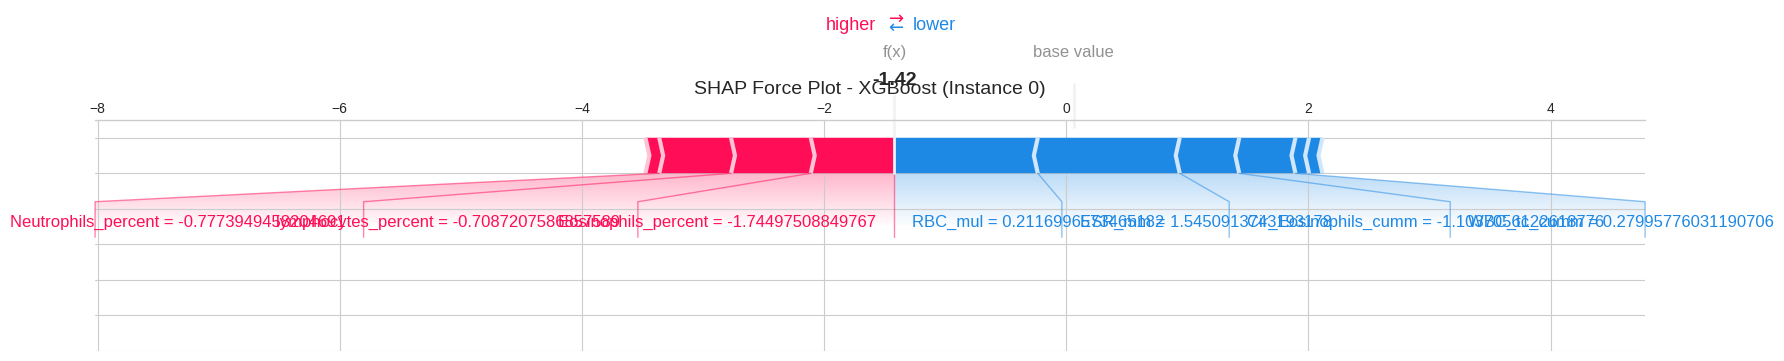

In [ ]:

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


if 'shap' in globals() and 'xgb_model_for_xai' in locals() and \
   'X_train_scaled' in locals() and 'X_test_scaled' in locals() and \
   'X_train_smote' in locals() and isinstance(X_train_smote, pd.DataFrame) and \
   not X_train_smote.empty:

    print(f"\n\n--- SHAP Analysis for XGBoost Model ---")


    num_scaled_features = X_train_scaled.shape[1]

    if num_scaled_features == len(X_train_smote.columns):

        actual_feature_names_for_shap = list(X_train_smote.columns)
        print(f"Using all {len(actual_feature_names_for_shap)} feature names from X_train_smote as X_train_scaled matches its width.")
    elif num_scaled_features < len(X_train_smote.columns):

        actual_feature_names_for_shap = list(X_train_smote.columns[:num_scaled_features])
        print(f"Warning: X_train_scaled has {num_scaled_features} features, while X_train_smote has {len(X_train_smote.columns)}.")
        print(f"Using the first {num_scaled_features} feature names from X_train_smote: {actual_feature_names_for_shap[:5]}...")

    else:
        print(f"Error: X_train_scaled has {num_scaled_features} features, which is MORE than X_train_smote.columns ({len(X_train_smote.columns)}). This is unexpected.")
        actual_feature_names_for_shap = None

    if actual_feature_names_for_shap is not None:

        if isinstance(X_train_scaled, np.ndarray):

            if X_train_scaled.shape[1] == len(actual_feature_names_for_shap):
                background_data_shap_df = pd.DataFrame(X_train_scaled, columns=actual_feature_names_for_shap)
            else:

                print(f"Critical Error: X_train_scaled (NumPy) column count {X_train_scaled.shape[1]} does not match derived feature name count {len(actual_feature_names_for_shap)}.")
                background_data_shap_df = None
        elif isinstance(X_train_scaled, pd.DataFrame):

            if list(X_train_scaled.columns) != actual_feature_names_for_shap:
                print(f"Re-assigning columns to X_train_scaled DataFrame to match derived feature names.")
                if X_train_scaled.shape[1] == len(actual_feature_names_for_shap):
                    background_data_shap_df = X_train_scaled.copy()
                    background_data_shap_df.columns = actual_feature_names_for_shap
                else:
                    print(f"Critical Error: X_train_scaled (DataFrame) column count {X_train_scaled.shape[1]} does not match derived feature name count {len(actual_feature_names_for_shap)}.")
                    background_data_shap_df = None
            else:
                background_data_shap_df = X_train_scaled
        else:
            print("Error: X_train_scaled is not a recognized type.")
            background_data_shap_df = None

        if background_data_shap_df is not None:
            background_sample_df = shap.sample(background_data_shap_df, min(100, background_data_shap_df.shape[0])) \
                if background_data_shap_df.shape[0] > 1 else background_data_shap_df


            explainer_shap_xgb = shap.Explainer(xgb_model_for_xai, background_sample_df)
            print(f"SHAP explainer initialized. Background data features example: {list(background_sample_df.columns[:3])}...")


            if isinstance(X_test_scaled, np.ndarray):
                if X_test_scaled.shape[1] == len(actual_feature_names_for_shap):
                    X_test_scaled_df_for_shap = pd.DataFrame(X_test_scaled, columns=actual_feature_names_for_shap)
                else:
                    print(f"Error: X_test_scaled (NumPy) has {X_test_scaled.shape[1]} columns, expected {len(actual_feature_names_for_shap)}.")
                    X_test_scaled_df_for_shap = None
            elif isinstance(X_test_scaled, pd.DataFrame):
                if X_test_scaled.shape[1] == len(actual_feature_names_for_shap):
                    X_test_scaled_df_for_shap = X_test_scaled.copy()
                    X_test_scaled_df_for_shap.columns = actual_feature_names_for_shap
                else:
                    print(f"Error: X_test_scaled (DataFrame) has {X_test_scaled.shape[1]} columns, expected {len(actual_feature_names_for_shap)}.")
                    X_test_scaled_df_for_shap = None
            else:
                print("Error: X_test_scaled is not a recognized type.")
                X_test_scaled_df_for_shap = None

            if X_test_scaled_df_for_shap is not None:

                print(f"Calculating SHAP values for test data with features example: {list(X_test_scaled_df_for_shap.columns[:3])}...")
                shap_explanation_obj_xgb = explainer_shap_xgb(X_test_scaled_df_for_shap)

                if len(shap_explanation_obj_xgb.values.shape) == 3:
                    shap_values_for_plot = shap_explanation_obj_xgb.values[:,:,1]
                    base_values_for_plot = shap_explanation_obj_xgb.base_values[:,1] if shap_explanation_obj_xgb.base_values.ndim > 1 and shap_explanation_obj_xgb.base_values.shape[-1] == 2 else \
                                           (shap_explanation_obj_xgb.base_values[1] if shap_explanation_obj_xgb.base_values.ndim == 1 and len(shap_explanation_obj_xgb.base_values) == 2 else shap_explanation_obj_xgb.base_values)
                    explanation_to_plot_xgb = shap.Explanation(
                        values=shap_values_for_plot,
                        base_values=base_values_for_plot,
                        data=X_test_scaled_df_for_shap.values,
                        feature_names=actual_feature_names_for_shap
                    )
                else:
                    explanation_to_plot_xgb = shap_explanation_obj_xgb
                    if not hasattr(explanation_to_plot_xgb, 'feature_names') or \
                       explanation_to_plot_xgb.feature_names is None or \
                       list(explanation_to_plot_xgb.feature_names) != actual_feature_names_for_shap:
                        explanation_to_plot_xgb.feature_names = actual_feature_names_for_shap
                    if not hasattr(explanation_to_plot_xgb, 'data') or explanation_to_plot_xgb.data is None:
                        explanation_to_plot_xgb.data = X_test_scaled_df_for_shap.values

                print(f"Feature names in final Explanation object for plotting: {list(explanation_to_plot_xgb.feature_names[:3])}...")


                instance_idx_to_explain = 0
                if X_test_scaled_df_for_shap.shape[0] > instance_idx_to_explain:
                    print(f"\nSHAP Force Plot for XGBoost (Instance {instance_idx_to_explain}):")
                    current_base_value = explanation_to_plot_xgb.base_values
                    if hasattr(current_base_value, '__len__') and len(current_base_value) > 1 :
                        base_value_for_force = current_base_value[instance_idx_to_explain]
                    else:
                        base_value_for_force = current_base_value[0] if hasattr(current_base_value, '__len__') else current_base_value
                    shap.force_plot(
                        base_value_for_force,
                        explanation_to_plot_xgb.values[instance_idx_to_explain,:],
                        X_test_scaled_df_for_shap.iloc[instance_idx_to_explain,:], # Series with correct names
                        matplotlib=True, show=False
                    )
                    plt.title(f"SHAP Force Plot - XGBoost (Instance {instance_idx_to_explain})", fontsize=14)
                    plt.show()
            else:
                print("Skipping SHAP calculation and plotting due to X_test_scaled data preparation issues.")
        else:
            print("Skipping SHAP explainer initialization due to background data preparation issues.")
    else:
        print("Skipping SHAP analysis: Could not determine valid feature names or prepare background data.")
else:
    print("Skipping SHAP analysis for XGBoost: Check prerequisites (SHAP, model, data variables).")





--- LIME Analysis for XGBoost Model ---

--- LIME Explanation for XGBoost (Instance position in test set: 2) ---
Actual Class: Positive (Class 1)
Predicted Probabilities: Negative (Class 0)=0.9720, Positive (Class 1)=0.0280


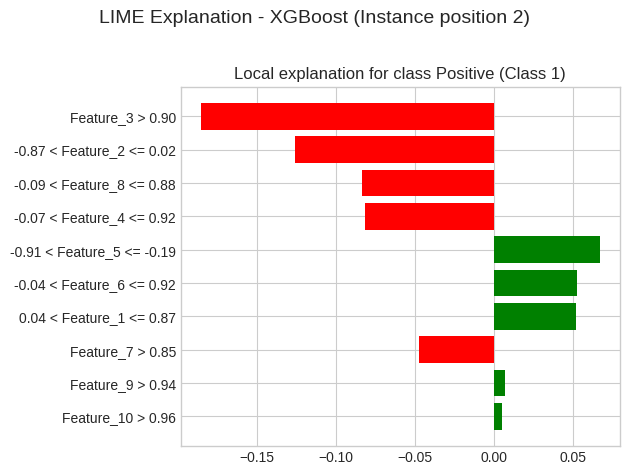

LIME Explanation as list (feature, weight):
[('Feature_3 > 0.90', -0.1855629262550123), ('-0.87 < Feature_2 <= 0.02', -0.1258305214605431), ('-0.09 < Feature_8 <= 0.88', -0.08331580931896387), ('-0.07 < Feature_4 <= 0.92', -0.08199454164400641), ('-0.91 < Feature_5 <= -0.19', 0.06681095181469483), ('-0.04 < Feature_6 <= 0.92', 0.052202972083489015), ('0.04 < Feature_1 <= 0.87', 0.05154341025313307), ('Feature_7 > 0.85', -0.047314403878279385), ('Feature_9 > 0.94', 0.006897635252948135), ('Feature_10 > 0.96', 0.004845454438059798)]

--- LIME Explanation for XGBoost (Instance position in test set: 4) ---
Actual Class: Negative (Class 0)
Predicted Probabilities: Negative (Class 0)=0.4475, Positive (Class 1)=0.5525


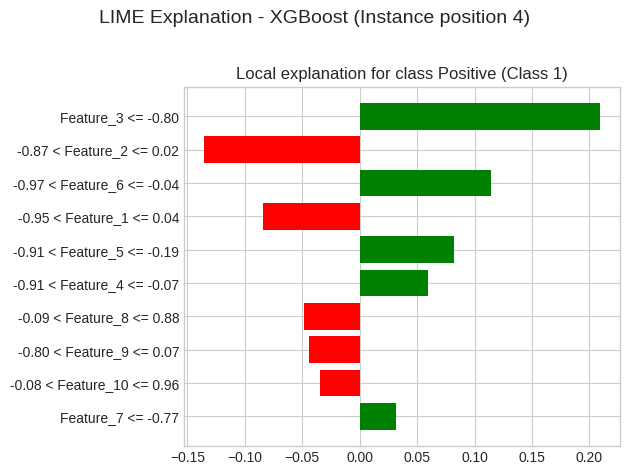

LIME Explanation as list (feature, weight):
[('Feature_3 <= -0.80', 0.20940398690638065), ('-0.87 < Feature_2 <= 0.02', -0.135642238805301), ('-0.97 < Feature_6 <= -0.04', 0.11443486930636851), ('-0.95 < Feature_1 <= 0.04', -0.08383437158619378), ('-0.91 < Feature_5 <= -0.19', 0.08241787536510288), ('-0.91 < Feature_4 <= -0.07', 0.05907612999937629), ('-0.09 < Feature_8 <= 0.88', -0.04879505973628542), ('-0.80 < Feature_9 <= 0.07', -0.04412297399391376), ('-0.08 < Feature_10 <= 0.96', -0.034841957176422404), ('Feature_7 <= -0.77', 0.031966733398582386)]

--- End of XAI for XGBoost Model ---


In [ ]:
if lime and lime.lime_tabular and 'xgb_model_for_xai' in locals() and \
   'X_train_scaled' in locals() and isinstance(X_train_scaled, pd.DataFrame) and \
   'X_test_scaled' in locals() and 'y_test' in locals() and \
   X_train_columns is not None:

    print("\n\n--- LIME Analysis for XGBoost Model ---")

    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_scaled.values,
        feature_names=X_train_columns,
        class_names=class_names,
        mode='classification',
        random_state=42,
        discretize_continuous=True
    )

    num_lime_explanations = 2

    num_instances = X_test_scaled.shape[0]
    instance_indices_lime = np.random.choice(num_instances, size=num_lime_explanations, replace=False)

    for instance_idx_lime in instance_indices_lime:

        instance_data_lime = X_test_scaled.iloc[instance_idx_lime].values \
            if isinstance(X_test_scaled, pd.DataFrame) else X_test_scaled[instance_idx_lime]

        print(f"\n--- LIME Explanation for XGBoost (Instance position in test set: {instance_idx_lime}) ---")
        actual_class_val = y_test.iloc[instance_idx_lime] if isinstance(y_test, pd.Series) else y_test[instance_idx_lime]
        print(f"Actual Class: {class_names[int(actual_class_val)]}")

        predicted_probas_instance = xgb_model_for_xai.predict_proba(instance_data_lime.reshape(1, -1))[0]
        print(f"Predicted Probabilities: {class_names[0]}={predicted_probas_instance[0]:.4f}, {class_names[1]}={predicted_probas_instance[1]:.4f}")

        lime_explanation_xgb = lime_explainer.explain_instance(
            data_row=instance_data_lime,
            predict_fn=xgb_model_for_xai.predict_proba,
            num_features=10,
            top_labels=None
        fig = lime_explanation_xgb.as_pyplot_figure()
        fig.suptitle(f"LIME Explanation - XGBoost (Instance position {instance_idx_lime})", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        print("LIME Explanation as list (feature, weight):")
        print(lime_explanation_xgb.as_list())
else:
    print("Skipping LIME analysis for XGBoost: LIME library, model, or necessary data components not available.")

print("\n--- End of XAI for XGBoost Model ---")
